# Collin Edits
* antenna size to 5x3 from 7.5x1.5
* transmit power to 1000W from 1500W
* summary tables include Look Angles
* PRF to Match winston's november runs
* look angles to match Winston's november runs
* rx_grnd_near and rx_grnd_width set to empty to match Winston's November runs
* --- Notable edits ---
* Altitude to 641 km
* PRF updated to fit Rx windows



# Purpose

* The purpose of **this Notebook** *(preliminary design)* is to provide a *quick exploration trade-space* during the intial stage of the radar instrument design cycle.
* Once the intial radar instrument looks feasible and its performances acceptable, the relevant radar instrument parameters will be used as inputs to the more detailed **Sausage Run** *(critical design)*.
* The outputs of the Sausage Run will, in turn, be fed into the **Science Performance Tool** *(final design)*.

### References
1. Paul A Rosen, *InSAR at Enceladus*, a Jupyter's notebook, Jan. 25, 2023. https://github.jpl.nasa.gov/parosen/EnceladusRadarDesignNotebook/blob/main/Enceladus_InSAR_Design.ipynb
2. Steve Horst, *prf_designer.py*, a Python's interactive design code, Jan. 01, 2020.

## 1. LD-S12C Instrument Architecture

![SDC-S12C.png](./Pix/SDC-S12C.png)

- **Introduction**
    - A constellation using low radiometric accuracy (NES0 = -15dB) and low orbital duty cycle (20%) designed to lower the cost per spacecraft to the minimum.
    - Spacecraft 1,2,3 looks at 30, 4,5,6 looks at 33, 7,8,9 looks at 36 and 10,11,12 look at 39. 
    - Each spacecraft has 3 degree beamwidth. 4 of them are enough to cover globe with 50% duty cycle. We have 1/3 of that duty cycle, hence 4*3 = 12 satellites are needed to cover as NISAR.
    - A possible representation of future commercial architecture
    - Attributes
        - Fast local revisit time for urgent response (1 day).
        - Fast local revisit time for Regional regions (US for instance)


- **Background**
    - Mission concept based on Marshall's study [1].
    - S-band SAR instrument based on Tendeg's study [2].
- **Instrument Top-Level Parameters**
    - Satellite's altitude.
    - Antenna's length & width.
    - Transmit frequency & power.
    - Antenna's look angles.

- **Instrument Requirements**
    - Desired resolutions.
    - Swath Coverage.
    - Noise-equivalent sigma zero (NES0).
    - Range ambiguity to signal ratio (RASR).
    - Azimuth ambiguity to signal ratio (AASR).

### References
1. Marshall, *SDC Spacecraft Design Study*, Oct. 27, 2022.
2. Tendeg, *High Aspect Ratio Cylindrical Parabolic Antenna for Microsats*, Dec. 17, 2021.

### Load Functions

In [1]:
# Python
import os
from os import path

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
from matplotlib.ticker import FormatStrFormatter

import pandas as pd

# Third-parties

import numpy as np
import csv
#BO
# %matplotlib ipympl
from tqdm.auto import tqdm 

# User-defined: Orbit Geometry

def look2inc(look,Re,Hs):
    inc= np.arcsin(np.sin(look)*(Re+Hs)/Re)
    return inc

def inc2look(inc,Re,Hs):
    look= np.arcsin(np.sin(inc)*Re/(Re+Hs))
    return look

def look2alpha(look,rho,Re):
    alpha= np.arcsin(np.sin(look)*rho/Re)
    return alpha

def inc2alpha(inc,Re,Hs,rho):
    alpha= np.arcsin(np.sin(inc)*rho/(Re+Hs))
    return alpha

def alpha2look(alpha,rho,Re):
    look= np.arcsin(np.sin(alpha)*Re/rho)
    return look

def alpha2inc(alpha,rho,Re,Hs):
    inc= np.arcsin(np.sin(alpha)*(Re+Hs)/rho)
    return inc

def alpha2slnt(alpha,Re,Hs):
    rho= np.sqrt(Re**2 + (Re+Hs)**2 - 2*Re*(Re+Hs)*np.cos(alpha))
    return rho

def look2slnt(look,Re,Hs):
    qa= 1; qb= -2*(Re+Hs)*np.cos(look); qc= ((Re+Hs)**2 - Re**2);
    rho= (-qb - np.sqrt(qb*qb - 4*qa*qc))/2*qa;
    return rho

def slnt2look(rho,Re,Hs):
    look= np.arccos((rho**2 + (Re+Hs)**2 - Re**2)/2/rho/(Re+Hs))
    return look

def inc2slnt(inc,Re,Hs):
    qa= 1; qb= 2*Re*np.cos(inc); qc= (Re**2 - (Re+Hs)**2);
    rho= (-qb + np.sqrt(qb*qb - 4*qa*qc))/2*qa;
    return rho

def alpha2grnd(alpha,Re):
    r_g= Re*alpha
    return r_g

def grnd2alpha(r_g,Re):
    alpha= r_g/Re
    return alpha

# User-defined: Secondary Axis in matplotlib

def plt_dist2time(x):
    # x in km, t in usec
    return 2*x*1e3/c*1e6 

def plt_time2dist(t):
    # x in km, t in usec
    return c*t/1e6/2/1e3 # km

def plt_slnt2grnd(slnt):
    # slnt in usec
    # grnd in km
    
    rng= slnt*1e-6*c/2    
    lk= slnt2look(rng,Re,Hs)
    alpha= look2alpha(lk,rng,Re)
    grnd= alpha2grnd(alpha,Re)/1e3
    return grnd

def plt_grnd2slnt(grnd):
    # slnt in usec
    # grnd in km

    alpha= grnd2alpha(grnd*1e3,Re)
    slnt= alpha2slnt(alpha,Re,Hs)/1e-6
    return slnt

def plt_look2inc(look):
    inc= np.arcsin(np.sin(look*onedeg)*(Re+Hs)/Re)
    return inc/onedeg

def plt_inc2look(inc):
    look= np.arcsin(np.sin(inc*onedeg)*Re/(Re+Hs))
    return look/onedeg

def plt_prf2pri(prf):
    # PRF in Hz, PRI in usec
    return 1e6/prf

def plt_pri2prf(pri):
    # PRF in Hz, PRI in usec
    return 1e6/pri

# User-defined: for variable's print-out

def format_print(x,scale,fmt):
    tmp= [fmt.format(val/scale) for val in x]
    y= [float(val) for val in tmp]
    return y

def print_geometry(title,near, mid, far, scale, unit,fmt):
    
    print('\n{}'.format(title))

    y= format_print(near,scale,fmt)
    print('    Near=  {} {}'.format(y, unit))
    y= format_print(mid,scale,fmt)
    print('    Mid=   {} {}'.format(y, unit))
    y= format_print(far,scale,fmt)
    print('    Far=   {} {}'.format(y, unit))
    y= format_print(near[1:] - far[:-1],scale,fmt)
    print('    Gap=   {} {}'.format(y, unit))

    
# User-defined: Antenna Pattern

def atn_ptrn(ant_type,ant_taper_type,ant_taper_params, angles, length_n):
    if ant_type=='rect_aperture':
        if ant_taper_type==None:
            pedestal= 1.0
            ptrn, p0, pp1, pm1= ant_rect_pattern(angles,length_n,pedestal)
        elif ant_taper_type=='COSPEDESTAL':
            print('COSPEDESTAL')
            pedestal= ant_taper_params[0]
            ptrn, p0, pp1, pm1= ant_rect_pattern(angles,length_n,pedestal)
        elif ant_taper_type=='TAYLOR':
            sll= ant_taper_params[0]
            nbar= ant_taper_params[1]
            norm= ant_taper_params[2]
            ptrn= ant_rect_taylor_pattern(angles,length_n,sll,nbar,norm)
            
    return ptrn

def ant_rect_pattern(angle,length_n,pedestal):
    # Ideal rectangular antenna + raised-cosine with pedestal
    # One-way one-dimension gain pattern in a principle direction
    # Special cases:
    #     pedestal = 0, Hann,
    #     pedestal = 0.08, Hamming.
    
    v0= length_n*np.sin(angle)
    
    sinc0= np.sinc(v0)
    sincp1= np.sinc(v0+1)
    sincm1= np.sinc(v0-1)

    p0= (1+pedestal)*sinc0
    pp1= (1-pedestal)/2*sincp1
    pm1= (1-pedestal)/2*sincm1

    ptrn= (p0 + pp1 + pm1)**2
    ptrn*= (2*length_n) / (3*pedestal**2 + 2*pedestal + 3)
    
    return ptrn, p0, pp1, pm1

def ant_rect_taylor_pattern(angle,length_n,sll,nbar,norm):
    # sll: sidelobelevel in dBc (<0).
    # nbar: # of constant sidelobes.
    # norm: normalizing
    #    0: no normalization
    #    1: coef-sum normalizing
    #    2: coef-power normalizing
    
    # One-way one-dimension gain pattern in a principle direction

    coeffs= taper_taylor_coeffs(sll,nbar,norm)

    v0= length_n*np.sin(angle)
    
    sinc0= np.sinc(v0)
    sincp1= np.sinc(v0+1)
    sincm1= np.sinc(v0-1)

    ptrn= coeffs[0]*np.sinc(v0)
    for m in range(1,nbar):
        ptrn+= coeffs[m]*(np.sinc(v0-m) + np.sinc(v0+m))
    
    ptrn= (ptrn**2)
    ptrn*= length_n    # normalization?
    
    return ptrn

def taper_CosPedestal(x, pedestal):
    # Special cases:
    #     pedestal = 0, Hann,
    #     pedestal = 0.08, Hamming.

    y= np.zeros(x.shape)

    for i,v in enumerate(x):
        if abs(v) > 0.5:
            y[i]= 0.0
        else:
            y[i]= pedestal + (1-pedestal)*0.5*(np.cos(2*np.pi*v)+0.5)
            
    return y

def taper_Taylor(x, coeff):
    ncoeff= len(coeff)
    
    y= np.zeros(x.shape)
    
    for i,v in enumerate(x):
        if v > 0.5:
            continue
        else:
            y[i]= coeff[0]
            for m in range(1,ncoeff):
                y[i]+= 2.0*coeff[m]*np.cos(2*np.pi*m*v)
    return y

def taper_taylor_coeffs(sll,nbar, norm):
    # sll: sidelobelevel in dBc (<0).
    # nbar: # of constant sidelobes.
    # norm: normalizing
    #    0: no normalization
    #    1: coef-sum normalizing
    #    2: coef-power normalizing
    
    eta= 10**(-sll/20)
    A= np.log(eta + np.sqrt(eta**2-1))/np.pi
    sigma2= (nbar**2)/(A**2 + (nbar-0.5)**2)
    
    coeffs= [1.0]
    coeffsum= 1.0
    coeffpwr= 1.0
    
    for m in range(1,nbar,1):
    
        fm= -0.5 if (m%2==0) else 0.5
        
        for n in range(1,nbar,1):
            fm*= (1 - m*m/sigma2/(A**2 + (n-0.5)**2))
            
        for n in range(1,nbar,1):
            if n!=m:
                fm/= (1 - m**2/n**2)
                
        coeffsum+= 2.0*fm;
        coeffpwr+= 2.0*fm*fm;                
        
        coeffs.append(fm)

    if norm==1:
        coeffs/= coeffsum
    elif norm==2:
        coeffs/= np.sqrt(coeffpwr)
        
    return coeffs

def read_ant_ptrn_01(file):
    # Simulated rectangular antenna
    # TICRA DATA EXPORT: CSV file, elevation/azimuth cuts
    
    nheaders= 6
    headers = []
    rows = []

    with open(file, 'r') as file:
        data = csv.reader(file)

        for iheader in range(nheaders-1):
            headers.append(next(data))

        nrows= float(next(data)[0])

        for row in data:
            rows.append([float(val) for val in row])

    nextra= int(len(rows) - nrows) 
    if nextra > 0:
        for i in range(nextra):
            rows.pop()
    
    ptrn= np.array(rows)
    ptrn[:,1]= 10**(ptrn[:,1]/10)
    
    return len(rows), headers, ptrn 

def lin_interp_1d(arr, val):
    # Scalar.
    
    if (val <= arr[0,0]):
        return arr[0,1];
    elif (val >= arr[-1,0]):
        return arr[-1,1];
    else:
        idx= np.nonzero(arr[:,0] < val)[0][-1]
        interp= arr[idx,1] + (val-arr[idx,0])*((arr[idx+1,1]-arr[idx,1])/(arr[idx+1,0]-arr[idx,0]))
        return interp
  
def lin_interp_1d_arr(ptrn, arr):
    # Vector. Note that np.interp is much faster
    
    ashape= arr.shape
    
    if len(ashape) > 1:
        nr, nc= ashape
        y= np.zeros((nr,nc))
        for i in range(nr):
            row= np.array([])
            for x in arr[i,:]:
                row= np.append(row,lin_interp_1d(ptrn, x))
            y[i,:]= row
    else:
        nc= ashape[0]
        y= np.array([])
        for x in arr:
            y= np.append(y,lin_interp_1d(ptrn, x))

    return y

def find_bw(angle,ptrn,length_n):
    # Inputs:
    # angle: radian.
    # ptrn: linear scale.
    # length_n: normalized length by wavelength.
    # Outputs:
    # bw_3db: 3dB beamwidth (FWHM: fulll-width at half-max).
    # bwf: beamwidth factor.
    
    x= angle
    y= np.abs(ptrn)
    
    amax= np.max(y)
    idx= np.nonzero(y > 0.5*amax)[0]
    bw_3db= x[idx[-1]] - x[idx[0]]
    bwf= bw_3db*length_n
    amax= np.max(ptrn)

    return bwf, bw_3db, amax


# User-defined: BFPQ Quantization

def sqnr(nbits):
    # BFPQ technique (see Sausage doc)
    
    # QNR table
    qnr_tab= {1: 4.4,
              2: 9.25,
              3: 14.27,
              4: 19.38,
              5: 24.57,
              6: 29.83,
              7: 35.17,
              8: 40.57,
              9: 46.03,
              10: 51.55,
              11: 57.11,
              12: 62.71,
              13: 68.35,
              14: 74.01,
              15: 79.70,
              16: 85.40}
    
    return qnr_tab[nbits]


# User-defined: FFT length 

def nextpow2(nsamps):
    n= np.ceil(np.log2(np.abs(nsamps)))
    return n
    
def fftlng(nsamps):
    L= int(2**nextpow2(nsamps))
    return L
                                          

### For Coverage

In [2]:
#BO
def wrapToPi(x):
    return np.mod(x+np.pi,2*np.pi)-np.pi 

def wrapToNum(x,num):
    return np.mod(x+num,2*num)-num 

class Clusters():
    def __init__(self, range=[-np.inf,np.inf], wrap=False, entries=[]):
        self.range=range
        self.wrap=wrap
        self.begin=[]
        self.end  =[]
        entries=self._check_entries(entries)
        if entries:
            for e in entries:
                if len(self.begin)==0:
                    self.begin.append(e[0])#np.min(e))
                    self.end.append(e[1])#np.max(e))
                    continue
                self._add_single_entry(e)
    def _find_intersect(self, entry, check_begin=True, check_end=True):
        e0=entry[0]#np.min(entry)
        eN=entry[1]#np.max(entry)
        for k,(b,e) in enumerate(zip(self.begin, self.end)):
            if check_begin and b<e0 and e>e0: #Start point is touching an existing cluster
                return k
            elif check_end and b<eN and e>eN: #End point is touching an existing cluster
                return k
        return None # If the loop finished return None to indicate no intersect. 
    def _add_single_entry(self, entry):
        e0=np.array(entry[0])#np.min(entry)
        eN=np.array(entry[1])#np.max(entry)
        k=None
        if np.logical_and(self.begin<e0, self.end >e0).any(): # start point is touching one of the clusters 
            k=self._find_intersect(entry, check_begin=True, check_end=False)
        elif np.logical_and(self.begin<eN, self.end >eN).any(): # end point is touching one of the clusters
            k=self._find_intersect(entry, check_begin=False, check_end=True)
        if k: #there is an intersect
            self.begin[k]=float(np.min([self.begin[k], e0])) # float() because we don't want to add as array
            self.end[k]  =float(np.max([self.end[k], eN]))
        else: # There is no intersect, so start a new cluster
            self.begin.append(float(e0))
            self.end.append(float(eN))
    def _merge_clusters(self):
        delete_indices=[]
        found_something=False
        #print(f'Merge: {self.as_list()})')
        for k,b in enumerate(self.begin):
            if k in delete_indices:
                continue # If we are going to delete this element no need to merge...
            if np.any(np.logical_and(self.begin < np.array(b), self.end > np.array(b))): # we can merge existing clusters
                found_something=True
                l=np.where(np.logical_and(self.begin < np.array(b), self.end > np.array(b)))[0][0] # only merge with the first one. 
                delete_indices.append(l)
                self.begin[k]=np.min([self.begin[k], self.begin[l]])
                self.end[k]  =np.max([self.end[k],   self.end[l]])
        #delete merged ones.
        #print(f'delete indices:{delete_indices}')
        #print(f'begin: {self.begin}')
        if len(delete_indices)>0:
            for k in np.sort(list(set(delete_indices)))[::-1]: #use set to remove duplicates, reverse sort to avoid issues with delete
                del self.begin[k]
                del self.end[k]
        #print(f'After begin: {self.as_list()})')
        #check end points.
        delete_indices=[] #reinitialize delete list. 
        for k,e in enumerate(self.end):
            if k in delete_indices:
                continue # If we are going to delete this element no need to merge...
            if np.any(np.logical_and(self.begin<np.array(e), self.end >np.array(e))): # we can merge existing clusters
                found_something=True
                l=np.where(np.logical_and(self.begin<np.array(e), self.end >np.array(e)))[0][0]
                delete_indices.append(l)
                self.begin[k]=np.min([self.begin[k], self.begin[l]])
                self.end[k]  =np.max([self.end[k],   self.end[l]])
        if len(delete_indices)>0:
            for k in np.sort(list(set(delete_indices)))[::-1]: #use set to remove duplicates, reverse sort to avoid issues with delete
                del self.begin[k]
                del self.end[k]
        #print(f'After end: {self.as_list()})')
        #check same start and end points
        delete_indices=[] #reinitialize delete list. 
        
        for k,(b,e) in enumerate(zip(self.begin,self.end)):
            for l,(lb,le) in enumerate(zip(self.begin[k+1:],self.end[k+1:])):
                if b==lb and e==le:
                    found_something=True
                    delete_indices.append(k+1+l)
        if len(delete_indices)>0:
            for k in np.sort(list(set(delete_indices)))[::-1]: #use set to remove duplicates, reverse sort to avoid issues with delete
                del self.begin[k]
                del self.end[k]                
        if found_something:
            #re-run to make sure the new clusters are not touching:
            self._merge_clusters()
        #else:
        # we are done... 
    def _check_entries(self, entries):
        # ensure it's list of lists
        if not entries: # None or []
            return entries
        if type(entries)==list:
            if type(entries[0])!=list:
                entries=list(entries)
        else:
            raise ValueError('Entries must be list of lists')
        #check the range 
        split_entries=[]
        r0=np.min(self.range)
        rN=np.max(self.range)
        for k,e in enumerate(entries):
            e0=e[0]#np.min(e)
            eN=e[1]#np.max(e)
            if e0 < r0:
                if eN > rN:#complete range is covered
                    entries=[[r0, rN]] 
                    return entries
                else:#split into two entries
                    entries[k]=[r0,eN]
                    if self.wrap:
                        wrap_around=r0-e0 # should be positive
                        split_entries.append([rN-wrap_around,rN])
            if eN > rN:
                if e0 < r0:#complete range is covered
                    entries=[[r0, rN]] #shouldn't happen since we already checked this condition above.  
                    return entries
                else:#split into two entries
                    entries[k]=[e0,rN]
                    if self.wrap:
                        wrap_around=eN-rN # should be positive
                        split_entries.append([r0,r0+wrap_around])
            if self.wrap: #check anti-meridian
                if e0>eN:
                    entries[k]=[e0,rN]
                    split_entries.append([r0,eN])
        entries=entries + split_entries #combine lists
        return entries
    def add(self, entries):
        entries=self._check_entries(entries)
        for e in entries:
            if len(self.begin)==0:
                self.begin.append(e[0])#np.min(e))
                self.end.append(e[1])#np.max(e))
                continue
            self._add_single_entry(e)
        self._merge_clusters()
    def as_list(self):
        return [ [b,e] for b,e in zip(self.begin, self.end) ]
    def as_array(self, sort=True):
        caa=np.array(cluster.as_list())#cluster_as_array
        if sort:
            return caa[caa[:,0].argsort()]
        else:
            return caa
def test_clusters():
    #Test clusters
    cluster=Clusters(range=[-180,180], wrap=True)
    cluster.add([[-1,1]]) # test adding
    #print(f'b: {cluster.begin} e: {cluster.end}')
    print(cluster.as_list())
    cluster.add([[-1,1]]) # test adding the same element again
    print(cluster.as_list())
    cluster.add([[-6,-5]]) # test adding a second element
    print(cluster.as_list())
    cluster.add([[-7,2]]) # test adding a third that covers both
    print(cluster.as_list())
    cluster.add([[5,10]]) # create a narrow gap
    print(cluster.as_list())
    #cluster.add([[1.9,5.1]])
    cluster.add([[1.9,3.1],[3,4.1],[4,5.1]]) # fill gap with multiple touching entries
    print(cluster.as_list())
    cluster.add([[179.8, -179.8]]) # test anti-meridian coverage
    print(cluster.as_list())
    cluster.add([[-181,-179]]) # test adding a wrap around element
    print(cluster.as_list())
    cluster.add([[179,181]]) # test adding a wrap around element on the other side, same as above if wrap=True
    print(cluster.as_list())
    cluster.add([[-181,180]]) # cover the whole range
    print(cluster.as_list())

## 2. Input Parameters: Equations

- Coordinate Systems (A) and Viewing Geometry (B) 
  - (x,y,z), global: rotates with the planet.
  - (s,c,h), local: rotates with the planet-fixed platform position and velocity vectors.
  - (I,J,K), antenna: rotates with the physical orientation of the antenna.

A | B
- | - 
<img src="./Pix/sausage-basic-geo.png" alt="sausage-basic-geo.png" /> | <img src="./Pix/sausage-viewing-geo.png" alt="sausage-viewingc-geo.png" />

<br>

- Law of Sines

$$ \frac{\sin\theta_{look}}{R_p} = \frac{\sin\theta_{inc}}{R_p+h_{plat}} =\frac{\sin\alpha_p}{\rho} $$
$\label{eq2-1}\tag{2-1}$

- Law of Cosines

$$ \rho^2 = R_p^2 + (R_p + h_{plat})^2 - 2R_p(R_p+h_{plat})\cos\alpha_p, \label{eq2-2}\tag{2-2}$$

$$ R_p^2 = \rho^2 + (R_p + h_{plat})^2 -2\rho(R_p+h_{plat})\cos\theta_{look}, $$

$$(R_p+h_{plat})^2 = R_p^2 + \rho^2 + 2R_p\rho\cos\theta_{inc}$$

- Ground Squint Angle
\\( \theta_{gsq} = ??? \\)

- Ground Range

$$ r_g = R_p \alpha_p \label{eq2-3}\tag{2-3}$$

- Cross Range

$$ r_c = (R_p\sin\alpha_p)(\theta_{gsq} - \theta_{gsq0}) \label{eq2-4}\tag{2-4}$$

### References
1. Curtis Chen, *Sausage: User Manual and Algorithm Description*, Oct. 06, 2020.

### Input Parameters: Code

In [3]:
###### Static Parameters #####

# Physical constants

k= 1.3806493e-23    # m2 kg s-2 K-1, Bolztmann's constant
c= 3.0e8            # m/s, speed of light

# Math's constant

pi= np.pi
onedeg= pi/180.0

# Earth's Parameters

Re= 6378.1363e3     # m, Earth's radius
Me= 5.97226e+24     # kg, Earth's mass
Ge= 6.673e-11;      # N-m2/kg2, Universal Gravitational Constant

# Other constants

fsov= 1.            # O/V (real) sampling
fsiq= 2.            # I/Q (cplx) sampling


###### Orbital Parameters #####

# Satellite's orbital parameters

#Hs = 747e3          # m, satellite's altitude
Hs = 641e3          # m, satellite's altitude, 2024/01/17.
#Hs = 747e3*(1+0.05)          # m, satellite's altitude


##### Antenna Parameters #####
# ['rect_aperture'  (analytic pattern), 
#  'separable_cuts' (table lookup)]

La= 5             # m, antenna's length
Wa= 3             # m, antenna's width
bwf= 0.89           # -, beamwidth factor

ant_type= 'rect_aperture'    # ['rect_aperture', 'separable_cuts']

# Antenna Tapering
# [None, 'COSPEDESTAL', 'TAYLOR']

ant_xtaper_type= [None, None, None, None]    # azimuth    
ant_xtaper_params= [[1], [1], [1], [1]]

ant_ytaper_type= [None, None, None, None]    # range  
ant_ytaper_params= [[1], [1], [1], [1]]
#ant_ytaper_type= [None, None, None, 'COSPEDESTAL']    # range  
#ant_ytaper_params= [[1], [1], [1], [0.3]]
#ant_ytaper_type= [None, None, None, 'TAYLOR']    # range  
#ant_ytaper_params= [[1], [1], [1], [-20,3,2]]    # taylor: SLL, NBAR, NORM

# Separable Cuts

if ant_type == 'separable_cuts':
    file_rng= 'Downloads/offset_fed_0deg.dat'    # range (elevation) cut
    file_azi= 'Downloads/offset_fed_90deg.dat'   # xrange (azimuth) cut

# Transmit/Receive

fc= 3.2e9           # Hz, transmit frequency
Pt= 1000            # W, transmit power 

eta_a= -3           # dB, one-way antenna efficiency (radiation + aperture)

L_feed= -0.5        # dB, antenna feed loss
L_circ= -2.5        # dB, antenna cable circulator loss
#L_circ= -0.5        # dB, antenna cable circulator loss

L_tx= 0.            # dB, transmit loss
L_rx= 0.            # dB, receive loss


##### Receiver #####

# Noise Figure

T_src= 250             # K, source temperature
F_op= 3.58             # -, operating noise factor


##### Imaging Geometry #####

# Look angles

#theta_lk= [31.5, 34.5, 37.5, 40.5]      # deg, antenna's mechanical look angle. 2023/12/19.        
#theta_lk= [29.7, 32.7, 35.4, 38.2]      # deg, antenna's mechanical look angle. 2023/12/20      
theta_lk= [34.5, 36.0, 37.5, 39.0]      # deg, to match Winston's. 2024/01/17

theta_sq= [0]                 # deg, antenna's mechanical squint angle

# Ground near range & swath width

# Empty, use antenna's beamwidths

rx_grnd_near= []
rx_grnd_width= []

# User-specified swath

#rx_grnd_near= [439.5, 497.2, 565.3, 630.0 ]  # km, 2023/12/19
#rx_grnd_width= [60.9, 68.8, 67.1, 54.6]    # km

#rx_grnd_near= [406.9, 462.1, 521.5, 578.9]  # km, 2023/12/20
#rx_grnd_width= [57.0, 61.7, 58.2, 69.0]    # km
# set to empty to use antenna's beamwidths basedon Winston's run. 2024/01/17

##### Backscatter model #####

# Backscatter model

scattering_model= 'Ulaby-Dobson'        # Ulaby-Dobson table
scene_type= 'Soil-L-HH'                # 'Scene-Band-Polarization'
scat_n_sigmas= 0                        # number of standard deviations


##### Radar Timing Parameters #####

# Radar Timing Parameters

pw= 33.4e-6           # s, transmit pulse width
tau_grd= 5e-6      # s, guard time on both sides of transmit event
pw_nadir= pw        # s, pulse width of nadir return
tau_swext= pw         # s, swath extension, typically 1 pusle width
tau_swext= 0         # s, swath extension, set to 0 as in prf_designer

#PRF_l= [2420,2810,2220,2430]        # to be adjusted based on RASR/AASR performances. 2023/12/19.
#PRF_l= [2830,2240,2620,2200]        # to be adjusted based on RASR/AASR performances. 2023/12/20.
#PRF_l= [4420,4010,3630,3835]        # set to match Winston's 11/17/2023; by CP 1/16/2024.
PRF_l= [4420,3980,3700,3980]        # adjusting to fit window. 2024/01/17
# Digital Parameters

fsamp= 96e6         # Hz, sampling frequency
fstype= fsiq        # sampling type, [fsov, fsiq]
nbits= 4            # -, quantization


##### Processing Parameters #####

# Desired resolution

res_azi= 15.0          # m, desired azimuth resolution
res_rng= 15.0          # m, desired range resolution
# updated to 15 from 5, 1/19/2024

# Compression Tapering

rctaper_type= ['COSPEDESTAL', 'COSPEDESTAL', 'COSPEDESTAL', 'COSPEDESTAL']    # range compression    
rctaper_params= [[0.3], [0.3], [0.3], [0.3]]

actaper_type= ['COSPEDESTAL', 'COSPEDESTAL', 'COSPEDESTAL', 'COSPEDESTAL']    # azimuth compression    
actaper_params= [[0.3], [0.3], [0.3], [0.3]]

#----- Simulation Parameters -----#

Ntgt_rng= 100       # -, # of targets per beam along the range direction (cross-track)
Ntgt_azi= 100       # -, # of targets per beam  along the azimuth direction (along-track)

angle_azcut_wid= 60 # degree, antenna azimuth cutwidth for AASR computaiton
Npnt_aasr= 9000      # -, number of point for AASR computation

#angle_azcut_wid= 20 # degree, antenna azimuth cutwidth for AASR computaiton
#Npnt_aasr= 1000      # -, number of point for AASR computation


## 3. Derived Parameters: Equations

- SAR Viewing Geometry

![SAR-geometry-curlander-2.png](./Pix/SAR-geometry-curlander-2.png)

- Satellite Velocity

$$ V_s = \sqrt{\frac{G_eM_e}{R_eH_s}} \label{eq3-1}\tag{3-1}$$

- Radar Wavelength

$$ \lambda=c/f \label{eq3-2}\tag{3-2}$$

- Maximum Antenna Gain

$$ G_{max}=\rho_e L_{feed} L_{circ} \frac{4\pi L_aW_a}{\lambda^2} = \rho \frac{4\pi A_p}{\lambda^2} = \rho D_0  \label{eq3-3}\tag{3-3}$$

where

\\( \rho= \rho_e \rho_a \\): antenna efficiency.

\\( \rho_e \\): antenna radiaton efficiency.

\\( \rho_a = L_{feed} L_{circ} \\): antenna aperture efficiency.

\\( A_p= L_a W_a \\): antenna physical aperture.

\\( D_0 \\): antena directivity.

- 3dB Antenna Elevation/Azimuth Beamwidths

$$ \theta^{3dB}_{ele} = \beta_e\lambda/W_a \label{eq3-4}\tag{3-4}$$

$$ \theta^{3dB}_{azi} = \beta_a\lambda/L_a $$

- Look Angles (near/far)

$$ \theta_l^{near} = \theta_l-\theta^{3dB}_{ele}/2 \label{eq3-5}\tag{3-5}$$

$$ \theta_l^{far} = \theta_l+\theta^{3dB}_{ele}/2 $$

- Incident Angle

$$ \theta_i=\sin^{-1}(\frac{R_e+H_s}{R_e}\sin\theta_l) \label{eq3-6}\tag{3-6}$$

- Slant Ranges (law of cosines)

$$ (R_e+H_s)^2=R_e^2 + R_{sl}^2 + 2R_eR_{sl}\cos\theta_i \label{eq3-7}\tag{3-7}$$

### References
1. Curtis Chen, *Sausage: User Manual and Algorithm Description*, Oct. 06, 2020.
2. Curlander, J.C.; McDonough, R.N. *Synthetic Aperture Radar: Systems and Signal Processing*; John Wiley & Sons: New York, NY, USA, 1991.

### Derived Parameters: Code

In [4]:
Vs= np.sqrt(Ge*Me/(Re+Hs))          # m/s, satellite's velocity

print('Satellite Altitude= {:.1f} km'.format(Hs/1e3))
print('Satellite Velocity= {:.1f} m/s'.format(Vs))

## Computing Antenna's directivity & gain

# Ideal Pattern

wavelng= c/fc                       # m, wavelength

print('\nFrequency, Wavelength= {:.1f} GHz, {} m'.format(fc/1e9, wavelng))
print('Transmitted Power= {:.1f} W'.format(Pt))

D0= (4*pi*La*Wa)/(wavelng*wavelng)              # one-way directivity
Loss_antenna= 10**((L_feed+L_circ+eta_a)/10)    # one-way loss
Gmax= Loss_antenna*D0                           # one-way antenna gain including loss

# Actual Pattern: 3dB Beamwidth (FWHM) and Beamwidth Factor

Nbeams= len(theta_lk)

theta= np.arange(-90,90,0.05)*onedeg    # antenna off-boresight angle

Gmax_act= []
bwf_ele= np.array([]); beam_wd_ele= np.array([]); amax_ele= np.array([])
bwf_azi= np.array([]); beam_wd_azi= np.array([]); amax_azi= np.array([])

for ib in range(Nbeams):
    
    antptrn_ele= atn_ptrn(ant_type,ant_ytaper_type[ib],ant_ytaper_params[ib], 
                           theta, Wa/wavelng)

    bwf, beam_wd, amax= find_bw(theta,antptrn_ele,Wa/wavelng)
    bwf_ele= np.append(bwf_ele,bwf)
    beam_wd_ele= np.append(beam_wd_ele,beam_wd)
    amax_ele= np.append(amax_ele,amax)

    antptrn_azi= atn_ptrn(ant_type,ant_xtaper_type[ib],ant_xtaper_params[ib], 
                           theta, La/wavelng)

    bwf, beam_wd, amax= find_bw(theta,antptrn_azi,La/wavelng)
    bwf_azi= np.append(bwf_azi,bwf)
    beam_wd_azi= np.append(beam_wd_azi,beam_wd)
    amax_azi= np.append(amax_azi,amax)
        
D0_act= 4*np.pi*amax_ele*amax_azi    # actual one-way directivity
Gmax_act= Loss_antenna*D0_act        # actual one-way antenna gain including loss

print('\nAntenna dimensions (azi x ele): {:.1f} x {:.1f} m'.format(La, Wa))

fmt= '{:.1f}'
y= format_print(beam_wd_azi,onedeg,fmt)
print('Antenna beamwidths, azi: {} deg'.format(y))
y= format_print(beam_wd_ele,onedeg,fmt)
print('Antenna beamwidths, ele: {} deg'.format(y))

fmt= '{:.2f}'
y= format_print(bwf_azi,1,fmt)
print('Antenna beamwidth factor, azi: {}'.format(y))
fmt= '{:.2f}'
y= format_print(bwf_ele,1,fmt)
print('Antenna beamwidth factor, azi: {}'.format(y))

print('\n(ideal) Antenna directivity / loss / gain (one-way): {:.1f} dBi / {:.1f} dB / {:.1f} dB'.format(
    10*np.log10(D0), 10*np.log10(Loss_antenna), 10*np.log10(Gmax)))

fmt= '{:.1f}'
y= format_print(10*np.log10(D0_act),1,fmt)
print('(actual) Antenna directivity (one-way): {} dBi'.format(y))
fmt= '{:.1f}'
y= format_print(10*np.log10(Gmax_act),1,fmt)
print('(actual) Antenna gain (one-way): {} dB'.format(y))
      
# Conventions
# "echo": determined by Antenna's FWHM
# "rx": determined by Rx Window settings.

# Echo: Computing Look/Incident angles

echo_look= np.array(theta_lk)*onedeg
echo_sqnt= np.array(theta_sq)*onedeg

echo_look_mid= np.copy(echo_look)
echo_inc_mid= look2inc(echo_look_mid,Re,Hs)
echo_slnt_mid= look2slnt(echo_look_mid,Re,Hs)
echo_alpha_mid= inc2alpha(echo_inc_mid,Re,Hs,echo_slnt_mid)
echo_grnd_mid= alpha2grnd(echo_alpha_mid,Re)

# Use antenna's beamwidth    
echo_look_nea= echo_look - beam_wd_ele/2
echo_look_far= echo_look + beam_wd_ele/2

echo_inc_nea= look2inc(echo_look_nea,Re,Hs)
echo_inc_far= look2inc(echo_look_far,Re,Hs)

# Slant ranges

echo_slnt_nea= inc2slnt(echo_inc_nea,Re,Hs)
echo_slnt_far= inc2slnt(echo_inc_far,Re,Hs) + c*tau_swext/2    # extending swath by a pulse width

echo_swath_slnt= echo_slnt_far - echo_slnt_nea

echo_look_far= slnt2look(echo_slnt_far,Re,Hs)    # Correct far range after extension
echo_inc_far= look2inc(echo_look_far,Re,Hs)

# Planet-central angles

echo_alpha_nea= inc2alpha(echo_inc_nea,Re,Hs,echo_slnt_nea)
echo_alpha_far= inc2alpha(echo_inc_far,Re,Hs,echo_slnt_far)

# Ground ranges

echo_grnd_nea= alpha2grnd(echo_alpha_nea,Re)
echo_grnd_far= alpha2grnd(echo_alpha_far,Re)

echo_swath_grnd= echo_grnd_far - echo_grnd_nea

# Rx: Computing Look/Incident angles (User-specified swath)  

rx_look_mid= np.copy(echo_look_mid)
rx_inc_mid= np.copy(echo_inc_mid)
rx_slnt_mid= np.copy(echo_slnt_mid)
rx_alpha_mid= np.copy(echo_alpha_mid)
rx_grnd_mid= np.copy(echo_grnd_mid)

if rx_grnd_near:
    # User-specified swath
    rx_swath_grnd= 1e3*np.array(rx_grnd_width)
    
    rx_grnd_nea= 1e3*np.array(rx_grnd_near)
    rx_grnd_far= rx_grnd_nea + rx_swath_grnd 
    
    rx_alpha_nea= grnd2alpha(rx_grnd_nea,Re)
    rx_alpha_far= grnd2alpha(rx_grnd_far,Re)
    
    rx_slnt_nea= alpha2slnt(rx_alpha_nea,Re,Hs)
    rx_slnt_far= alpha2slnt(rx_alpha_far,Re,Hs) + c*tau_swext/2    # extending swath by a pulse width

    rx_swath_slnt= rx_slnt_far - rx_slnt_nea

    rx_look_far= slnt2look(rx_slnt_far,Re,Hs)    # Correct far range after extension
    rx_inc_far= look2inc(rx_look_far,Re,Hs)
    rx_alpha_far= inc2alpha(rx_inc_far,Re,Hs,rx_slnt_far)
    
    rx_look_nea= alpha2look(rx_alpha_nea,rx_slnt_nea,Re)
    rx_inc_nea= alpha2inc(rx_alpha_nea,rx_slnt_nea,Re,Hs)

else: 

    rx_swath_grnd= echo_swath_grnd
    
    rx_grnd_nea= echo_grnd_nea
    rx_grnd_far= echo_grnd_far 
    
    rx_alpha_nea= echo_alpha_nea
    rx_alpha_far= echo_alpha_far
    
    rx_slnt_nea= echo_slnt_nea
    rx_slnt_far= echo_slnt_nea

    rx_swath_slnt= echo_swath_slnt

    rx_look_nea= echo_look_nea
    rx_look_far= echo_look_far

    rx_inc_nea= echo_inc_nea
    rx_inc_far= echo_inc_far
    
# Print out geometry

fmt= '{:.1f}'

title= 'Look angles, Echo:'
print_geometry(title, echo_look_nea, echo_look_mid, echo_look_far, onedeg, 'deg',fmt)
y= format_print(echo_look_far - echo_look_nea,onedeg,fmt)
print('    Swath= {}  deg'.format(y))

title= 'Look angles, Rx:'
print_geometry(title, rx_look_nea, rx_look_mid, rx_look_far, onedeg, 'deg',fmt)
y= format_print(rx_look_far - rx_look_nea,onedeg,fmt)
print('    Swath= {}  deg'.format(y))

title= 'Incident angles, Echo:'
print_geometry(title, echo_inc_nea, echo_inc_mid, echo_inc_far, onedeg, 'deg',fmt)
y= format_print(echo_inc_far - echo_inc_nea,onedeg,fmt)
print('    Swath= {}  deg'.format(y))

title= 'Incident angles, Rx:'
print_geometry(title, rx_inc_nea, rx_inc_mid, rx_inc_far, onedeg, 'deg',fmt)
y= format_print(rx_inc_far - rx_inc_nea,onedeg,fmt)
print('    Swath= {}  deg'.format(y))

title= 'Planet-central angles, Echo:'
print_geometry(title, echo_alpha_nea, echo_alpha_mid, echo_alpha_far, onedeg, 'deg',fmt)
y= format_print(echo_alpha_far - echo_alpha_nea,onedeg,fmt)
print('    Swath= {}  deg'.format(y))

title= 'Planet-central angles, Rx:'
print_geometry(title, rx_alpha_nea, rx_alpha_mid, rx_alpha_far, onedeg, 'deg',fmt)
y= format_print(rx_alpha_far - rx_alpha_nea,onedeg,fmt)
print('    Swath= {}  deg'.format(y))

title= 'Slant ranges, Echo:'
print_geometry(title, echo_slnt_nea, echo_slnt_mid, echo_slnt_far, 1e3, 'km',fmt)
y= format_print(echo_swath_slnt,1e3,fmt)
print('    Swath= {}  km'.format(y))

title= 'Slant ranges, Rx:'
print_geometry(title, rx_slnt_nea, rx_slnt_mid, rx_slnt_far, 1e3, 'km',fmt)
y= format_print(rx_swath_slnt,1e3,fmt)
print('    Swath= {}  km'.format(y))

title= 'Ground ranges, Echo:'
print_geometry(title, echo_grnd_nea, echo_grnd_mid, echo_grnd_far, 1e3, 'km',fmt)
y= format_print(echo_swath_grnd,1e3,fmt)
print('    Swath= {} km'.format(y))

title= 'Ground ranges, Rx:'
print_geometry(title, rx_grnd_nea, rx_grnd_mid, rx_grnd_far, 1e3, 'km',fmt)
y= format_print(rx_swath_grnd,1e3,fmt)
print('    Swath= {} km'.format(y))

title= 'Ground ranges, Echo:'
print_geometry(title, plt_dist2time(echo_grnd_nea/1e3), 
                      plt_dist2time(echo_grnd_mid/1e3), plt_dist2time(echo_grnd_far/1e3), 1, 'usec',fmt)
y= format_print(plt_dist2time(echo_swath_grnd/1e3),1,fmt)
print('    Swath= {} usec'.format(y))

title= 'Ground ranges, Rx:'
print_geometry(title, plt_dist2time(rx_grnd_nea/1e3), 
                      plt_dist2time(rx_grnd_mid/1e3), plt_dist2time(rx_grnd_far/1e3), 1, 'usec',fmt)
y= format_print(plt_dist2time(rx_swath_grnd/1e3),1,fmt)
print('    Swath= {} usec'.format(y))

# (Slant-range) Resolution & Tx Bandwidth

res_slnt= 15.0*np.sin(echo_inc_mid)  # 15m
tx_bw= c/2./res_slnt                 # MHz  

print('\nTx Bandwidth (slant): (for {:.1f} m ground-range resolution)'.format(15.0))
y1= format_print(tx_bw,1e6,fmt)
y2= format_print(res_slnt,1,fmt)
print('    Mid= {} MHz'.format(y1))
print('       = {} m'.format(y2))

res_slnt= 10.0*np.sin(echo_inc_mid)  # 10m
tx_bw= c/2./res_slnt                 # MHz  

print('\nTx Bandwidth (slant): (for {:.1f} m ground-range resolution)'.format(10.0))
y1= format_print(tx_bw,1e6,fmt)
y2= format_print(res_slnt,1,fmt)
print('    Mid= {} MHz'.format(y1))
print('       = {} m'.format(y2))

res_slnt= res_rng*np.sin(echo_inc_mid)  # 5m
tx_bw= c/2./res_slnt                     # MHz  

print('\nTx Bandwidth (slant): (for {:.1f} m ground-range resolution)'.format(res_rng))
y1= format_print(tx_bw,1e6,fmt)
y2= format_print(res_slnt,1,fmt)
print('    Mid= {} MHz'.format(y1))
print('       = {} m'.format(y2))


Satellite Altitude= 641.0 km
Satellite Velocity= 7535.1 m/s

Frequency, Wavelength= 3.2 GHz, 0.09375 m
Transmitted Power= 1000.0 W

Antenna dimensions (azi x ele): 5.0 x 3.0 m
Antenna beamwidths, azi: [0.9, 0.9, 0.9, 0.9] deg
Antenna beamwidths, ele: [1.5, 1.5, 1.5, 1.5] deg
Antenna beamwidth factor, azi: [0.84, 0.84, 0.84, 0.84]
Antenna beamwidth factor, azi: [0.84, 0.84, 0.84, 0.84]

(ideal) Antenna directivity / loss / gain (one-way): 43.3 dBi / -6.0 dB / 37.3 dB
(actual) Antenna directivity (one-way): [43.3, 43.3, 43.3, 43.3] dBi
(actual) Antenna gain (one-way): [37.3, 37.3, 37.3, 37.3] dB

Look angles, Echo:
    Near=  [33.8, 35.3, 36.8, 38.3] deg
    Mid=   [34.5, 36.0, 37.5, 39.0] deg
    Far=   [35.2, 36.7, 38.2, 39.7] deg
    Gap=   [0.0, 0.0, 0.0] deg
    Swath= [1.5, 1.5, 1.5, 1.5]  deg

Look angles, Rx:
    Near=  [33.8, 35.3, 36.8, 38.3] deg
    Mid=   [34.5, 36.0, 37.5, 39.0] deg
    Far=   [35.2, 36.7, 38.2, 39.7] deg
    Gap=   [0.0, 0.0, 0.0] deg
    Swath= [1.5, 1.5, 

### Coverage Plot
Assuming we cover X degrees of planet at the equator at each Ascending pass, in order not to have any gaps we need to cover 360 deg or more over the repeat period.

    Orbit duration=97.549 (expected = 98.743 min
    Orbits per day= 14.762 (expected = 14.5833)
    Orbit Altitude = 641000.0 (expected=698138.0) m
    Maximum Possible Angular Coverage (deg): 183.10286354119162
    Maximum Possible Angular Coverage w/Overlap (deg): 183.1028635411984
    Ideal Orbit duration =99.026 min  & Altitude=711676.7 m


  0%|          | 0/175 [00:00<?, ?it/s]

Total Coverage (All orbits): 180.9


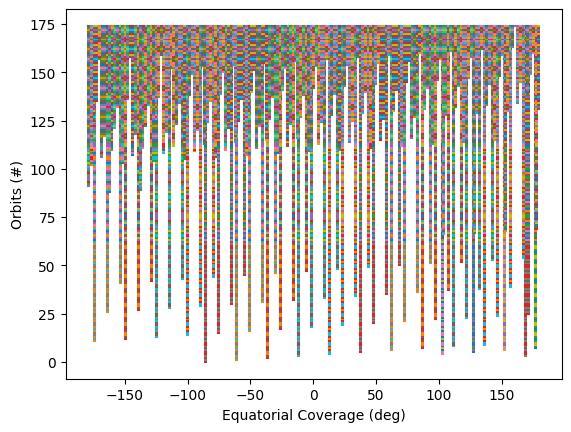

In [5]:
#Orbital parameters
#Vs = satellite velocity m/s Vs= np.sqrt(Ge*Me/(Re+Hs)) 
#Re = Radius of Earth in m
#Hs = Height of Satellite in m
orbit_length = 2*np.pi*(Re+Hs) # [m]
orbit_duration= orbit_length /Vs # [sec]
seconds_per_day =86400 
repeat_cycle = 12 # days
orbits_per_cycle=175
expected_orbit_duration = repeat_cycle*seconds_per_day/orbits_per_cycle
print(f'    Orbit duration={orbit_duration/60.:0.3f} (expected = {expected_orbit_duration/60.:0.3f} min')
### Sanity check on orbit duration based on J2 SunSync
#T = 2*np.pi*np.sqrt((Re/1e3+Hs/1e3)**3/398600.440) #everything in km
#print(f' Sanity check on orbit duration: J2:{T:.3f} (Gravity:{orbit_duration:.3f}) seconds')
orbits_per_day = seconds_per_day / orbit_duration #[count]
orbits_per_repeat_cycle= repeat_cycle * orbits_per_day
#Note, we want 14.5833333 orbits, to get 175.0 total orbits in 12 days. 
print('    Orbits per day= {:0.3f} (expected = 14.5833)'.format(orbits_per_day)) 
### Solve Orbit Altitude for 175./12 orbits/day
fOpD=orbits_per_cycle/repeat_cycle #fOpD=Forced Orbits per day
fHs=(np.sqrt(Ge*Me)*seconds_per_day/(2*np.pi*fOpD))**(2./3)-Re
print(f'    Orbit Altitude = {Hs} (expected={fHs:.1f}) m')
#Let's do a sanity check to see if inclination is close to sun-sync
#circumference_at_equator=2*np.pi*(Re) #need to consider geoid radius... 
#inclination= np.rad2deg(np.arcsin( (circumference_at_equator / (repeat_cycle*seconds_per_day)) / Vs ))
#y= format_print([90-inclination, 90+inclination],1,fmt)
#print('    Inclination (+/-)= {}'.format(y))


#Check if we have enough coverage to get 360 deg in 175 orbits at equator assuming look angles are correctly set. 
angular_coverage=orbits_per_repeat_cycle*np.sum(rx_alpha_far - rx_alpha_nea)
print(f'    Maximum Possible Angular Coverage (deg): {np.rad2deg(angular_coverage)}')
if angular_coverage< 2*np.pi:
    print(f'WARNING: Even with no overlaps results indicate gaps at the equator!')
angular_coverage_ovlp=orbits_per_repeat_cycle*(max(rx_alpha_far) - min(rx_alpha_nea))
print(f'    Maximum Possible Angular Coverage w/Overlap (deg): {np.rad2deg(angular_coverage_ovlp)}')
# Gaps due to Orbit?
equator_crossing=np.r_[0:orbits_per_repeat_cycle]*expected_orbit_duration
longitude_offsets=np.mod(equator_crossing,seconds_per_day)/seconds_per_day * 360 # we can actually use this in the loop instead of re-calc
days=np.floor(equator_crossing/seconds_per_day)
if np.any( np.diff(np.sort(longitude_offsets))> np.rad2deg(max(rx_alpha_far) - min(rx_alpha_nea)) ):
    print(f'WARNING: Gaps due to orbit timing are possible!')
#check deviation from ideal orbit timing
#ideal_timing = every day world rotates total footprint (max(rx_alpha_far) - min(rx_alpha_nea)) away from previous day starting point (LoAN0). 
ideal_daily_offset=np.rad2deg((max(rx_alpha_far) - min(rx_alpha_nea)))
ideal_orbit_duration = ((1+ideal_daily_offset/360.)*seconds_per_day)*repeat_cycle/orbits_per_cycle
iOpD=seconds_per_day/ideal_orbit_duration #iOpD=Ideal Orbits per day
iHs=(np.sqrt(Ge*Me)*seconds_per_day/(2*np.pi*iOpD))**(2./3)-Re
print(f'    Ideal Orbit duration ={ideal_orbit_duration/60.:0.3f} min  & Altitude={iHs:.1f} m')    
                              
#PLOT! 
#Plot Coverage at the equator
t=0 # time [sec]
T=repeat_cycle*seconds_per_day # Total number of seconds in the repeat cycle
fig= plt.figure()
LoAN0=np.array([ 0, 90.51428571, 181.02857143, 269.48571429]) #Initial offsets for Longitude of the Ascending Node << These are based on expected orbit duration
#LoAN0=np.array([0, 8.8940e+01, 1.8249e+02, 2.7125e+02]) # << These are based on orbit duration (which is based on altitude)
#LoAN0=np.array([0, 0, 0, 0]) #Initial offsets for Longitude of the Ascending Node

cluster=Clusters(range=[-180,180], wrap=True)
longitude_offset=[]
for o in tqdm(range(orbits_per_cycle)):
    #t=o*orbit_duration #[sec], based on altitude
    t=o*expected_orbit_duration #[sec], based on expectations for S1 orbit
    
    d=np.floor(t/seconds_per_day) # [days]
    longitude_offset.append(np.mod(t,seconds_per_day)/seconds_per_day * 360)
    LoAN=LoAN0+longitude_offset[-1]  #Longitude of the Ascending Node
    swaths=[ [ wrapToNum(l+n,180), wrapToNum(l+f,180) ] for n,f,l in zip(np.rad2deg(rx_alpha_nea),np.rad2deg(rx_alpha_far),LoAN)]
    cluster.add(swaths)
    xx=np.atleast_2d(np.array(cluster.as_list()).squeeze()).T
    yy=np.atleast_2d(np.array([ [[o,o]]*xx.shape[1] ]).squeeze()).T #orbit plot
    #yy=np.atleast_2d(np.array([ [[d,d]]*xx.shape[1] ]).squeeze()).T  #day plot  
    plt.plot(xx,yy)
plt.xlabel('Equatorial Coverage (deg)')
plt.ylabel('Orbits (#)')
print(f'Total Coverage (All orbits): {np.sum([np.diff(c) for c in cluster.as_list()]):.1f}')
plt.show(); plt.close() 
#plt.figure();
#plt.scatter(longitude_offset, np.r_[0:o+1])

### Derived Parameters: Plots

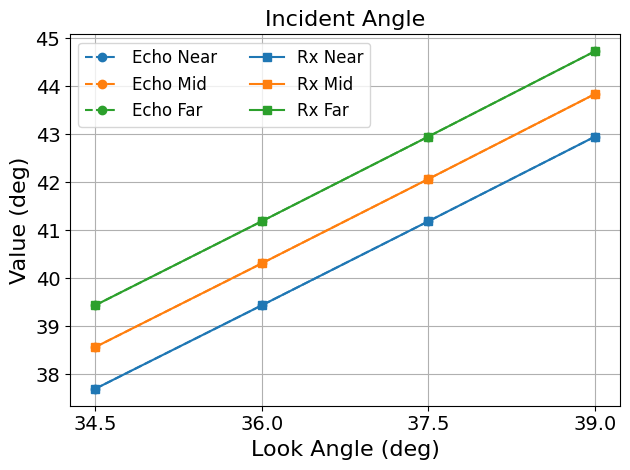

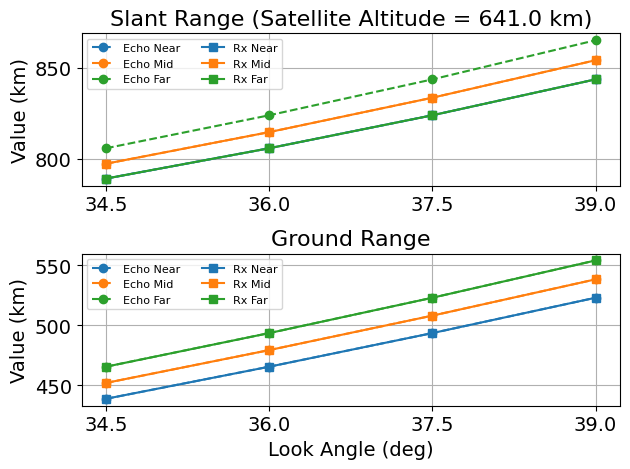

In [6]:
# Plot Incident Angles

fig= plt.figure()
font= 16

plt.plot(theta_lk,echo_inc_nea/onedeg,'o--',color='tab:blue',label='Echo Near')
plt.plot(theta_lk,echo_inc_mid/onedeg,'o--',color='tab:orange',label='Echo Mid')
plt.plot(theta_lk,echo_inc_far/onedeg,'o--',color='tab:green',label='Echo Far')

plt.plot(theta_lk,rx_inc_nea/onedeg,'s-',color='tab:blue',label='Rx Near')
plt.plot(theta_lk,rx_inc_mid/onedeg,'s-',color='tab:orange',label='Rx Mid')
plt.plot(theta_lk,rx_inc_far/onedeg,'s-',color='tab:green',label='Rx Far')

plt.title('Incident Angle', fontsize= font)
plt.ylabel('Value (deg)', fontsize= font)
plt.xlabel('Look Angle (deg)', fontsize= font)

plt.grid(); plt.legend(ncols=2, fontsize= font-4)
plt.xticks(theta_lk)

ax= plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)
plt.tight_layout()
plt.show(); plt.close()

# Plot Slant Range

fig, axs= plt.subplots(2)
font= 16

axs[0].plot(theta_lk,echo_slnt_nea/1e3,'o--',color='tab:blue',label='Echo Near')
axs[0].plot(theta_lk,echo_slnt_mid/1e3,'o--',color='tab:orange',label='Echo Mid')
axs[0].plot(theta_lk,echo_slnt_far/1e3,'o--',color='tab:green',label='Echo Far')

axs[0].plot(theta_lk,rx_slnt_nea/1e3,'s-',color='tab:blue',label='Rx Near')
axs[0].plot(theta_lk,rx_slnt_mid/1e3,'s-',color='tab:orange',label='Rx Mid')
axs[0].plot(theta_lk,rx_slnt_far/1e3,'s-',color='tab:green',label='Rx Far')

axs[0].set_title('Slant Range (Satellite Altitude = {:.1f} km)'.format(Hs/1e3), fontsize= font)
axs[0].set_ylabel('Value (km)', fontsize= font-2)

axs[0].grid(); axs[0].legend(ncols=2, fontsize= font-8)
axs[0].set_xticks(theta_lk)

axs[1].plot(theta_lk,echo_grnd_nea/1e3,'o--',color='tab:blue',label='Echo Near')
axs[1].plot(theta_lk,echo_grnd_mid/1e3,'o--',color='tab:orange',label='Echo Mid')
axs[1].plot(theta_lk,echo_grnd_far/1e3,'o--',color='tab:green',label='Echo Far')

axs[1].plot(theta_lk,rx_grnd_nea/1e3,'s-',color='tab:blue',label='Rx Near')
axs[1].plot(theta_lk,rx_grnd_mid/1e3,'s-',color='tab:orange',label='Rx Mid')
axs[1].plot(theta_lk,rx_grnd_far/1e3,'s-',color='tab:green',label='Rx Far')

axs[1].set_title('Ground Range', fontsize= font)
axs[1].set_ylabel('Value (km)', fontsize= font-2)
axs[1].set_xlabel('Look Angle (deg)', fontsize= font-2)

axs[1].grid(); axs[1].legend(ncols=2, fontsize= font-8)
axs[1].set_xticks(theta_lk)

axs[0].tick_params(axis = 'both', which = 'major', labelsize=font-2)
axs[1].tick_params(axis = 'both', which = 'major', labelsize=font-2)

plt.tight_layout()
plt.show(); plt.close() 


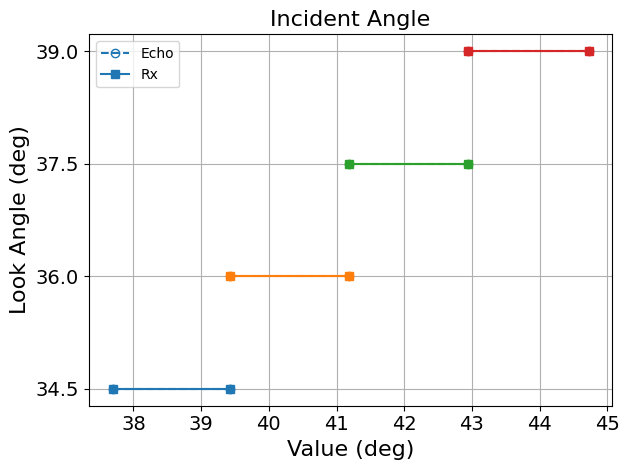

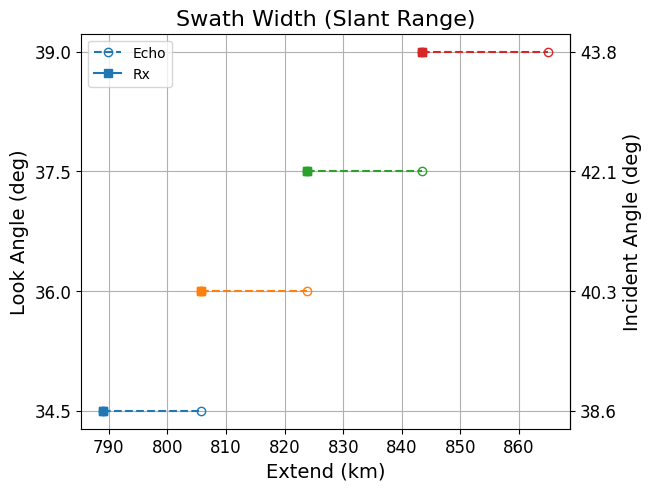

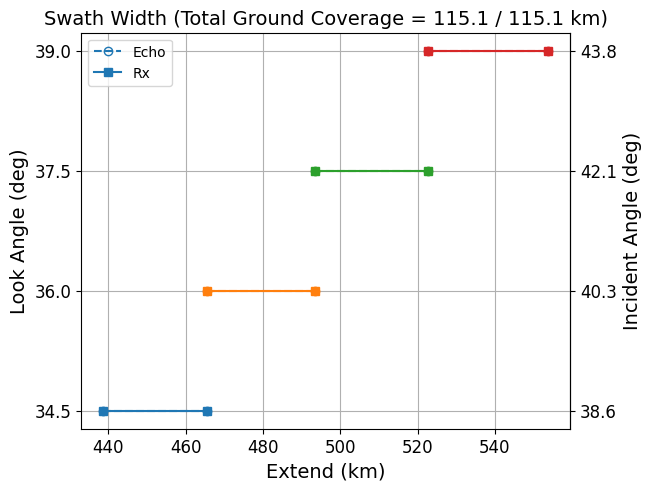

In [7]:
# Plot Incident Angles

fig= plt.figure()
font= 16

lcolors= list(mcolors.TABLEAU_COLORS.keys())

color= []
for ib in range(Nbeams):
    color.append(lcolors[ib])
    
label_echo= 'Echo'
label_rx= 'Rx'

for ib,theta in enumerate(theta_lk):
    x1= echo_inc_nea[ib]/onedeg; x2= echo_inc_far[ib]/onedeg
    y1= theta; y2= theta
    if ib==0:
        plt.plot([x1,x2],[y1,y2],'o--',color=color[ib], markerfacecolor='none', label=label_echo)
    else:
        plt.plot([x1,x2],[y1,y2],'o--',color=color[ib], markerfacecolor='none')
        
for ib,theta in enumerate(theta_lk):
    x1= rx_inc_nea[ib]/onedeg; x2= rx_inc_far[ib]/onedeg
    y1= theta; y2= theta
    if ib==0:
        plt.plot([x1,x2],[y1,y2],'s-',color=color[ib],label=label_rx)
    else:
        plt.plot([x1,x2],[y1,y2],'s-',color=color[ib])
        
plt.title('Incident Angle', fontsize= font)
plt.xlabel('Value (deg)', fontsize= font)
plt.ylabel('Look Angle (deg)', fontsize= font)

plt.grid(); plt.legend()
plt.yticks(theta_lk)

ax= plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)

plt.tight_layout()
plt.show(); plt.close()

# Plot Swath Width (slant)

fig, ax= plt.subplots(layout='constrained')
font= 16

for ib,theta in enumerate(theta_lk):
    x1= echo_slnt_nea[ib]/1e3; x2= echo_slnt_far[ib]/1e3
    y1= theta; y2= theta
    if ib==0:
        plt.plot([x1,x2],[y1,y2],'o--',color=color[ib], markerfacecolor='none',label=label_echo)
    else:
        plt.plot([x1,x2],[y1,y2],'o--',color=color[ib], markerfacecolor='none')

for ib,theta in enumerate(theta_lk):
    x1= rx_slnt_nea[ib]/1e3; x2= rx_slnt_far[ib]/1e3
    y1= theta; y2= theta
    if ib==0:
        plt.plot([x1,x2],[y1,y2],'s-',color=color[ib],label=label_rx)
    else:
        plt.plot([x1,x2],[y1,y2],'s-',color=color[ib])

plt.title('Swath Width (Slant Range)', fontsize= font)
plt.ylabel('Look Angle (deg)', fontsize= font-2)
plt.xlabel('Extend (km)', fontsize= font-2)

plt.grid(); plt.legend()
plt.yticks(theta_lk)

secay= ax.secondary_yaxis('right', functions=(plt_look2inc, plt_inc2look))
secay.set_ylabel(r'Incident Angle (deg)', fontsize= font-2)

ax.tick_params(axis = 'both', which = 'major', labelsize= font-4)
secay.tick_params(labelsize= font-4)

ticks1= ax.get_yticks()
ticks2= plt_look2inc(ticks1)
ax.set_yticks(ticks1)
secay.set_yticks(ticks2)
secay.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

#plt.tight_layout()
plt.show(); plt.close() 

# Plot Swath Width (ground)

fig, ax= plt.subplots(layout='constrained')
font= 16

for ib,theta in enumerate(theta_lk):
    x1= echo_grnd_nea[ib]/1e3; x2= echo_grnd_far[ib]/1e3
    y1= theta; y2= theta
    if ib==0:
        plt.plot([x1,x2],[y1,y2],'o--',color=color[ib], markerfacecolor='none', label=label_echo)
    else:
        plt.plot([x1,x2],[y1,y2],'o--',color=color[ib], markerfacecolor='none')

for ib,theta in enumerate(theta_lk):
    x1= rx_grnd_nea[ib]/1e3; x2= rx_grnd_far[ib]/1e3
    y1= theta; y2= theta
    if ib==0:
        plt.plot([x1,x2],[y1,y2],'s-',color=color[ib],label=label_rx)
    else:
        plt.plot([x1,x2],[y1,y2],'s-',color=color[ib])
    
plt.title('Swath Width (Total Ground Coverage = {:.1f} / {:.1f} km)'.format((rx_grnd_far[-1] - rx_grnd_nea[0])/1e3, (echo_grnd_far[-1] - echo_grnd_nea[0])/1e3), fontsize= font-2)
plt.ylabel('Look Angle (deg)', fontsize= font-2)
plt.xlabel('Extend (km)', fontsize= font-2)

plt.grid(); plt.legend()
plt.yticks(theta_lk)

secay= ax.secondary_yaxis('right', functions=(plt_look2inc, plt_inc2look))
secay.set_ylabel(r'Incident Angle (deg)', fontsize= font-2)

ax.tick_params(axis = 'both', which = 'major', labelsize= font-4)
secay.tick_params(labelsize= font-4)

ticks1= ax.get_yticks()
ticks2= plt_look2inc(ticks1)
ax.set_yticks(ticks1)
secay.set_yticks(ticks2)
secay.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

#plt.tight_layout()
plt.show(); plt.close()

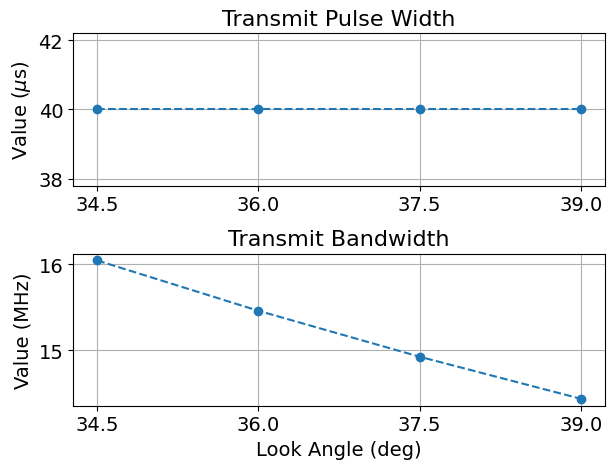

In [8]:
# Plotting PW/BW

fig, axs= plt.subplots(2)
font= 16

tx_pw= np.array([40e-6 for val in theta_lk])
axs[0].plot(theta_lk, tx_pw/1e-6,'o--')
axs[1].plot(theta_lk, tx_bw/1e6,'o--')

axs[0].grid(); axs[1].grid()

axs[0].set_title('Transmit Pulse Width', fontsize= font)
axs[0].set_ylabel(r'Value ($\mu$s)', fontsize= font-2)

axs[1].set_title('Transmit Bandwidth', fontsize= font)
axs[1].set_ylabel('Value (MHz)', fontsize= font-2)
axs[1].set_xlabel('Look Angle (deg)', fontsize= font-2)

axs[0].set_xticks(theta_lk)
axs[1].set_xticks(theta_lk)

axs[0].tick_params(axis = 'both', which = 'major', labelsize=font-2)
axs[1].tick_params(axis = 'both', which = 'major', labelsize=font-2)

plt.tight_layout()
plt.show(); plt.close() 

## 4. PRF Timing & Selection: Equations

A | B
- | - 
<img src="./Pix/SAR02.png" alt="SAR02.png" /> | <img src="./Pix/SAR03.png" alt="SAR03.png" />

<br>

- **Minimum PRF:** The radar transmits *at least* a pulse when the antenna travels half the antenna length

$$ PRF_{min} = 2V_s/L_a \label{eq4-1}\tag{4-1}$$ 

<br>

- **Maximum PRF:** The radar transmits another pulse *after* the time it takes for the signal to travel the swath width, plus the transmit pulse width (for swath coverage) and some guard time (for receive protect)

$$ PRF_{max} = 1/(2\tau_p + \tau_\text{swath} + \tau_{grd}) \label{eq4-3}\tag{4-3}$$ 

where

$$ \tau_\text{swath} = \frac{2W_s}{c} = \frac{2W_g\sin\eta}{c}\label{eq4-2} = 
                        \frac{2\lambda R \tan\eta}{cW_a} \tag{4-2}$$

<br>

<img src="./Pix/PRF-Timing-3.png" alt="SAR-PRF-Timing2.png" /> 

<br>

- **Blind Ranges:** Since a SAR system usually uses the same antenna for both transmit and receive, the receiver is in a "blind range" during the transmit event. The PRF should be set to avoid this "eclipsing" when the returning echo coincides with the transmit event. From the timing diagram above

$$ mP\!R\!I + \tau_p + \tau_{grd} \quad \leq \quad \tau_{near}, \label{eq4-4}\tag{4-4} $$  
$$ \tau_{far} + \tau_{swext} \quad \leq \quad (m+1)P\!R\!I - \tau_{grd}, $$

for \\( m=1,2,3, ...;\\) and \\( \tau_{swext} = \tau_p \\), which is the extended swath width in order to account for the length of the reference function in pulse compression. In other words, the (not allowable) "blind range" is within this timing interval around the transmit event at time \\( m \times \text{PRI} \\)

$$ mP\!R\!I - \tau_{swext} - \tau_{grd} \quad \leq \quad \tau_{blind} \quad \leq \quad mP\!R\!I + \tau_p + \tau_{grd}. \label{eq4-5}\tag{4-5} $$

Eq. (\ref{eq4-5}) is often used in constructing the **"PRF Timing (diamond)" diagram** for the "blind range", which depends only on (1) the simulated \\( \text{PRI} \\), (2) the pulse width \\( \tau_p \\), and (3) the guard time \\( \tau_{grd} \\).

Rearranging Eq. (\ref{eq4-4}) in terms of \\( \text{PRF} = 1/\text{PRI} \\) gives

$$ \frac{m}{\tau_{near} - \tau_p - \tau_{grd}} \quad \leq \quad P\!R\!F \quad \leq \quad \frac{m+1}{\tau_{far}+\tau_p+\tau_{grd}}. \label{eq4-6}\tag{4-6}$$
 
<br>

- **Nadir Returns:** Similarly, the PRF must be seleted such that the nadir return from succeeding pulses is exceluded from the data window. Again, from the timing diagram above (for analogical purpose, the nadir return could be treated as "another transmit event" to be "blinded")

$$ nP\!R\!I + \tau_H + \tau_{H-wid} \quad \leq \quad \tau_{near}, \label{eq4-7}\tag{4-7} $$
$$ \tau_{far} + \tau_{swext} \quad \leq \quad (n+1)P\!R\!I + \tau_H, $$

for \\( n=1,2,3,...\\), and

$$ \tau_H = \frac{2H_s}{c};\quad \tau_{H-wid} \approx 2\tau_p. \label{eq4-8}\tag{4-8}$$

In other words, the (contaminating) "nadir return" is within this timing interval around the nadir return at time \\( (n \times \text{PRI} + \tau_H) \\)

$$ nP\!R\!I + \tau_H  - \tau_{swext} \quad \leq \quad \tau_{nadir} \quad \leq \quad nP\!R\!I + \tau_H + \tau_{H-wid}. \label{eq4-9}\tag{4-9}$$

Again, Eq. (\ref{eq4-9}) is often used in constructing the **"PRF Timing (diamond)" diagram** for the "nadir return", which depends only on (1) the simulated \\( \text{PRI} \\), (2) the width of the nadir return \\( \approx 2\tau_p \\), and (3) the height of the platform \\( h_{plat} \\).

Rearranging Eq. (\ref{eq4-7}) in terms of \\( \text{PRF} = 1/\text{PRI} \\) gives

$$ \frac{n}{\tau_{near} - \tau_{H} - \tau_{H-wid}} \quad \leq \quad PRF \quad \leq \quad \frac{n+1}{\tau_{far} -  \tau_H + \tau_p }. \label{eq4-10}\tag{4-10}$$

<br>

In summary, the table below describes the dependency of the design parameters on the input parameters during the construction of the **"PRF Timing (diamond)" diagram**

| Input Parameter | Design Parameter | Equation |
| --- | --- | ---|
\\( H, L_a \\) | \\( PRF_{min} \\) | Eq. (\ref{eq4-1}) |
\\( W_a, \theta_{look} \\) | \\( PRF_{max} \\) | Eq. (\ref{eq4-3}) |
\\( \tau_p, \tau_{grd} \\) | \\( \tau_{blind} \\) | Eq. (\ref{eq4-5}) |
\\( H, \tau_p \\) | \\( \tau_{nadir} \\) | Eq. (\ref{eq4-9}) |

After that, the radar designers can appropriately choose/adjust the swath boundaries and the corresponding PRF, that would render the imaging region free of the constraints from the  **Blind region and Nadir return**, subject to the **min/max PRF limits**. 


### Reference
1. Curlander, J.C.; McDonough, R.N. *Synthetic Aperture Radar: Systems and Signal Processing*; John Wiley & Sons: New York, NY, USA, 1991.


### PRF Timing & Selection: Code

In [9]:
# Min/Max PRF

fp_min= 2*Vs/La                         # Hz, minimum PRF

tau_swath= 2*echo_swath_slnt/c         # s, (slant) swath time
fp_max= 1/(2*pw+tau_swath+tau_grd)      # Hz, maximum PRF

prf = np.linspace(0.5*fp_min, fp_max[0], 100)
prf = np.linspace(1000, 5000, 100)
pri= 1/prf

# Tx Event

tx_rng_nea= np.array([])
tx_rng_far= np.array([])
tx_lk_nea= np.array([])
tx_lk_far= np.array([])

# Estimate # of PRIs for blind-range simulation

m_rng= (2*Hs/c + pw + tau_grd)/pri
m_min= int(np.ceil(min(m_rng)))
m_max= int(np.ceil(max(m_rng))) + 5 

Np_blind= m_max - m_min

for ip in range(m_min,m_max,1):
    tmp= ip*pri + pw + tau_grd    # blind near
#    tmp= ip*pri - tau_grd         # prf_designer
    rng= tmp*c/2    
    # Make sure rng >= Hs
    if any(rng < Hs):
        rng[rng < Hs]= Hs
    lk= slnt2look(rng,Re,Hs)
    tx_rng_nea= rng if len(tx_rng_nea)==0 else np.vstack((tx_rng_nea,rng)) 
    tx_lk_nea= lk if len(tx_lk_nea)==0 else np.vstack((tx_lk_nea,lk)) 

    tmp= ip*pri - tau_swext - tau_grd    # blind far
#    tmp= ip*pri + pw + tau_grd    # prf_designer
    rng= tmp*c/2    
    # Make sure rng >= Hs
    if any(rng < Hs):
        rng[rng < Hs]= Hs
    lk= slnt2look(rng,Re,Hs)
    tx_rng_far= rng if len(tx_rng_far)==0 else np.vstack((tx_rng_far,rng)) 
    tx_lk_far= lk if len(tx_lk_far)==0 else np.vstack((tx_lk_far,lk)) 

# Nadir Return

tau_nadir= 2*Hs/c

nd_rng_nea= np.array([])
nd_rng_far= np.array([])
nd_lk_nea= np.array([])
nd_lk_far= np.array([])

Np_nadir= 10

for ip in range(Np_nadir):

    tmp= ip*pri + tau_nadir + pw_nadir    # nadir near
#    tmp= ip*pri + tau_nadir               # prf_designer
    rng= tmp*c/2    
    # Make sure rng >= Hs
    if any(rng < Hs):
        rng[rng < Hs]= Hs
    lk= slnt2look(rng,Re,Hs)
    nd_rng_nea= rng if len(nd_rng_nea)==0 else np.vstack((nd_rng_nea,rng)) 
    nd_lk_nea= lk if len(nd_lk_nea)==0 else np.vstack((nd_lk_nea,lk)) 
    
    tmp= ip*pri + tau_nadir - tau_swext    # nadir far
#    tmp= ip*pri + tau_nadir + pw_nadir    # prf_designer
    rng= tmp*c/2    
    # Make sure rng >= Hs
    if any(rng < Hs):
        rng[rng < Hs]= Hs
    lk= slnt2look(rng,Re,Hs)
    nd_rng_far= rng if len(nd_rng_far)==0 else np.vstack((nd_rng_far,rng)) 
    nd_lk_far= lk if len(nd_lk_far)==0 else np.vstack((nd_lk_far,lk)) 
    
y= format_print(tau_swath,1e-6,fmt)
print('\nPulse Width, Swath Time, Guard Time= {:.1f}, {}, {:.1f} us'.format(pw*1e6, y, tau_grd*1e6))

y= format_print(fp_max,1,fmt)
print('Min/Max PRF= {:.1f}/{} Hz'.format(fp_min,y))


Pulse Width, Swath Time, Guard Time= 33.4, [110.9, 120.6, 131.3, 143.2], 5.0 us
Min/Max PRF= 3014.0/[5472.0, 5196.7, 4923.4, 4652.0] Hz


### PRF Timing & Selection: Plots

C:\Users\cppayne\AppData\Local\Temp\1\ipykernel_17816\641298683.py:117: RuntimeWarning: divide by zero encountered in divide
  return 1e6/pri


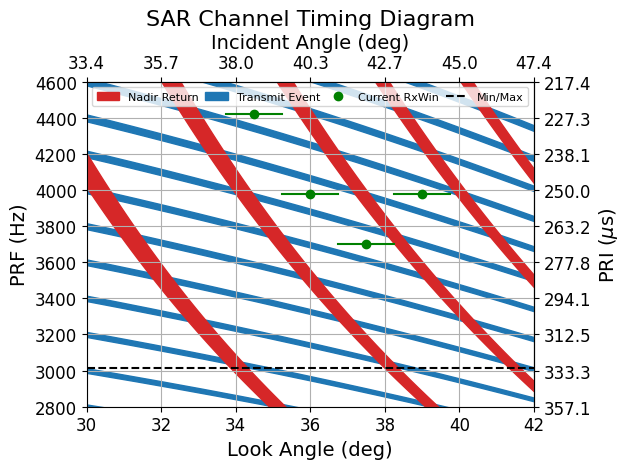

In [10]:
# Figure's orientation  

#xaxis= 'PRF'    # ['PRF', "Look"]
xaxis= 'Look'    # ['PRF', "Look"]

# Plotting

fig, ax= plt.subplots()
font= 16

# Current selection

for ib in range(Nbeams):
    prf_s= PRF_l[ib]
    if xaxis=='PRF':
        h_s, = ax.plot(PRF_l[ib],rx_look_mid[ib]/onedeg,'og')
        ax.plot([prf_s, prf_s],[rx_look_nea[ib]/onedeg, rx_look_far[ib]/onedeg],'-g')
    else:
        h_s, = ax.plot(rx_look_mid[ib]/onedeg, PRF_l[ib], 'og')
        ax.plot([rx_look_nea[ib]/onedeg, rx_look_far[ib]/onedeg], [prf_s, prf_s], '-g')
        
# Min limit

if xaxis=='PRF':
    h_min, = ax.plot([fp_min, fp_min], [np.nanmin(tx_lk_nea/onedeg), np.nanmax(tx_lk_nea/onedeg)], '--k')
else:
    h_min, = ax.plot([np.nanmin(tx_lk_nea/onedeg), np.nanmax(tx_lk_nea/onedeg)], [fp_min, fp_min], '--k')

# Max limit

for ib in range(Nbeams):
    max_look = np.arctan(c*Wa/(2*wavelng*rx_slnt_mid[ib]*prf))
    if xaxis=='PRF':
        h_max, = ax.plot(prf, max_look/onedeg, '--k')
    else:
        h_max, = ax.plot(max_look/onedeg, prf, '--k')

# Tx event

(nr,nc)= tx_lk_nea.shape
for ip in range(nr):
    if xaxis=='PRF':
         h_tx = ax.fill_between(prf,tx_lk_nea[ip,:]/onedeg,tx_lk_far[ip,:]/onedeg,color='tab:blue')
    else:
         h_tx = ax.fill_betweenx(prf,tx_lk_nea[ip,:]/onedeg,tx_lk_far[ip,:]/onedeg,color='tab:blue')

# Nadir event

(nr,nc)= nd_lk_nea.shape
for ip in range(nr):
    if xaxis=='PRF':
        h_nd = ax.fill_between(prf,nd_lk_nea[ip,:]/onedeg,nd_lk_far[ip,:]/onedeg,color='tab:red')
    else:
        h_nd = ax.fill_betweenx(prf,nd_lk_nea[ip,:]/onedeg,nd_lk_far[ip,:]/onedeg,color='tab:red')
        
ax.grid()
if xaxis=='PRF':
#    plt.xlim([fp_min-100, np.mean(fp_max)+100])
    plt.ylim([min(theta_lk)-3, max(theta_lk)+3])
else:
#    plt.ylim([fp_min-100, np.mean(fp_max)+100])
    #plt.ylim([1800, 3600])
    plt.ylim([2800, 4600]) 
    plt.xlim([min(theta_lk)-3, max(theta_lk)+3])
    
ax.set_title('SAR Channel Timing Diagram', fontsize= font)
if xaxis=='PRF':
    ax.set_xlabel('PRF (Hz)', fontsize= font-2)
    ax.set_ylabel('Look Angle (deg)', fontsize= font-2)
else:
    ax.set_ylabel('PRF (Hz)', fontsize= font-2)
    ax.set_xlabel('Look Angle (deg)', fontsize= font-2)
    
labels = ['Nadir Return', 'Transmit Event', 'Current RxWin', 'Min/Max']
ax.legend((h_nd, h_tx, h_s, h_min), labels,
          bbox_to_anchor=(0, 0.92, 1, .08),
          ncol=4, numpoints=1,
          fontsize=8, mode='expand')

secax= ax.secondary_xaxis('top', functions=(plt_look2inc, plt_inc2look))
secax.set_xlabel(r'Incident Angle (deg)', fontsize= font-2)

secay= ax.secondary_yaxis('right', functions=(plt_prf2pri, plt_pri2prf))
secay.set_ylabel(r'PRI ($\mu$s)', fontsize= font-2)

ax.tick_params(axis = 'both', which = 'major', labelsize= font-4)
secax.tick_params(labelsize= font-4)
secay.tick_params(labelsize= font-4)

ticks1= ax.get_xticks()
ticks2= plt_look2inc(ticks1)
ax.set_xticks(ticks1)
secax.set_xticks(ticks2)
secax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ticks1= ax.get_yticks()
ticks2= plt_prf2pri(ticks1)
ax.set_yticks(ticks1)
secay.set_yticks(ticks2)
secay.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.tight_layout()
plt.show(); plt.close()

### Plot Rangeline Timing: Beam #1

Beam #1 (look = 34.5 deg):
    PRI= 226.2 usec (PRF = 4420.0 Hz)
    Time of 1st Echo: 5260.4 us
    Number of Pulses in the Air (nadir): 24 (19)

Timing near 1st Echo (slant time, us):
        Tx Event: 5203.6 us
        Nadir Return: 5404.6 us
        Echo  [near -- far]: [5260.4 -- 5371.4]
        RxWin [near -- far]: [5260.4 -- 5260.4]

Timing near 1st Echo (ground range, km):
        Echo  [near -- far]: [438.7 -- 465.4]
        RxWin [near -- far]: [438.7 -- 465.4]


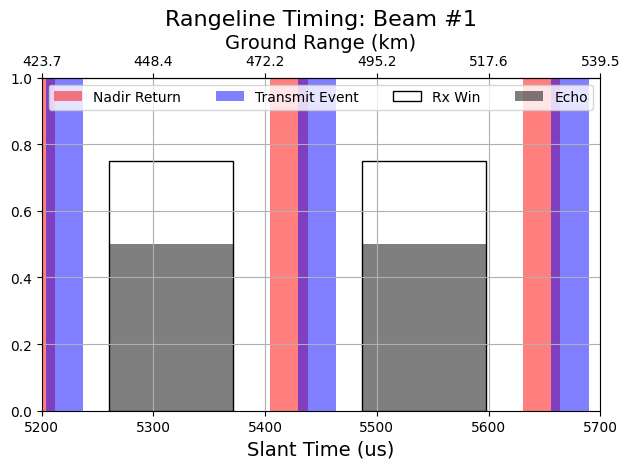

In [11]:
# Beam 1

for ib in range(Nbeams):

    if ib not in [0]:
        continue
    
    PRF= PRF_l[ib]
    PRI= 1/PRF
    tp= pw      # transmit pulse width
    tn= pw_nadir    # nadir pulse width

    echo_delay_near = 2*echo_slnt_nea[ib]/c
    echo_delay_far = 2*echo_slnt_far[ib]/c
    nPIA= np.ceil(echo_delay_near*PRF).astype(int)     # of pulses in the air

    tx_delay_near = (nPIA-1)*PRI
    nadir_delay_near= 2*Hs/c
    nPIA_nadir= np.ceil(nadir_delay_near*PRF).astype(int)     # of pulses in the air

    rx_window_length = plt_dist2time(rx_swath_slnt[ib]/1e3)*1e-6
    rx_delay_near= 2*rx_slnt_nea[ib]/c
    rx_delay_far= 2*rx_slnt_far[ib]/c
    rx0 = rx_delay_near
    
    print('Beam #{} (look = {} deg):'.format(ib+1, theta_lk[ib]))
    print('    PRI= {:.1f} usec (PRF = {:.1f} Hz)'.format(PRI*1e6, PRF))
    print('    Time of 1st Echo: {:.1f} us'.format(echo_delay_near*1e6))
    print('    Number of Pulses in the Air (nadir): {} ({})'.format(nPIA,nPIA_nadir))

    print('\nTiming near 1st Echo (slant time, us):')    
    print('        Tx Event: {:.1f} us'.format(tx_delay_near*1e6))
    print('        Nadir Return: {:.1f} us'.format((nadir_delay_near+(nPIA-nPIA_nadir)*PRI)*1e6))
    print('        Echo  [near -- far]: [{:.1f} -- {:.1f}]'.format(echo_delay_near*1e6, echo_delay_far*1e6))
    print('        RxWin [near -- far]: [{:.1f} -- {:.1f}]'.format(rx_delay_near*1e6, rx_delay_far*1e6))

    print('\nTiming near 1st Echo (ground range, km):')    
    print('        Echo  [near -- far]: [{:.1f} -- {:.1f}]'.format(echo_grnd_nea[ib]/1e3, echo_grnd_far[ib]/1e3))
    print('        RxWin [near -- far]: [{:.1f} -- {:.1f}]'.format(rx_grnd_nea[ib]/1e3, rx_grnd_far[ib]/1e3))
    
    # Plotting
    
    fig, ax = plt.subplots()
    font= 16
    ax.cla()

    # Pulse Time-Domain
    # =================
    time_start = min(tx_delay_near, nadir_delay_near+(nPIA-nPIA_nadir)*PRI)
    time_stop = (nPIA+1)*PRI + tp

    ax.set_xlim((time_start/1e-6, time_stop/1e-6))
    M_span = int(np.ceil((time_stop-time_start)/PRI))

    # Nadir pulses
    for M in range(M_span):
        h_nadir = Rectangle([(M*PRI+nadir_delay_near+(nPIA-nPIA_nadir-1)*PRI)/1e-6, 0], tn/1e-6, 1,
                        alpha=0.5,
                        facecolor='r')
        ax.add_artist(h_nadir)

    # Tx Event Pulses
    for M in range(M_span):
        h_tx = Rectangle([(M*PRI+tx_delay_near)/1e-6, 0], tp/1e-6, 1,
                        alpha=0.5,
                        facecolor='b')
        ax.add_artist(h_tx)

    # Rx Window
    if rx_window_length < 0:
        rx_window_length += PRI
    for M in range(M_span):
        h_win = Rectangle([(M*PRI+rx_delay_near)/1e-6, 0], 
                          rx_window_length/1e-6, 
                          0.75,
                          linewidth=1, 
                          edgecolor='k',
                          facecolor='none')
        ax.add_artist(h_win)

    # Echo Returns
    echo_length = echo_delay_far - echo_delay_near
    for M in range(M_span):
        h_echo = Rectangle([(M*PRI+echo_delay_near)/1e-6, 0], echo_length/1e-6, 0.5,
                        alpha=0.5,
                        facecolor='k')
        # h_echo = FancyBboxPatch([(M*PRI+echo_delay_near)/1e-6, 0], echo_length/1e-6, 0.5,
                        # boxstyle='round,rounding_size=10',
                        # facecolor='k')
        ax.add_artist(h_echo)

    ax.set_title('Rangeline Timing: Beam #{}'.format(ib+1), fontsize=font)
    ax.set_xlabel('Slant Time (us)', fontsize=font-2)
    fig.canvas.draw()
    ax.grid()

    labels = ['Nadir Return', 'Transmit Event', 'Rx Win', 'Echo']
    ax.legend((h_nadir, h_tx, h_win, h_echo), labels,
              bbox_to_anchor=(0, 0.92, 1, .08),
              ncol=4, numpoints=1,
              fontsize=10, mode='expand')

    secax= ax.secondary_xaxis('top', functions=(plt_slnt2grnd, plt_grnd2slnt))
    secax.set_xlabel(r'Ground Range (km)', fontsize= font-2)
    
    ticks1= ax.get_xticks()
    ticks2= plt_slnt2grnd(ticks1)
    ax.set_xticks(ticks1)
    secax.set_xticks(ticks2)
    secax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    plt.tight_layout()
    plt.show(); plt.close()

### Plot Rangeline Timing: Beam #2

Beam #2 (look = 36.0 deg):
    PRI= 251.3 usec (PRF = 3980.0 Hz)
    Time of 1st Echo: 5371.4 us
    Number of Pulses in the Air (nadir): 22 (18)

Timing near 1st Echo (slant time, us):
        Tx Event: 5276.4 us
        Nadir Return: 5278.4 us
        Echo  [near -- far]: [5371.4 -- 5492.0]
        RxWin [near -- far]: [5371.4 -- 5371.4]

Timing near 1st Echo (ground range, km):
        Echo  [near -- far]: [465.4 -- 493.4]
        RxWin [near -- far]: [465.4 -- 493.4]


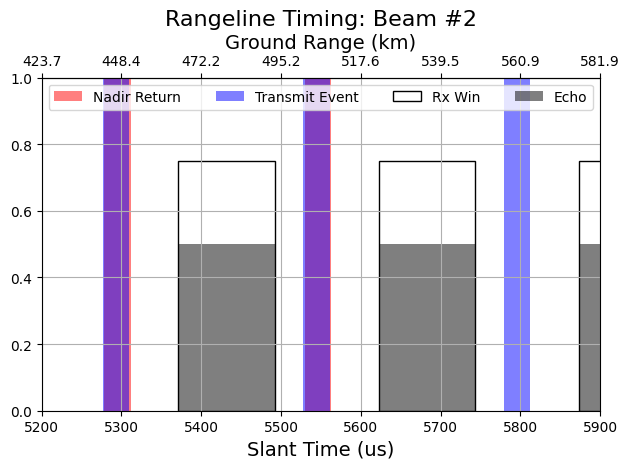

In [12]:
# Beam 1

for ib in range(Nbeams):

    if ib not in [1]:
        continue
    
    PRF= PRF_l[ib]
    PRI= 1/PRF
    tp= pw      # transmit pulse width
    tn= pw_nadir    # nadir pulse width

    echo_delay_near = 2*echo_slnt_nea[ib]/c
    echo_delay_far = 2*echo_slnt_far[ib]/c
    nPIA= np.ceil(echo_delay_near*PRF).astype(int)     # of pulses in the air

    tx_delay_near = (nPIA-1)*PRI
    nadir_delay_near= 2*Hs/c
    nPIA_nadir= np.ceil(nadir_delay_near*PRF).astype(int)     # of pulses in the air

    rx_window_length = plt_dist2time(rx_swath_slnt[ib]/1e3)*1e-6
    rx_delay_near= 2*rx_slnt_nea[ib]/c
    rx_delay_far= 2*rx_slnt_far[ib]/c
    rx0 = rx_delay_near
    
    print('Beam #{} (look = {} deg):'.format(ib+1, theta_lk[ib]))
    print('    PRI= {:.1f} usec (PRF = {:.1f} Hz)'.format(PRI*1e6, PRF))
    print('    Time of 1st Echo: {:.1f} us'.format(echo_delay_near*1e6))
    print('    Number of Pulses in the Air (nadir): {} ({})'.format(nPIA,nPIA_nadir))

    print('\nTiming near 1st Echo (slant time, us):')    
    print('        Tx Event: {:.1f} us'.format(tx_delay_near*1e6))
    print('        Nadir Return: {:.1f} us'.format((nadir_delay_near+(nPIA-nPIA_nadir)*PRI)*1e6))
    print('        Echo  [near -- far]: [{:.1f} -- {:.1f}]'.format(echo_delay_near*1e6, echo_delay_far*1e6))
    print('        RxWin [near -- far]: [{:.1f} -- {:.1f}]'.format(rx_delay_near*1e6, rx_delay_far*1e6))

    print('\nTiming near 1st Echo (ground range, km):')    
    print('        Echo  [near -- far]: [{:.1f} -- {:.1f}]'.format(echo_grnd_nea[ib]/1e3, echo_grnd_far[ib]/1e3))
    print('        RxWin [near -- far]: [{:.1f} -- {:.1f}]'.format(rx_grnd_nea[ib]/1e3, rx_grnd_far[ib]/1e3))
    
    # Plotting
    
    fig, ax = plt.subplots()
    font= 16
    ax.cla()

    # Pulse Time-Domain
    # =================
    time_start = min(tx_delay_near, nadir_delay_near+(nPIA-nPIA_nadir)*PRI)
    time_stop = (nPIA+1)*PRI + tp

    ax.set_xlim((time_start/1e-6, time_stop/1e-6))
    M_span = int(np.ceil((time_stop-time_start)/PRI))

    # Nadir pulses
    for M in range(M_span):
        h_nadir = Rectangle([(M*PRI+nadir_delay_near+(nPIA-nPIA_nadir-1)*PRI)/1e-6, 0], tn/1e-6, 1,
                        alpha=0.5,
                        facecolor='r')
        ax.add_artist(h_nadir)

    # Tx Event Pulses
    for M in range(M_span):
        h_tx = Rectangle([(M*PRI+tx_delay_near)/1e-6, 0], tp/1e-6, 1,
                        alpha=0.5,
                        facecolor='b')
        ax.add_artist(h_tx)

    # Rx Window
    if rx_window_length < 0:
        rx_window_length += PRI
    for M in range(M_span):
        h_win = Rectangle([(M*PRI+rx_delay_near)/1e-6, 0], 
                          rx_window_length/1e-6, 
                          0.75,
                          linewidth=1, 
                          edgecolor='k',
                          facecolor='none')
        ax.add_artist(h_win)

    # Echo Returns
    echo_length = echo_delay_far - echo_delay_near
    for M in range(M_span):
        h_echo = Rectangle([(M*PRI+echo_delay_near)/1e-6, 0], echo_length/1e-6, 0.5,
                        alpha=0.5,
                        facecolor='k')
        # h_echo = FancyBboxPatch([(M*PRI+echo_delay_near)/1e-6, 0], echo_length/1e-6, 0.5,
                        # boxstyle='round,rounding_size=10',
                        # facecolor='k')
        ax.add_artist(h_echo)

    ax.set_title('Rangeline Timing: Beam #{}'.format(ib+1), fontsize=font)
    ax.set_xlabel('Slant Time (us)', fontsize=font-2)
    fig.canvas.draw()
    ax.grid()

    labels = ['Nadir Return', 'Transmit Event', 'Rx Win', 'Echo']
    ax.legend((h_nadir, h_tx, h_win, h_echo), labels,
              bbox_to_anchor=(0, 0.92, 1, .08),
              ncol=4, numpoints=1,
              fontsize=10, mode='expand')

    secax= ax.secondary_xaxis('top', functions=(plt_slnt2grnd, plt_grnd2slnt))
    secax.set_xlabel(r'Ground Range (km)', fontsize= font-2)
    
    ticks1= ax.get_xticks()
    ticks2= plt_slnt2grnd(ticks1)
    ax.set_xticks(ticks1)
    secax.set_xticks(ticks2)
    secax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    plt.tight_layout()
    plt.show(); plt.close()

### Plot Rangeline Timing: Beam #3

Beam #3 (look = 37.5 deg):
    PRI= 270.3 usec (PRF = 3700.0 Hz)
    Time of 1st Echo: 5492.0 us
    Number of Pulses in the Air (nadir): 21 (16)

Timing near 1st Echo (slant time, us):
        Tx Event: 5405.4 us
        Nadir Return: 5624.7 us
        Echo  [near -- far]: [5492.0 -- 5623.3]
        RxWin [near -- far]: [5492.0 -- 5492.0]

Timing near 1st Echo (ground range, km):
        Echo  [near -- far]: [493.4 -- 522.8]
        RxWin [near -- far]: [493.4 -- 522.8]


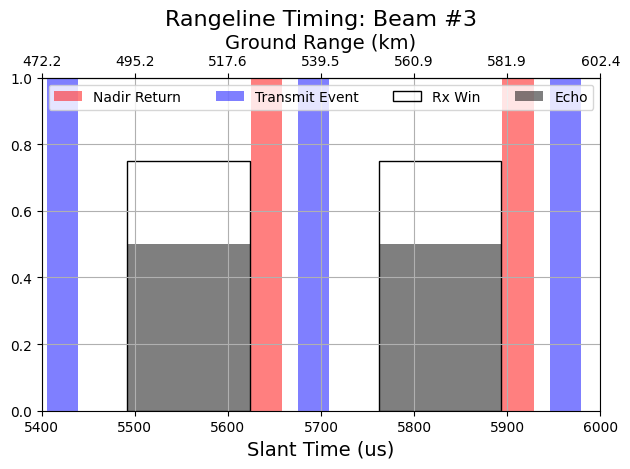

In [13]:
# Beam 1

for ib in range(Nbeams):

    if ib not in [2]:
        continue
    
    PRF= PRF_l[ib]
    PRI= 1/PRF
    tp= pw      # transmit pulse width
    tn= pw_nadir    # nadir pulse width

    echo_delay_near = 2*echo_slnt_nea[ib]/c
    echo_delay_far = 2*echo_slnt_far[ib]/c
    nPIA= np.ceil(echo_delay_near*PRF).astype(int)     # of pulses in the air

    tx_delay_near = (nPIA-1)*PRI
    nadir_delay_near= 2*Hs/c
    nPIA_nadir= np.ceil(nadir_delay_near*PRF).astype(int)     # of pulses in the air

    rx_window_length = plt_dist2time(rx_swath_slnt[ib]/1e3)*1e-6
    rx_delay_near= 2*rx_slnt_nea[ib]/c
    rx_delay_far= 2*rx_slnt_far[ib]/c
    rx0 = rx_delay_near
    
    print('Beam #{} (look = {} deg):'.format(ib+1, theta_lk[ib]))
    print('    PRI= {:.1f} usec (PRF = {:.1f} Hz)'.format(PRI*1e6, PRF))
    print('    Time of 1st Echo: {:.1f} us'.format(echo_delay_near*1e6))
    print('    Number of Pulses in the Air (nadir): {} ({})'.format(nPIA,nPIA_nadir))

    print('\nTiming near 1st Echo (slant time, us):')    
    print('        Tx Event: {:.1f} us'.format(tx_delay_near*1e6))
    print('        Nadir Return: {:.1f} us'.format((nadir_delay_near+(nPIA-nPIA_nadir)*PRI)*1e6))
    print('        Echo  [near -- far]: [{:.1f} -- {:.1f}]'.format(echo_delay_near*1e6, echo_delay_far*1e6))
    print('        RxWin [near -- far]: [{:.1f} -- {:.1f}]'.format(rx_delay_near*1e6, rx_delay_far*1e6))

    print('\nTiming near 1st Echo (ground range, km):')    
    print('        Echo  [near -- far]: [{:.1f} -- {:.1f}]'.format(echo_grnd_nea[ib]/1e3, echo_grnd_far[ib]/1e3))
    print('        RxWin [near -- far]: [{:.1f} -- {:.1f}]'.format(rx_grnd_nea[ib]/1e3, rx_grnd_far[ib]/1e3))
    
    # Plotting
    
    fig, ax = plt.subplots()
    font= 16
    ax.cla()

    # Pulse Time-Domain
    # =================
    time_start = min(tx_delay_near, nadir_delay_near+(nPIA-nPIA_nadir)*PRI)
    time_stop = (nPIA+1)*PRI + tp

    ax.set_xlim((time_start/1e-6, time_stop/1e-6))
    M_span = int(np.ceil((time_stop-time_start)/PRI))

    # Nadir pulses
    for M in range(M_span):
        h_nadir = Rectangle([(M*PRI+nadir_delay_near+(nPIA-nPIA_nadir-1)*PRI)/1e-6, 0], tn/1e-6, 1,
                        alpha=0.5,
                        facecolor='r')
        ax.add_artist(h_nadir)

    # Tx Event Pulses
    for M in range(M_span):
        h_tx = Rectangle([(M*PRI+tx_delay_near)/1e-6, 0], tp/1e-6, 1,
                        alpha=0.5,
                        facecolor='b')
        ax.add_artist(h_tx)

    # Rx Window
    if rx_window_length < 0:
        rx_window_length += PRI
    for M in range(M_span):
        h_win = Rectangle([(M*PRI+rx_delay_near)/1e-6, 0], 
                          rx_window_length/1e-6, 
                          0.75,
                          linewidth=1, 
                          edgecolor='k',
                          facecolor='none')
        ax.add_artist(h_win)

    # Echo Returns
    echo_length = echo_delay_far - echo_delay_near
    for M in range(M_span):
        h_echo = Rectangle([(M*PRI+echo_delay_near)/1e-6, 0], echo_length/1e-6, 0.5,
                        alpha=0.5,
                        facecolor='k')
        # h_echo = FancyBboxPatch([(M*PRI+echo_delay_near)/1e-6, 0], echo_length/1e-6, 0.5,
                        # boxstyle='round,rounding_size=10',
                        # facecolor='k')
        ax.add_artist(h_echo)

    ax.set_title('Rangeline Timing: Beam #{}'.format(ib+1), fontsize=font)
    ax.set_xlabel('Slant Time (us)', fontsize=font-2)
    fig.canvas.draw()
    ax.grid()

    labels = ['Nadir Return', 'Transmit Event', 'Rx Win', 'Echo']
    ax.legend((h_nadir, h_tx, h_win, h_echo), labels,
              bbox_to_anchor=(0, 0.92, 1, .08),
              ncol=4, numpoints=1,
              fontsize=10, mode='expand')

    secax= ax.secondary_xaxis('top', functions=(plt_slnt2grnd, plt_grnd2slnt))
    secax.set_xlabel(r'Ground Range (km)', fontsize= font-2)
    
    ticks1= ax.get_xticks()
    ticks2= plt_slnt2grnd(ticks1)
    ax.set_xticks(ticks1)
    secax.set_xticks(ticks2)
    secax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    plt.tight_layout()
    plt.show(); plt.close()

### Plot Rangeline Timing: Beam #4

Beam #4 (look = 39.0 deg):
    PRI= 251.3 usec (PRF = 3980.0 Hz)
    Time of 1st Echo: 5623.3 us
    Number of Pulses in the Air (nadir): 23 (18)

Timing near 1st Echo (slant time, us):
        Tx Event: 5527.6 us
        Nadir Return: 5529.6 us
        Echo  [near -- far]: [5623.3 -- 5766.5]
        RxWin [near -- far]: [5623.3 -- 5623.3]

Timing near 1st Echo (ground range, km):
        Echo  [near -- far]: [522.8 -- 553.8]
        RxWin [near -- far]: [522.8 -- 553.8]


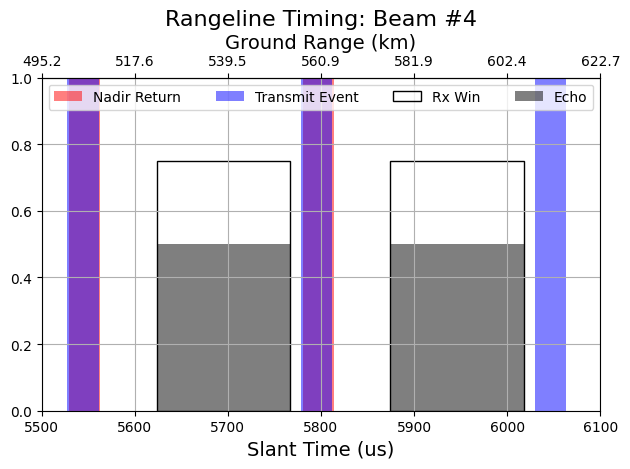

In [14]:
# Beam 1

for ib in range(Nbeams):

    if ib not in [3]:
        continue
    
    PRF= PRF_l[ib]
    PRI= 1/PRF
    tp= pw      # transmit pulse width
    tn= pw_nadir    # nadir pulse width

    echo_delay_near = 2*echo_slnt_nea[ib]/c
    echo_delay_far = 2*echo_slnt_far[ib]/c
    nPIA= np.ceil(echo_delay_near*PRF).astype(int)     # of pulses in the air

    tx_delay_near = (nPIA-1)*PRI
    nadir_delay_near= 2*Hs/c
    nPIA_nadir= np.ceil(nadir_delay_near*PRF).astype(int)     # of pulses in the air

    rx_window_length = plt_dist2time(rx_swath_slnt[ib]/1e3)*1e-6
    rx_delay_near= 2*rx_slnt_nea[ib]/c
    rx_delay_far= 2*rx_slnt_far[ib]/c
    rx0 = rx_delay_near
    
    print('Beam #{} (look = {} deg):'.format(ib+1, theta_lk[ib]))
    print('    PRI= {:.1f} usec (PRF = {:.1f} Hz)'.format(PRI*1e6, PRF))
    print('    Time of 1st Echo: {:.1f} us'.format(echo_delay_near*1e6))
    print('    Number of Pulses in the Air (nadir): {} ({})'.format(nPIA,nPIA_nadir))

    print('\nTiming near 1st Echo (slant time, us):')    
    print('        Tx Event: {:.1f} us'.format(tx_delay_near*1e6))
    print('        Nadir Return: {:.1f} us'.format((nadir_delay_near+(nPIA-nPIA_nadir)*PRI)*1e6))
    print('        Echo  [near -- far]: [{:.1f} -- {:.1f}]'.format(echo_delay_near*1e6, echo_delay_far*1e6))
    print('        RxWin [near -- far]: [{:.1f} -- {:.1f}]'.format(rx_delay_near*1e6, rx_delay_far*1e6))

    print('\nTiming near 1st Echo (ground range, km):')    
    print('        Echo  [near -- far]: [{:.1f} -- {:.1f}]'.format(echo_grnd_nea[ib]/1e3, echo_grnd_far[ib]/1e3))
    print('        RxWin [near -- far]: [{:.1f} -- {:.1f}]'.format(rx_grnd_nea[ib]/1e3, rx_grnd_far[ib]/1e3))
    
    # Plotting
    
    fig, ax = plt.subplots()
    font= 16
    ax.cla()

    # Pulse Time-Domain
    # =================
    time_start = min(tx_delay_near, nadir_delay_near+(nPIA-nPIA_nadir)*PRI)
    time_stop = (nPIA+1)*PRI + tp

    ax.set_xlim((time_start/1e-6, time_stop/1e-6))
    M_span = int(np.ceil((time_stop-time_start)/PRI))

    # Nadir pulses
    for M in range(M_span):
        h_nadir = Rectangle([(M*PRI+nadir_delay_near+(nPIA-nPIA_nadir-1)*PRI)/1e-6, 0], tn/1e-6, 1,
                        alpha=0.5,
                        facecolor='r')
        ax.add_artist(h_nadir)

    # Tx Event Pulses
    for M in range(M_span):
        h_tx = Rectangle([(M*PRI+tx_delay_near)/1e-6, 0], tp/1e-6, 1,
                        alpha=0.5,
                        facecolor='b')
        ax.add_artist(h_tx)

    # Rx Window
    if rx_window_length < 0:
        rx_window_length += PRI
    for M in range(M_span):
        h_win = Rectangle([(M*PRI+rx_delay_near)/1e-6, 0], 
                          rx_window_length/1e-6, 
                          0.75,
                          linewidth=1, 
                          edgecolor='k',
                          facecolor='none')
        ax.add_artist(h_win)

    # Echo Returns
    echo_length = echo_delay_far - echo_delay_near
    for M in range(M_span):
        h_echo = Rectangle([(M*PRI+echo_delay_near)/1e-6, 0], echo_length/1e-6, 0.5,
                        alpha=0.5,
                        facecolor='k')
        # h_echo = FancyBboxPatch([(M*PRI+echo_delay_near)/1e-6, 0], echo_length/1e-6, 0.5,
                        # boxstyle='round,rounding_size=10',
                        # facecolor='k')
        ax.add_artist(h_echo)

    ax.set_title('Rangeline Timing: Beam #{}'.format(ib+1), fontsize=font)
    ax.set_xlabel('Slant Time (us)', fontsize=font-2)
    fig.canvas.draw()
    ax.grid()

    labels = ['Nadir Return', 'Transmit Event', 'Rx Win', 'Echo']
    ax.legend((h_nadir, h_tx, h_win, h_echo), labels,
              bbox_to_anchor=(0, 0.92, 1, .08),
              ncol=4, numpoints=1,
              fontsize=10, mode='expand')

    secax= ax.secondary_xaxis('top', functions=(plt_slnt2grnd, plt_grnd2slnt))
    secax.set_xlabel(r'Ground Range (km)', fontsize= font-2)
    
    ticks1= ax.get_xticks()
    ticks2= plt_slnt2grnd(ticks1)
    ax.set_xticks(ticks1)
    secax.set_xticks(ticks2)
    secax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    plt.tight_layout()
    plt.show(); plt.close()

## 5. Antenna Pattern: Equations

- Antenna's rectangular aperture

![SAR-rect-aperture.png](./Pix/SAR-rect-aperture.png)

- **Ideal Rectangular Antenna:** With \\( (\theta,\phi)\\) denoting the spherical angles at the antenna reference, the far-field radiation pattern of a rectangular antenna \\( (L_a,W_a) \\) is *separable* and given by

$$ f(\theta,\phi)= \text{sinc}(\pi v_x) \text{sinc}(\pi v_y);  \label{eq5-1}\tag{5-1}$$

where

$$ v_x= \frac{L_a}{\lambda} \sin\theta \cos\phi; \quad v_y= \frac{W_a}{\lambda} \sin\theta \sin\phi \label{eq5-2}\tag{5-2}$$

- Along the two principal cuts \\( \phi = (0^0, 90^0) \\), corresponding to the *xz-* and *yz-plane*, respectively

$$\theta = [-90:1:90]^0 \label{eq5-3}\tag{5-3}$$

$$ v_x = (L_a/\lambda)\sin\theta;\quad v_y = (W_a/\lambda)\sin\theta$$

$$G_a(\theta) = \text{sinc}(\pi v_x) $$

$$G_e(\theta) = \text{sinc}(\pi v_y) $$

- Tapering: **Cosine on pedestal (Generalized Raised Cosine)**

$$ w(t) = \left[ (1+p) + (1-p) \: cos(2 \pi t) \right] \text{rect}(t) \label{eq5-4}\tag{5-4}$$

$$ W(f) = \left[ (1+p) \: \text{sinc}(f) + \frac{(1-p)}{2} \: \text{sinc}(f-1) + \frac{(1-p)}{2} \:  \text{sinc}(f+1) \right] $$

- Tapering: **Taylor weighting**

$$ w(t)= \left[ 1 + 2\sum^{\overline{n}-1}_{m=1} F_m \cos (2\pi mt) \right] \text{rect}(t) \label{eq5-5}\tag{5-5} $$

$$ W(f) = \text{sinc}(f) + \sum^{\overline{n}-1}_{m=1} F_m \left[ \text{sinc}(f-m) + \text{sinc}(f+m) \right] $$

$$ S = \text{sidelobe level in dBc}; \quad \overline{n}: \text{# of constant sidelobes} $$

$$ \eta = 10^{-S\,/\,20}; \quad A = \frac{\text{acosh}(\eta)}{\pi} = \frac{\ln(\eta+\sqrt{\eta^2-1})}{\pi}  $$

$$ \sigma^2 = \frac{\overline{n}^2}{A^2 + (\overline{n}-0.5)^2} $$

$$ F_m = \frac{ -\left( \frac{(-1)^m}{2} \right) \prod^{\overline{n}-1}_{n=1} \left[ 1 - \frac{m^2 / \sigma^2}{A^2 + (n-0.5)^2} \right] }  {\prod^{\overline{n}-1}_{n=1; n\ne m} \left( 1- m^2/n^2 \right)} $$

### References
1. Curtis Chen, *Sausage: User Manual and Algorithm Description*, Oct. 06, 2020.
2. Curlander, J.C.; McDonough, R.N. *Synthetic Aperture Radar: Systems and Signal Processing*; John Wiley & Sons: New York, NY, USA, 1991.
3. Doerry, A.W., *Catalog of Window Taper Functions for Sidelobe Control*; Sandia National Laboratories, April 2017.       

### Antenna Patterns: Seperable Cuts

In [15]:
# ['rect_aperture', 'separable_cuts']

if ant_type == 'separable_cuts':
    
    # Read csv files

    nval_rng, hdr_rng, antptrn_ele_sim= read_ant_ptrn_01(file_rng)
    nval_azi, hdr_azi, antptrn_azi_sim= read_ant_ptrn_01(file_azi)

    Amax_ele_sim= np.max(antptrn_ele_sim[:,1])
    Amax_azi_sim= np.max(antptrn_azi_sim[:,1])

    # Plot Range Cut

    fig= plt.figure()
    font= 16

    x= np.copy(antptrn_ele_sim)

    plt.plot(x[:,0], 10*np.log10(x[:,1]), '-')

    plt.grid()
    plt.title('Antenna Pattern: Range Cut', fontsize= font)
    plt.ylabel('Magnitude (dB)', fontsize= font)
    plt.xlabel('Elevation Angle (deg)', fontsize= font)

    xlim= [-90,90]
    ylim= [-15, 40]

    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    
    ax= plt.gca()
    ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)

    plt.tight_layout()
    plt.show(); plt.close() 

    # Plot Azimuth Cut

    fig= plt.figure()
    font= 16

    x= np.copy(antptrn_azi_sim)

    plt.plot(x[:,0], 10*np.log10(x[:,1]), '-')

    plt.grid()
    plt.title('Antenna Pattern: X-Range Cut', fontsize= font)
    plt.ylabel('Magnitude (dB)', fontsize= font)
    plt.xlabel('Azimuth Angle (deg)', fontsize= font)

    xlim= [-90,90]
    ylim= [-15, 40]

    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    
    ax= plt.gca()
    ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)

    plt.tight_layout()
    plt.show(); plt.close() 

In [16]:
# ['rect_aperture', 'separable_cuts']

if ant_type == 'separable_cuts':
    
    # Simulated patterns

    nval_rng, hdr_rng, antptrn_ele_sim= read_ant_ptrn_01(file_rng)
    nval_azi, hdr_azi, antptrn_azi_sim= read_ant_ptrn_01(file_azi)

    antptrn_ele_sim[:,1]*= Loss_antenna
    antptrn_azi_sim[:,1]*= Loss_antenna
    
    Amax_ele_sim= np.max(antptrn_ele_sim[:,1])
    Amax_azi_sim= np.max(antptrn_azi_sim[:,1])

    # Ideal Patterns

    theta= np.arange(-90,90,0.05)*onedeg    # antenna off-boresight angle

    pedestal= 1.0
    antptrn_ele0, p0, pp1, pm1= ant_rect_pattern(theta,Wa/wavelng,pedestal)    # 1-d pattern
    antptrn_azi0, p0, pp1, pm1= ant_rect_pattern(theta,La/wavelng,pedestal)

    pedestal= 1.0
    antptrn_ele, p0, pp1, pm1= ant_rect_pattern(theta,Wa/wavelng,pedestal)    # 1-d pattern with taper
    pedestal= ACTAPER_COSPEDESTAL_HEIGHT
    antptrn_azi, p0, pp1, pm1= ant_rect_pattern(theta,La/wavelng,pedestal)

    Amax_azi0= np.max(antptrn_azi0)    # maximum 1-d gain
    Amax_azi= np.max(antptrn_azi)
    Amax_ele0= np.max(antptrn_ele0)
    Amax_ele= np.max(antptrn_ele)

    antptrn_ele0*= Loss_antenna    # 1-d pattern including loss
    antptrn_azi0*= Loss_antenna
    antptrn_ele*= Loss_antenna
    antptrn_azi*= Loss_antenna

    gain_1way_azi0= 4*np.pi*Amax_ele0*antptrn_azi0 # 1-way 2-d gain including loss
    gain_1way_azi= 4*np.pi*Amax_ele*antptrn_azi 
    gain_1way_ele0= 4*np.pi*Amax_azi0*antptrn_ele0 # 1-way 2-d gain including loss
    gain_1way_ele= 4*np.pi*Amax_azi*antptrn_ele 
    
    # Comparing Range Cut

    fig= plt.figure()
    font= 16

    x= np.copy(antptrn_ele_sim)

    plt.plot(x[:,0], 10*np.log10(x[:,1]), '-', label='Simulated')
    plt.plot(theta/onedeg,10*np.log10(4*np.pi*Amax_azi0*antptrn_ele0),'--',label='Ideal')

    plt.grid(); plt.legend()
    plt.title(r'Antenna Pattern: Range Cut ($W_a / \lambda$ = {:.1f})'.format(Wa/wavelng), fontsize= font)
    plt.ylabel('Magnitude (dB)', fontsize= font)
    plt.xlabel('Elevation Angle (deg)', fontsize= font)

    xlim= [-25,25]
    ylim= [-15, 40]

    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    
    ax= plt.gca()
    ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)

    plt.tight_layout()
    plt.show(); plt.close() 

    # Plot Azimuth Cut

    fig= plt.figure()
    font= 16

    x= np.copy(antptrn_azi_sim)

    plt.plot(x[:,0], 10*np.log10(x[:,1]), '-', label='Simulated')
    plt.plot(theta/onedeg,10*np.log10(4*np.pi*Amax_ele0*antptrn_azi0), '--', label='Ideal')

    plt.grid(); plt.legend()
    plt.title(r'Antenna Pattern: X-Range Cut ($L_a / \lambda$ = {:.1f})'.format(La/wavelng), fontsize= font)
    plt.ylabel('Magnitude (dB)', fontsize= font)
    plt.xlabel('Azimuth Angle (deg)', fontsize= font)

    xlim= [-7.5,7.5]
    ylim= [-15, 40]

    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    
    ax= plt.gca()
    ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)

    plt.tight_layout()
    plt.show(); plt.close() 

### Antenna Pattern: Rectangulat Aperture

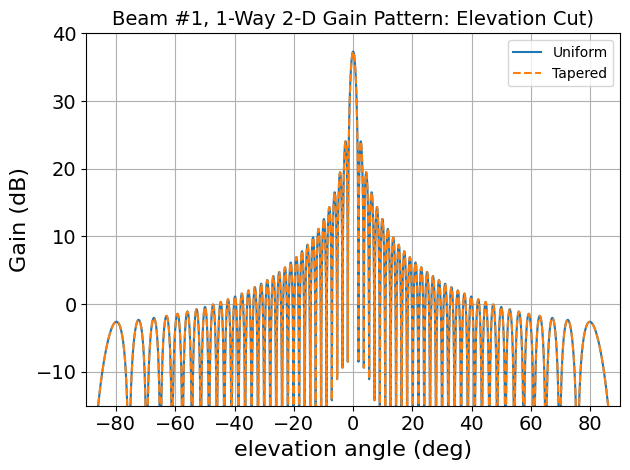

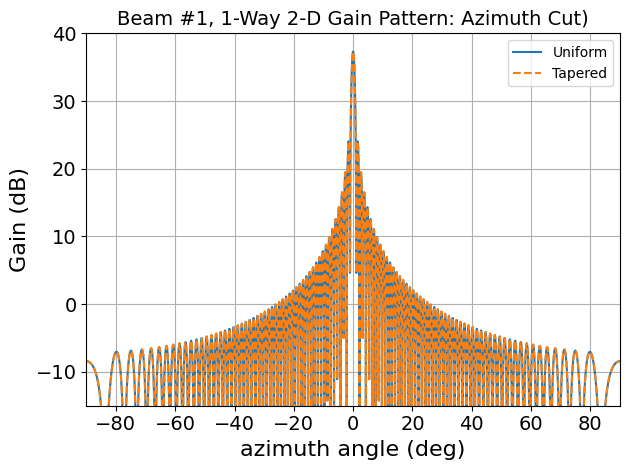

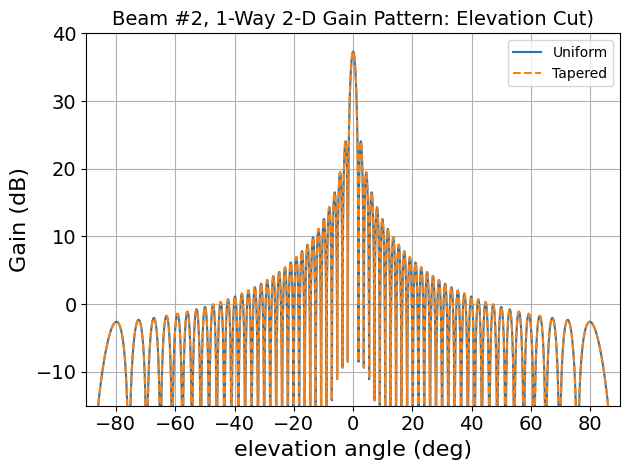

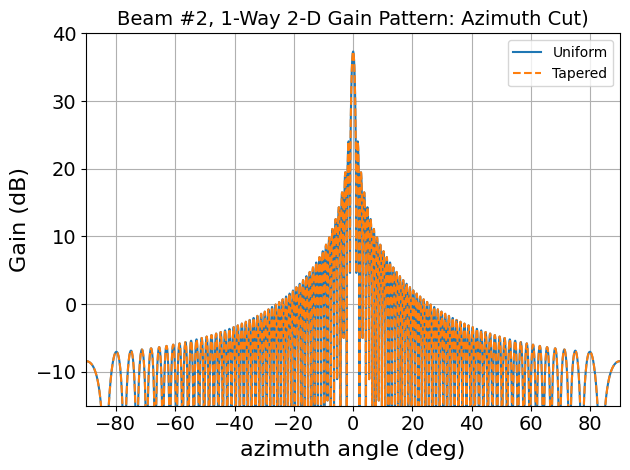

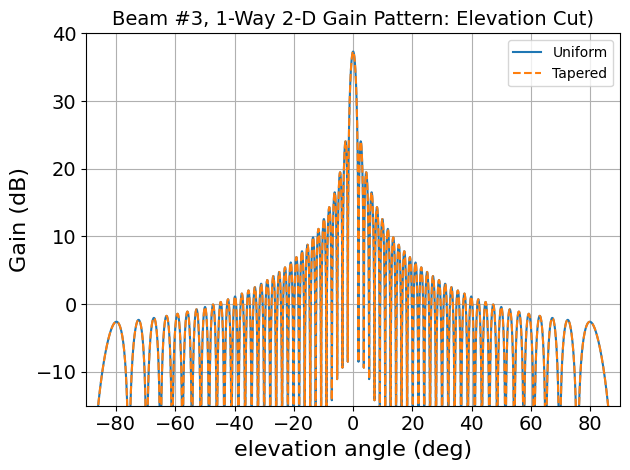

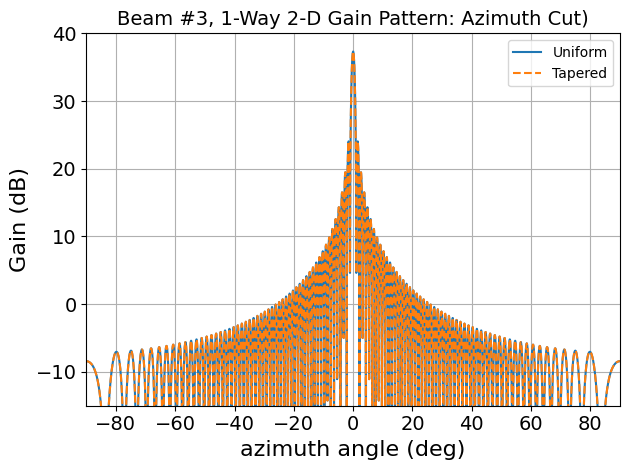

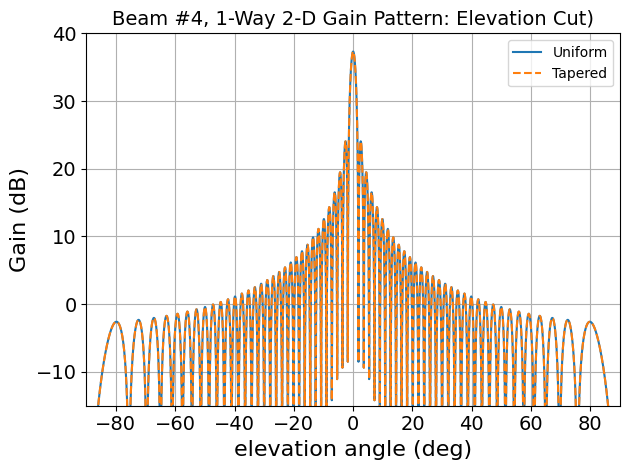

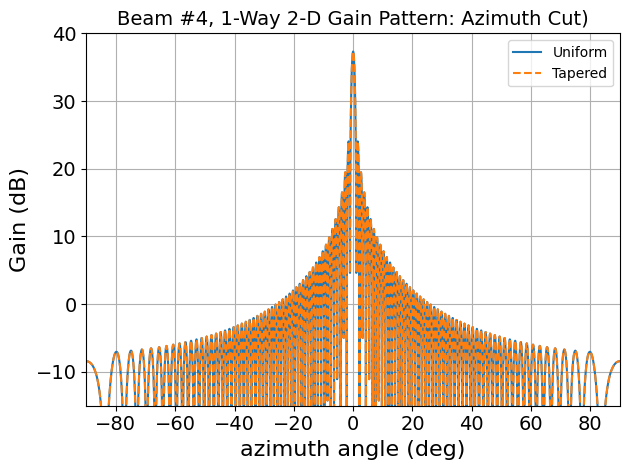

In [17]:
# ['rect_aperture', 'separable_cuts']

if ant_type == 'rect_aperture':

    theta= np.arange(-90,90,0.05)*onedeg    # antenna off-boresight angle
    Amax_azi_v= []
    Amax_ele_v= []
    
    for ib in range(Nbeams):
        
        # Ideal patterns

        antptrn_ele0= atn_ptrn(ant_type, None, [1], theta, Wa/wavelng)
        antptrn_azi0= atn_ptrn(ant_type, None, [1], theta, La/wavelng)

        # Tapered patterns
        
        antptrn_ele= atn_ptrn(ant_type,ant_ytaper_type[ib],ant_ytaper_params[ib], 
                               theta, Wa/wavelng)
        antptrn_azi= atn_ptrn(ant_type,ant_xtaper_type[ib],ant_xtaper_params[ib], 
                               theta, La/wavelng)
        
        Amax_azi0= np.max(antptrn_azi0)    # maximum 1-d gain
        Amax_azi= np.max(antptrn_azi)
        Amax_azi_v.append(Amax_azi)
        Amax_ele0= np.max(antptrn_ele0)
        Amax_ele= np.max(antptrn_ele)
        Amax_ele_v.append(Amax_ele)

        antptrn_ele0*= Loss_antenna    # 1-d pattern including loss
        antptrn_azi0*= Loss_antenna
        antptrn_ele*= Loss_antenna
        antptrn_azi*= Loss_antenna

        gain_1way_azi0= 4*np.pi*Amax_ele0*antptrn_azi0 # 1-way 2-d gain including loss
        gain_1way_azi= 4*np.pi*Amax_ele*antptrn_azi 
        gain_1way_ele0= 4*np.pi*Amax_azi0*antptrn_ele0 # 1-way 2-d gain including loss
        gain_1way_ele= 4*np.pi*Amax_azi*antptrn_ele 

        # Plotting: one-way 2-d gains

        fig= plt.figure()
        font= 16

        plt.plot(theta/onedeg,10*np.log10(4*np.pi*Amax_azi0*antptrn_ele0),'-',label='Uniform')
        plt.plot(theta/onedeg,10*np.log10(4*np.pi*Amax_azi*antptrn_ele),'--',label='Tapered')

        plt.grid(); plt.legend()
        plt.title('Beam #{}, 1-Way 2-D Gain Pattern: Elevation Cut)'.format(ib+1), fontsize= font-2)
        plt.ylabel('Gain (dB)', fontsize= font)
        plt.xlabel('elevation angle (deg)', fontsize= font)

        xlim= [-90,90]
        ylim= [-15, 40]

        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)

        ax= plt.gca()
        ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)

        plt.tight_layout()
        plt.show(); plt.close()  

        # Plotting: one-way 2-d gains

        fig= plt.figure()
        font= 16

        plt.plot(theta/onedeg,10*np.log10(4*np.pi*Amax_ele0*antptrn_azi0),'-',label='Uniform')
        plt.plot(theta/onedeg,10*np.log10(4*np.pi*Amax_ele*antptrn_azi),'--',label='Tapered')

        plt.grid(); plt.legend()
        plt.title('Beam #{}, 1-Way 2-D Gain Pattern: Azimuth Cut)'.format(ib+1), fontsize= font-2)
        plt.ylabel('Gain (dB)', fontsize= font)
        plt.xlabel('azimuth angle (deg)', fontsize= font)

        xlim= [-90,90]
        ylim= [-15,40]

        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)

        ax= plt.gca()
        ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)

        plt.tight_layout()
        plt.show(); plt.close()          

    


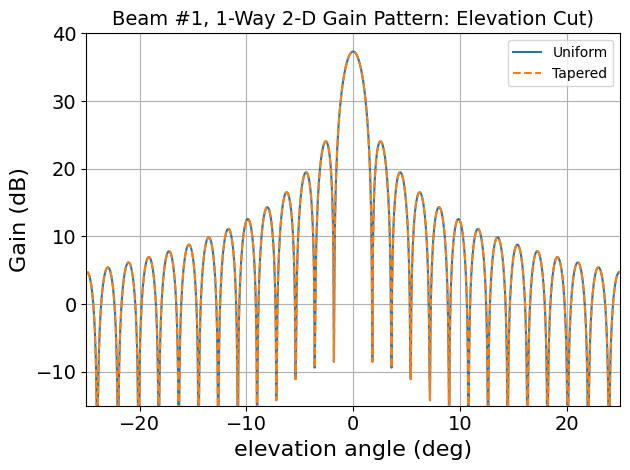

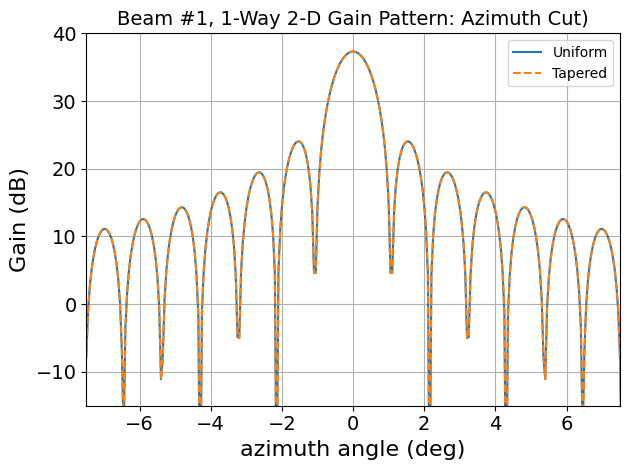

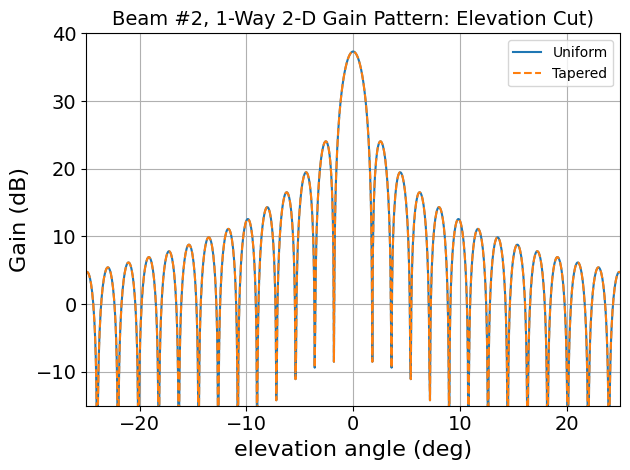

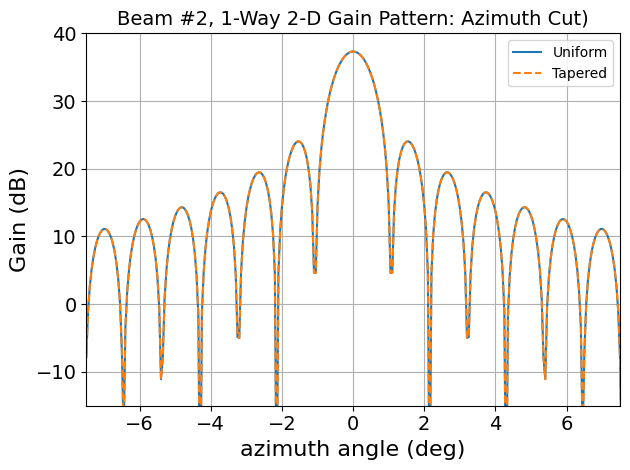

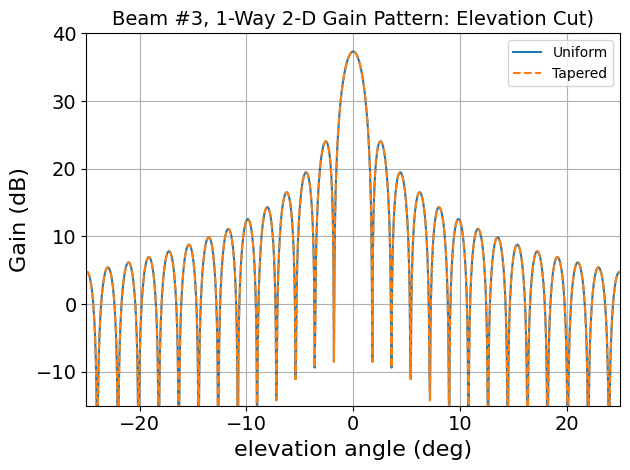

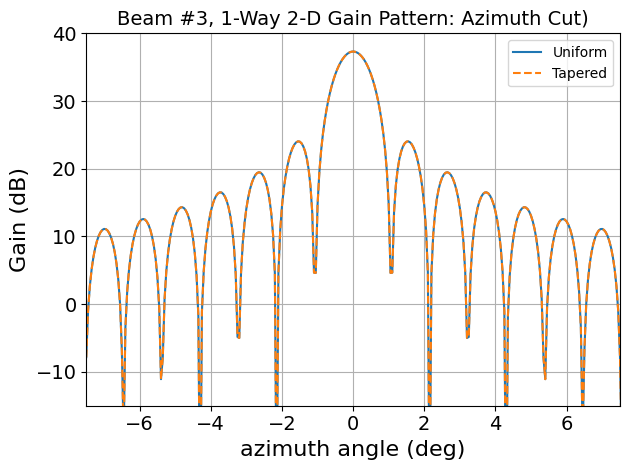

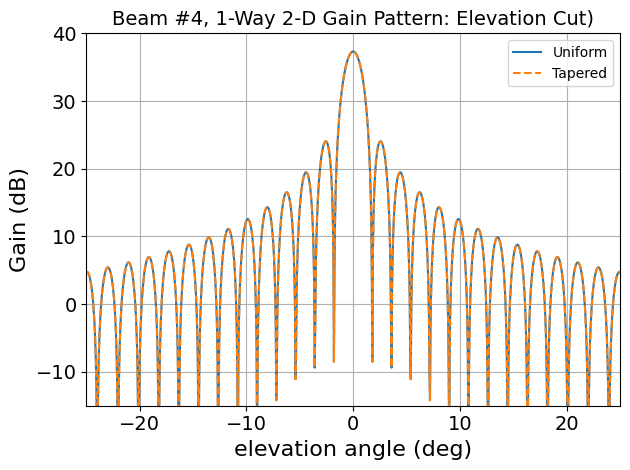

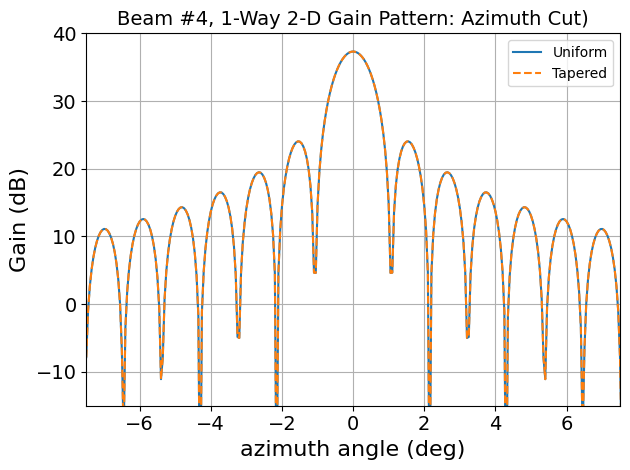

In [18]:
# ['rect_aperture', 'separable_cuts']

if ant_type == 'rect_aperture':

    theta= np.arange(-90,90,0.05)*onedeg    # antenna off-boresight angle
    Amax_azi_v= []
    Amax_ele_v= []

    for ib in range(Nbeams):
        
        # Ideal patterns

        antptrn_ele0= atn_ptrn(ant_type, None, [1], theta, Wa/wavelng)
        antptrn_azi0= atn_ptrn(ant_type, None, [1], theta, La/wavelng)

        # Tapered patterns
        
        antptrn_ele= atn_ptrn(ant_type,ant_ytaper_type[ib],ant_ytaper_params[ib], 
                               theta, Wa/wavelng)
        antptrn_azi= atn_ptrn(ant_type,ant_xtaper_type[ib],ant_xtaper_params[ib], 
                               theta, La/wavelng)
        
        Amax_azi0= np.max(antptrn_azi0)    # maximum 1-d gain
        Amax_azi= np.max(antptrn_azi)
        Amax_azi_v.append(Amax_azi)
        Amax_ele0= np.max(antptrn_ele0)
        Amax_ele= np.max(antptrn_ele)
        Amax_ele_v.append(Amax_ele)

        antptrn_ele0*= Loss_antenna    # 1-d pattern including loss
        antptrn_azi0*= Loss_antenna
        antptrn_ele*= Loss_antenna
        antptrn_azi*= Loss_antenna

        gain_1way_azi0= 4*np.pi*Amax_ele0*antptrn_azi0 # 1-way 2-d gain including loss
        gain_1way_azi= 4*np.pi*Amax_ele*antptrn_azi 
        gain_1way_ele0= 4*np.pi*Amax_azi0*antptrn_ele0 # 1-way 2-d gain including loss
        gain_1way_ele= 4*np.pi*Amax_azi*antptrn_ele 

        # Plotting: one-way 2-d gains

        fig= plt.figure()
        font= 16

        plt.plot(theta/onedeg,10*np.log10(4*np.pi*Amax_azi0*antptrn_ele0),'-',label='Uniform')
        plt.plot(theta/onedeg,10*np.log10(4*np.pi*Amax_azi*antptrn_ele),'--',label='Tapered')

        plt.grid(); plt.legend()
        plt.title('Beam #{}, 1-Way 2-D Gain Pattern: Elevation Cut)'.format(ib+1), fontsize= font-2)
        plt.ylabel('Gain (dB)', fontsize= font)
        plt.xlabel('elevation angle (deg)', fontsize= font)

        xlim= [-25,25]
        ylim= [-15, 40]

        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)

        ax= plt.gca()
        ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)

        plt.tight_layout()
        plt.show(); plt.close()  

        # Plotting: one-way 2-d gains

        fig= plt.figure()
        font= 16

        plt.plot(theta/onedeg,10*np.log10(4*np.pi*Amax_ele0*antptrn_azi0),'-',label='Uniform')
        plt.plot(theta/onedeg,10*np.log10(4*np.pi*Amax_ele*antptrn_azi),'--',label='Tapered')

        plt.grid(); plt.legend()
        plt.title('Beam #{}, 1-Way 2-D Gain Pattern: Azimuth Cut)'.format(ib+1), fontsize= font-2)
        plt.ylabel('Gain (dB)', fontsize= font)
        plt.xlabel('azimuth angle (deg)', fontsize= font)

        xlim= [-7.5,7.5]
        ylim= [-15,40]

        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)

        ax= plt.gca()
        ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)

        plt.tight_layout()
        plt.show(); plt.close()          

    


## 6. Noise-Equivalent-Zigma-Zero (NESZ): Equations

- The NESZ represents the radiometric sensitivity of the system, and is defined as the target radar cross-section when the *thermal SNR* of the image is equal to one (i.e., \\( \sigma \\) such that *return signal* = *thermal noise*).
- Factors in the NESZ Equation

$$ F_{noise} = kF_{op}T_{src}B_n \label{eq6-1}\tag{6-1}$$

$$ F_{pulse} = 2\frac{\sin\theta_i}{c\tau_p} \label{eq6-2}\tag{6-2}$$

$$ F_{loss} = L_{tx} L_{rx} \label{eq6-3}\tag{6-3}$$

$$ F_{prop} = \frac{(4\pi R)^3}{P_tG_t(\theta_l)G_r(\theta_l)\lambda^3} \label{eq6-4}\tag{6-4}$$

$$ F_{synth} = V_sT_p \label{eq6-5}\tag{6-5}$$

$$ \sigma_{NE}^0(\theta_l) = F_{noise} F_{pulse} F_{loss} F_{prop} F_{synth} \label{eq6-6}\tag{6-6}$$

- Note different usages of "noise factor" and "temperature"

$$ T_{op} = T_{src} + (F-1)T_0 = F_{sys}T_0 = F_{op}T_{src} \label{eq6-7}\tag{6-7}$$

where

- \\( T_{op} \\): operating temparature (effective system noise temperature),
- \\( T_{src} \\): source temperature,
- \\( T_0 = 290K \\): standard temperature,
- \\( F \\): standard noise factor,
- \\( F_{sys} \\): sytem noise factor (at \\( T_0\\)),
- \\( F_{op} \\): operating noise factor (at \\( T_{src}\\)),

and

$$ F_{sys} = (F-1) + \frac{T_{src}}{T_0} = \frac{T_{src}}{T_0} F_{op} \label{eq6-8}\tag{6-8}$$
$$ F_{op} = 1 + (F-1)\frac{T_0}{T_{src}} =  \frac{T_o}{T_{src}} F_{sys} \label{eq6-9}\tag{6-9}$$ 

### Reference
1. Curlander, J.C.; McDonough, R.N. *Synthetic Aperture Radar: Systems and Signal Processing*; John Wiley & Sons: New York, NY, USA, 1991.

### NESZ: Code

In [19]:
# NF

T_0= 290 # K, standard temperature

T_op= F_op*T_src
F_sys= (T_src/T_0)*F_op
F= (T_op-T_src)/T_0 + 1
T_e= (F-1)*T_0

print('Noise Figure')
print('    F_op, T_src= {:.2f}, {}K'.format(F_op, int(T_src)))
print('    T_op= {}K'.format(int(T_op)))
print('    F_sys= {:.2f} at {}K'.format(F_sys, int(T_0)))
print('    F= {:.1f} at {}K'.format(F, int(T_e)))

# NESZ

Nbms= len(theta_lk) # # of beams

fact_noise= k*F_op*T_src*tx_bw

fact_pulse= 2*np.sin(rx_inc_mid) / (c*pw)

fact_propa= 2*np.power(4*pi*rx_slnt_mid,3) / (Pt*np.power(Gmax_act,2)*np.power(wavelng,3))

fact_loss= np.power(10,-L_tx/10)*np.power(10,-L_rx/10)

fact_synth= Vs / PRF_l

fact_total= 10*np.log10(fact_propa) + 10*np.log10(fact_loss) + 10*np.log10(fact_pulse) + \
            10*np.log10(fact_noise) + 10*np.log10(fact_synth)

print('NESZ\'s Contributions at Boresight')
x= ['{:0.1f}'.format(10*np.log10(val)) for val in fact_noise]
y= [float(val) for val in x]
print('    Factor, Noise= {} dB'.format(y))
x= ['{:0.1f}'.format(10*np.log10(val)) for val in fact_pulse]
y= [float(val) for val in x]
print('    Factor, Pulse= {} dB'.format(y))
x= ['{:0.1f}'.format(10*np.log10(val)) for val in fact_propa]
y= [float(val) for val in x]
print('    Factor, Propa= {} dB'.format(y))
print('    Factor, Loss= {:.1f} dB'.format(10*np.log10(fact_loss)))
#print('    Factor, Anten= {:.1f} dB'.format(-10*np.log10(fact_again)))
x= ['{:0.1f}'.format(10*np.log10(val)) for val in fact_synth]
y= [float(val) for val in x]
print('    Factor, Synth= {} dB'.format(y))
print('    --------------')
x= ['{:0.1f}'.format(val) for val in fact_total]
y= [float(val) for val in x]
print('    Factor, Total= {} dB'.format(y))

angle_look= np.array([])
angle_inc= np.angle([])
rng_slnt= np.array([])
rng_grnd= np.array([])
gain_2way_ele= np.array([])
nesz= np.array([])
ac_norm= []

for ib in range(Nbms):
    delta= (rx_look_far[ib]-rx_look_nea[ib])/Ntgt_rng
    tmp_look= np.arange(rx_look_nea[ib],rx_look_far[ib],delta)
    tmp_look= tmp_look[:Ntgt_rng]
    tmp_mid= rx_look_mid[ib]
    angle_look= tmp_look if angle_look.size==0 else np.vstack((angle_look,tmp_look))

    if ant_type == 'rect_aperture':
        aptrn= atn_ptrn(ant_type,ant_ytaper_type[ib],ant_ytaper_params[ib], 
                               tmp_look-tmp_mid, Wa/wavelng)
        
    aptrn= (Loss_antenna*4*np.pi*Amax_azi_v[ib]*aptrn)**2 # 2-way 2-d gain including loss

    # For later SNR's computation 
    gain_2way_ele= aptrn if gain_2way_ele.size==0 else np.vstack((gain_2way_ele,aptrn))

    tmp= (fact_propa[ib]*np.power(Gmax_act[ib],2))*fact_loss/aptrn*fact_pulse[ib]*fact_noise[ib]*fact_synth[ib]
#   explain x2 as in sausage.
#    tmp= 2*(fact_propa[ib]*np.power(Gmax_act[ib],2))*fact_loss/aptrn*fact_pulse[ib]*fact_noise[ib]*fact_synth[ib]    

    # Normalized by ACTAPER
    norm= 1.0
    if actaper_type[ib]=='COSPEDESTAL':
        time_synth= rx_slnt_mid[ib]*(wavelng/La)/Vs
        Np= (time_synth*PRF_l[ib]).astype(int)
        x= (np.arange(0,Np) - Np/2)/Np
        pedestal= actaper_params[ib][0]
        y= taper_CosPedestal(x, pedestal)
        norm= np.max(y)**2
    ac_norm.append(norm)

    norm= 1
    tmp*= norm
    nesz= tmp if nesz.size==0 else np.vstack((nesz,tmp))

    # Other variables for plotting
    
    tmp_inc= np.arcsin((Re+Hs)/Re*np.sin(tmp_look))
    angle_inc= tmp_inc if angle_inc.size==0 else np.vstack((angle_inc,tmp_inc))

    qa= 1; qb= 2*Re*np.cos(tmp_inc); qc= (Re*Re - (Re+Hs)*(Re+Hs));
    tmp_slnt= (-qb + np.sqrt(qb*qb - 4*qa*qc))/2*qa;
    rng_slnt= tmp_slnt if rng_slnt.size==0 else np.vstack((rng_slnt,tmp_slnt))
    
    tmp_alpha= np.arcsin(tmp_slnt*(np.sin(tmp_inc)/(Re+Hs)))
    
    tmp_grnd= Re*tmp_alpha
    rng_grnd= tmp_grnd if rng_grnd.size==0 else np.vstack((rng_grnd,tmp_grnd))
    
y= format_print(ac_norm,1,fmt)    
ydb= format_print(10*np.log10(y),1,fmt)
print('\nAC Taper normalization: {} = {} dB'.format(y, ydb))

Noise Figure
    F_op, T_src= 3.58, 250K
    T_op= 895K
    F_sys= 3.09 at 290K
    F= 3.2 at 645K
NESZ's Contributions at Boresight
    Factor, Noise= [-127.0, -127.2, -127.3, -127.5] dB
    Factor, Pulse= [-39.1, -38.9, -38.7, -38.6] dB
    Factor, Propa= [139.2, 139.5, 139.8, 140.1] dB
    Factor, Loss= 0.0 dB
    Factor, Synth= [2.3, 2.8, 3.1, 2.8] dB
    --------------
    Factor, Total= [-24.5, -23.8, -23.2, -23.2] dB

AC Taper normalization: [0.7, 0.7, 0.7, 0.7] = [-1.5, -1.5, -1.5, -1.5] dB


### NESZ: Plots, Antenna Pattern

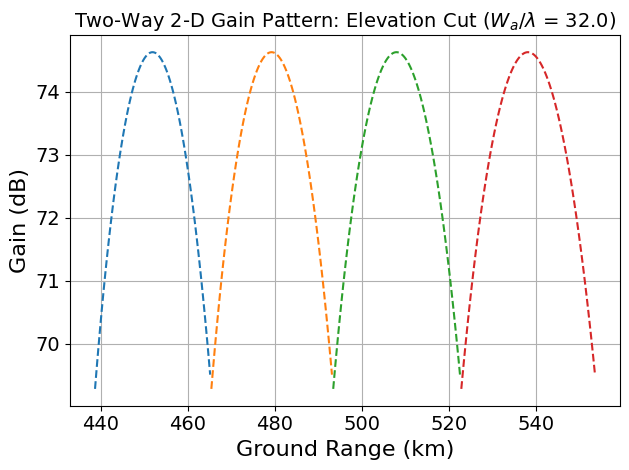

In [20]:
# Plotting Elevation Pattern

fig= plt.figure()
font= 16

s_angle= 'angle'
s_range= 'range'

xaxis= s_angle
xaxis= s_range

for ib in range(Nbms):
    if xaxis==s_angle:
        x= angle_look[ib,:]/onedeg
    else:
        x= rng_grnd[ib,:]/1e3

    plt.plot(x,10*np.log10(np.abs(gain_2way_ele[ib,:])),'--')

plt.grid()

plt.title(r'Two-Way 2-D Gain Pattern: Elevation Cut ($W_a / \lambda$ = {:.1f})'.format(Wa/wavelng), fontsize= font-2)
plt.ylabel('Gain (dB)', fontsize= font)
if xaxis==s_angle:
    plt.xlabel('Swath Look Angle (deg)', fontsize= font)
else:
    plt.xlabel('Ground Range (km)', fontsize= font)
    
ax= plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)

plt.tight_layout()
plt.show(); plt.close()  

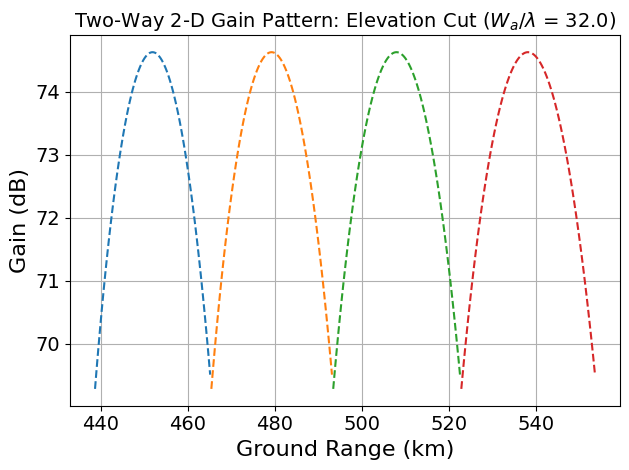

In [21]:
# Plotting Elevation Pattern

fig= plt.figure()
font= 16

s_angle= 'angle'
s_range= 'range'

xaxis= s_angle
xaxis= s_range

for ib in range(Nbms):
    if xaxis==s_angle:
        x= angle_look[ib,:]/onedeg
    else:
        x= rng_grnd[ib,:]/1e3

    plt.plot(x,10*np.log10(np.abs(gain_2way_ele[ib,:])),'--')

plt.grid()

plt.title(r'Two-Way 2-D Gain Pattern: Elevation Cut ($W_a / \lambda$ = {:.1f})'.format(Wa/wavelng), fontsize= font-2)
plt.ylabel('Gain (dB)', fontsize= font)
if xaxis==s_angle:
    plt.xlabel('Swath Look Angle (deg)', fontsize= font)
else:
    plt.xlabel('Ground Range (km)', fontsize= font)
    
ax= plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)

plt.tight_layout()
plt.show(); plt.close()  

### NESZ: Plots

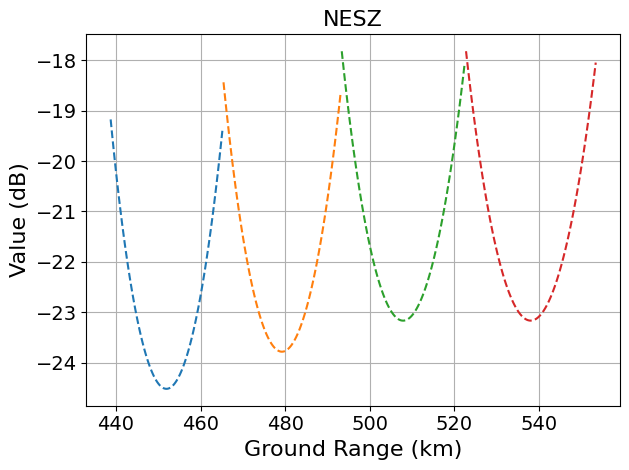

In [22]:
# Plotting NESZ

iend= 1    # excluding near/far ranges at the antenna pattern's null points

fig= plt.figure()
font= 16

s_angle= 'angle'
s_range= 'range'

xaxis= s_angle
xaxis= s_range

for ib in range(Nbms):
    if xaxis==s_angle:
        x= angle_look[ib,:]/onedeg
    else:
        x= rng_grnd[ib,:]/1e3

    plt.plot(x,10*np.log10(nesz[ib,:]),'--')

plt.grid()

plt.title('NESZ', fontsize= font)
plt.ylabel('Value (dB)', fontsize= font)
if xaxis==s_angle:
    plt.xlabel('Swath Look Angle (deg)', fontsize= font)
else:
    plt.xlabel('Ground Range (km)', fontsize= font)

ax= plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)

plt.tight_layout()
plt.show(); plt.close() 

## 7. Target Backscattering Model: Equations

- The mean backscatter coefficient \\(\mu_{\sigma0} \\) is given in decibels as a function of incident angle \\( \theta_{inc} \\) in radians by

$$ \mu_{\sigma0} = P_1 + P_2 \exp (-P_3 \theta_{inc}) + P_4 \cos(P_5 \theta_{inc} + P_6) \label{eq7-1}\tag{7-1}$$

- The (optional) standard deviation of \\(\mu_{\sigma0} \\) is given by

$$ \sigma_{\sigma0} = M_1 + M_2\exp(-M_3 \theta_{inc}) \label{eq7-2}\tag{7-2}$$ 

- The backscatter coefficient is computed as

$$ \sigma^0 = \mu_{\sigma0} + n_{\sigma}\sigma_{\sigma0} \label{eq7-3}\tag{7-3}$$

### Reference
1. Ulaby, F. T., and M. C. Dobson, *Handbook of Radar Scattering Statistics for Terrain*, Artech House, Boston, 1989.

### Backscatter Coefficients Dictionary: Ulaby-Dobson

In [23]:
Sigma0_UlabyDobson=\
    {   'Soil-L-HH':   [-85.984, 99, 0.628, 8.189, 3.414, -3.142, 5.6, -5.00E-04, -9],
        'Soil-L-HV':   [-30.2, 15.261, 3.56, -0.424, 0, 0, 4.675, -0.521, 3.187],
        'Soil-L-VV':   [-94.36, 99, 0.365, -3.398, 5, -1.739, 4.618, 0.517, -0.846],

        'Soil-S-HH':   [-91.2, 99, 0.433, 5.063, 2.941, -3.142, 4.644, 2.883, 15],
        'Soil-S-HV':   [-46.467, 31.788, 2.189, -17.99, 1.34, 1.583, 4.569, 0.022, -6.708],
        'Soil-S-VV':   [-97.016, 99, 0.27, -2.056, 5, -1.754, 14.914, -9, -0.285],

        'Grass-L-HH':  [-29.235, 37.550, 2.332, -2.615, 5.0, -1.616, -9.0, 14.268, -0.003],
        'Grass-L-HV':  [-40.166, 26.833, 2.029, -1.473, 3.738, -1.324, -9.0, 13.868, 0.070],
        'Grass-L-VV':  [-28.022, 36.590, 2.530, -1.530, 5.0, -1.513, -9.0, 14.239, -0.001],

        'Grass-S-HH':   [-20.361, 25.727, 2.979, -1.130, 5.0, -1.916, 3.313, 3.076, 3.759],
        'Grass-S-HV':   [-29.035, 18.055, 2.80, -1.556, 4.534, -0.464, 0.779, 3.580, 0.317],
        'Grass-S-VV':   [-21.198, 26.694, 2.828, -0.612, 5.0, -2.079, 3.139, 3.413, 3.042],
     
        'Shrub-L-HH':   [-26.688, 29.454, 1.814, 0.873, 4.135, -3.142, -9, 14.931, 0.092],
        'Shrub-L-HV':   [-99, 99, 0.086, -21.298, 0, 0, 4.747, -0.044, -2.826],
        'Shrub-L-VV':   [-81.371, 99, 0.567, 16.2, -1.948, 3.142, -9, 13.808, 0.053],

        'Shrub-S-HH':  [-21.202, 21.177,2.058,-0.132,-5,-3.142,1.713,3.205,1.729],
        'Shrub-S-HV':  [-89.222, 44.939, 0.253, 30, -0.355, 0.526, 12.735, -9, -0.159],
        'Shrub-S-VV':  [-20.566, 20.079, 1.776, -1.332, 5, -1.983, 2.475, 2.308, 3.858],
    
        'ShrtVeg-L-HH': [-27.265, 32.390, 2.133, 1.438, -3.847, 3.142, 1.593, 4.246, 0.063],
        'ShrtVeg-L-HV': [-41.60, 22.872, 0.689, -1.238, 0.0, 0.0, 0.590, 4.864, 0.098],
        'ShrtVeg-L-VV': [-24.614, 27.398, 2.265, -1.080, 5.0, -1.999, 4.918, 0.819, 15.0],
    
        'ShrtVeg-S-HH': [-20.779, 21.867, 2.434, 0.347, -0.013, -0.393, 2.527, 3.273, 3.001],
        'ShrtVeg-S-HV': [-99.0, 85.852, 0.179, 3.687, 2.121, -3.142, 13.195, -9.0, -0.148],
        'ShrtVeg-S-VV': [-20.367, 21.499, 2.151, -1.069, 5.0, -1.950,  2.963, 2.881, 4.740],
    
        'DrySnow-L-HH': [-74.019, 99.0, 1.592, -30.0, 1.928, 0.905, -9.0, 13.672, 0.064],
        'DrySnow-L-HV': [-91.341, 99.0, 1.202, 30.0, 1.790, -2.304, 5.377, -0.571, 3.695],
        'DrySnow-L-VV': [-77.032, 99.0, 1.415, -30.0, 1.720, 0.997, 4.487, -0.001, -5.725],
        
        'DrySnow-S-HH': [-47.055, 30.164, 5.788, 30.0, 1.188, -0.629, 3.572, -2.0e-05, -9.0],
        'DrySnow-S-HV': [-54.390, 13.292, 10.0, -30.0, -0.715, 3.142, 13.194, -9.0, -0.110],
        'DrySnow-S-VV': [-40.652, 18.826, 9.211, 30.0, 0.690, 0.214, -9.0, 12.516, 0.075],
        
        'WetSnow-L-HH': [-73.069, 95.221, 1.548, 30.0, 1.795, -2.126, -9.0, 14.416, 0.109],
        'WetSnow-L-HV': [-90.980, 99.0, 1.129, 30.0, 1.827, -2.308, 4.879, 0.349, 15.0],
        'WetSnow-L-VV': [-75.156, 99.0, 1.446, 30.0, 1.793, -2.179, 5.230, -0.283, -1.557],
        'WetSnow-S-HH': [-45.772, 25.160, 5.942, 30.0, 0.929, -0.284, 12.944, -9.0, -0.079],
        'WetSnow-S-HV': [-42.940, 9.935, 15.0, 30.0, 0.438, 0.712, 3.276, 1.027, 8.958],
        'WetSnow-S-VV': [-39.328, 18.594, 8.046, 30.0, 0.666, 0.269, 1.157, 2.904, 0.605]
    }

### Target Backscattering Model: Code


Scattering Model (Scene Type): Ulaby-Dobson (Soil-L-HH)
    P_params: [-85.984, 99, 0.628, 8.189, 3.414, -3.142]
    M_params: [5.6, -0.0005, -9]
    N sigmas: 0


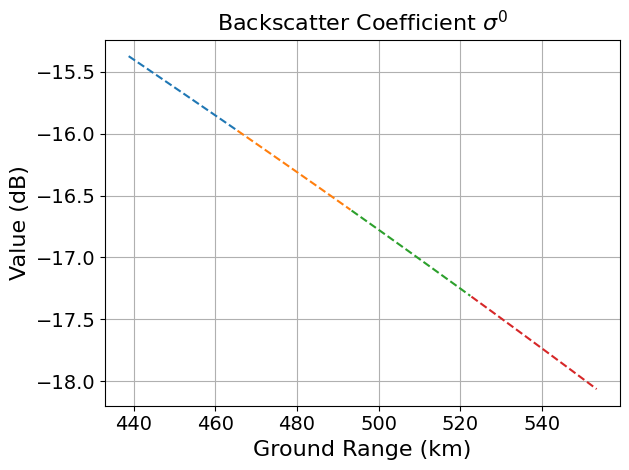

In [24]:
def ulaby_dobson(inc,P,M,n_sigma):
    avg= P[0] + P[1]*np.exp(-P[2]*inc) + P[3]*np.cos(P[4]*inc+P[5])
    std= M[0] + M[1]*np.exp(-M[2]*inc)
    sigma= avg + n_sigma*std
    return sigma
    
# Scattering Parameters (Ulaby-Dobson) for Shrub at S-band

if scattering_model=='Ulaby-Dobson':        
    params= Sigma0_UlabyDobson[scene_type]
else:
    print('----> Error: Scattering model not defined')
    
scat_p_params= [params[0],params[1],params[2],params[3],params[4],params[5]]
scat_m_params= [params[6],params[7],params[8]]

print('\nScattering Model (Scene Type): {} ({})'.format(scattering_model,scene_type))
print('    P_params: {}'.format(scat_p_params))
print('    M_params: {}'.format(scat_m_params))
print('    N sigmas: {}'.format(scat_n_sigmas))

# Computing sigma0

angle_look= np.array([])
angle_inc= np.angle([])
sigma0= np.array([])

for ib in range(Nbeams):
    delta= (rx_look_far[ib]-rx_look_nea[ib])/Ntgt_rng
    tmp_look= np.arange(rx_look_nea[ib],rx_look_far[ib],delta)
    tmp_look= tmp_look[:Ntgt_rng]
    angle_look= tmp_look if angle_look.size==0 else np.vstack((angle_look,tmp_look))

    tmp_inc= np.arcsin((Re+Hs)/Re*np.sin(tmp_look))
    angle_inc= tmp_inc if angle_inc.size==0 else np.vstack((angle_inc,tmp_inc))
    
    tmp_sig= ulaby_dobson(tmp_inc,scat_p_params,scat_m_params,scat_n_sigmas)
    sigma0= tmp_sig if sigma0.size==0 else np.vstack((sigma0,tmp_sig))

fig= plt.figure()
font= 16

s_angle= 'angle'
s_range= 'range'

xaxis= s_angle
xaxis= s_range

for ib in range(Nbms):
    if xaxis==s_angle:
        x= angle_look[ib,:]/onedeg
    else:
        x= rng_grnd[ib,:]/1e3

    plt.plot(x,sigma0[ib,:],'--')

plt.grid()

plt.title(r'Backscatter Coefficient $\sigma^0$', fontsize= font)
plt.ylabel('Value (dB)', fontsize= font)
if xaxis==s_angle:
    plt.xlabel('Swath Look Angle (deg)', fontsize= font)
else:
    plt.xlabel('Ground Range (km)', fontsize= font)

ax= plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)

plt.tight_layout()
plt.show(); plt.close()  

## 8. Range-Ambiguity-to-Signal-Ratio (RASR): Equations

- Range Ambiguity

![SAR-RngAmb2.png](./Pix/SAR-RngAmb2.png)

- Range ambiguity refers to echoes - from the preceeding and succeeding pulses - occurring outside the swath (due to the elevation sidelobes of the composite antenna pattern), and entering the radar receiver along with the useful echoes inside the swath - during the current pulse.
- Decreasing the PRF often reduces range ambiguities by increasing the pulse spacing, thereby pushing the range ambiguity points further out to locations lower down on the composite antenna elevation pattern.

$$ RASR=\frac{\sum_{n=1}^{N_s} S_{a,n}}{\sum_{n=1}^{N_s} S_n} \label{eq8-1}\tag{8-1}$$

$$ S_{a,n}=\sum_{k=-N_p,\, k\neq0}^{N_p} \frac{\sigma^0[\theta_i(n,k)]G_t[\theta_i(n,k)]G_r[\theta_i(n,k)]}{R_s^3[\theta_i(n,k)]\sin[\theta_i(n,k)]} \label{eq8-2}\tag{8-2}$$

$$ S_n= \frac{\sigma^0[\theta_i(n,0)]G_t[\theta_i(n,0)]G_r[\theta_i(n,0)]}{R_s^3[\theta_i(n,0)]\sin[\theta_i(n,0)]} \label{eq8-3}\tag{8-3}$$

where \\( (n,k) \\) refer to the target and ambiguity points, respectively. To calculate the RASR precisely, consider the slant range to the target within the (elevation) swath at time \\( t_i \\) due to the transmit pulse at time \\( j\times PRI \\)

$$ R_{ij} = c(t_i + j \times PRI )/2 \quad j = 0,\pm1, \pm2, \ldots, \pm n_h  \label{eq8-4}\tag{8-4}$$

where

- \\( j = 0 \\) corresponds to the desired target position,  
- \\( j > 0 \\) correspond to the ambiguous signals from the preceeding pulses,  
- \\( j < 0 \\) correspond to the ambiguous signals from the succeeding pulses, and  
- \\( n_h \\) is the number of pulses on the horizon.

From the above slant range, the look \\( \theta_{ij}^{lk} \\) and incident \\( \eta_{ij} \\) angles to the target can be derived, as before, for the calculations of the antenna gain and backscatter coefficient, respectively. Finally, the signal and ambiguous powers can be derived as

$$ P_{sig} = \frac{ \sigma_{ij}^0 G_{ij}^0(\theta_{ij}^{lk}) } {R_{ij}^3 \sin(\eta_{ij})}, \quad  j=0 \label{eq8-5}\tag{8-5}$$

$$ P_{amb} = \sum_{j=-n_h, j\neq0}^{n_h} \frac{ \sigma_{ij}^0 G_{ij}^0(\theta_{ij}^{lk}) } {R_{ij}^3 \sin(\eta_{ij})}, \quad  j \neq 0  \label{eq8-6}\tag{8-6}$$

### Reference
1. Curlander, J.C.; McDonough, R.N. *Synthetic Aperture Radar: Systems and Signal Processing*; John Wiley & Sons: New York, NY, USA, 1991.

### RASR: Code

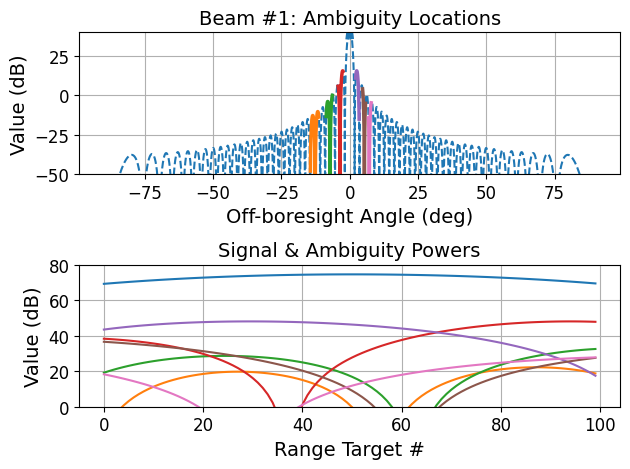

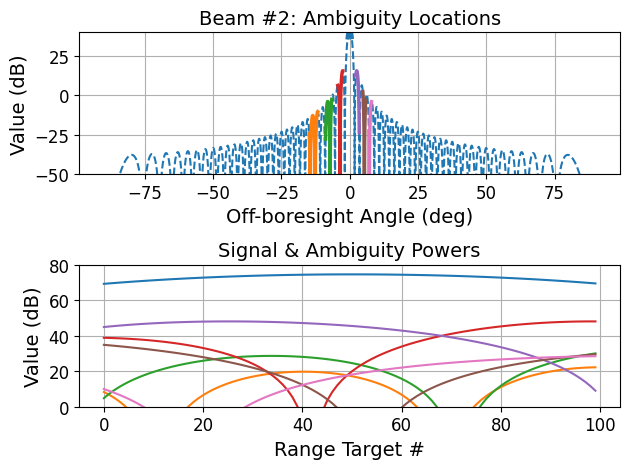

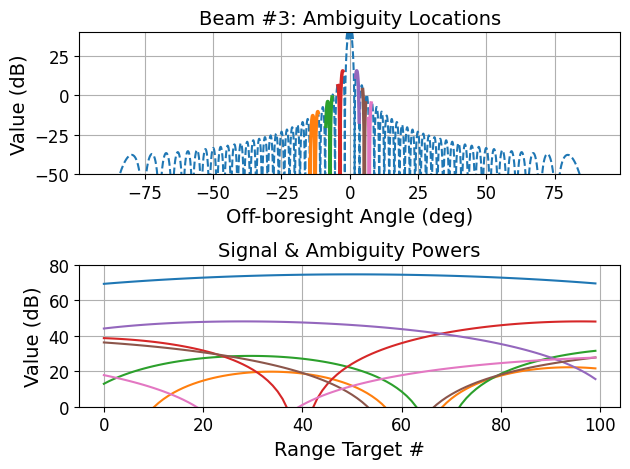

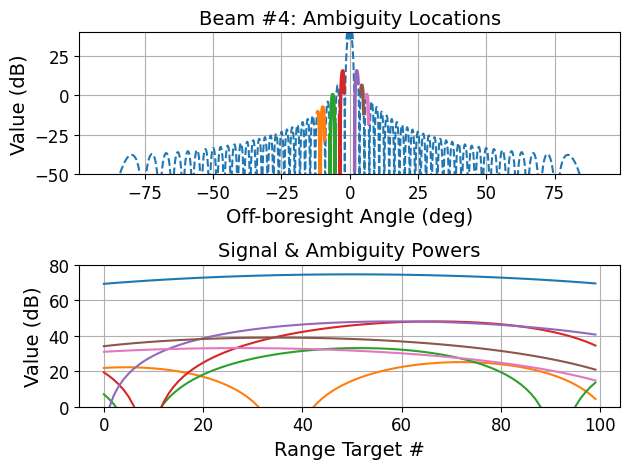

In [25]:
iplt_amb= 1    # [0,1], set to 1 to see the ambiguity locations on the antenna pattern.

Ntgt= 100    # Number of targets in each beam
nPIA= 4      # Number of pulses in the air

angle_look= np.array([])
angle_inc= np.array([])
rng_slnt= np.array([])

amb_pwr_rng= np.array([])
sig_pwr_rng= np.array([])
rasr= np.array([])

for ib in range(Nbeams):

    PRF= PRF_l[ib]
    
    # Off-boresight geometrical values of Targets across (elevation) swath

    delta= (rx_look_far[ib]-rx_look_nea[ib])/Ntgt_rng
    tmp_look= np.arange(rx_look_nea[ib],rx_look_far[ib],delta)[:Ntgt_rng]
    angle_look= tmp_look if angle_look.size==0 else np.vstack((angle_look,tmp_look))
    
    tmp_inc= look2inc(tmp_look,Re,Hs)
    angle_inc= tmp_inc if angle_inc.size==0 else np.vstack((angle_inc,tmp_inc))

    tmp_slnt= inc2slnt(tmp_inc,Re,Hs)
    rng_slnt= tmp_slnt if rng_slnt.size==0 else np.vstack((rng_slnt,tmp_slnt))

    # Slant range of Target & Ambiguity 
    # i: index of echo within the swath of the current beam
    # j > 0: preceeding pulses
    # j = 0: desired (current) pulse
    # j < 0: succeedding pulses
    
    R_sl_ij= np.array([])
    j_list= list(range(-nPIA+1,nPIA))
    j_list.remove(0)
#    j_list= list(range(1,nPIA))
    
    for j in j_list:
        tmp=  tmp_slnt + c*j/PRF/2
        R_sl_ij= tmp if R_sl_ij.size==0 else np.vstack((R_sl_ij,tmp))

    # Look angle for valid j (for gain calculations)
    
    R_slant_valid= np.array([])
    theta_l_ij= np.array([])
    j_valid= []

    for j in range(len(j_list)):
        R_slant= R_sl_ij[j,:]
        chk_slnt= (R_slant**2 + (Re+Hs)**2 - Re**2)/2/R_slant/(Re+Hs)
        idx= np.nonzero(chk_slnt > 1)[0]
        if idx.size==0:
            j_valid.append(j_list[j])
            tmp= slnt2look(R_slant,Re,Hs)
            theta_l_ij= tmp if theta_l_ij.size==0 else np.vstack((theta_l_ij,tmp))
            R_slant_valid= R_slant if R_slant_valid.size==0 else np.vstack((R_slant_valid,R_slant))
            
    # Incident angle for backscatter calculation

    theta_i_ij= look2inc(theta_l_ij,Re,Hs)
    sigma_amb= ulaby_dobson(theta_i_ij,scat_p_params,scat_m_params,scat_n_sigmas)

    # Gain calculation

    phi_ij= theta_l_ij - rx_look_mid[ib]
    if ant_type == 'rect_aperture':
        aptrn= atn_ptrn(ant_type,ant_ytaper_type[ib],ant_ytaper_params[ib], 
                               phi_ij, Wa/wavelng)
        gain_ij= (Loss_antenna*4*np.pi*Amax_azi_v[ib]*aptrn)**2 # two-way 2-d
    elif ant_type == 'separable_cuts':
        gain_ij= Amax_azi_sim*np.interp(phi_ij/onedeg, antptrn_ele_sim[:,0], antptrn_ele_sim[:,1])
        
#    amb_pwr= np.sum((gain_ij)/(R_slant_valid**3)/(np.sin(theta_i_ij)), axis=0)
    amb_pwr= np.sum((gain_ij)/(R_slant_valid**3)/(np.sin(theta_i_ij))*(10**(sigma_amb/10)), axis=0)
    
    phi_i= tmp_look - rx_look_mid[ib]
    if ant_type == 'rect_aperture':
        aptrn= atn_ptrn(ant_type,ant_ytaper_type[ib],ant_ytaper_params[ib], 
                               phi_i, Wa/wavelng)
        gain_i= (Loss_antenna*4*np.pi*Amax_azi*aptrn)**2 # two-way 2-d
    elif ant_type == 'separable_cuts':
        gain_i= Amax_azi_sim*np.interp(phi_i/onedeg, antptrn_ele_sim[:,0], antptrn_ele_sim[:,1])

    sigma_sig= ulaby_dobson(tmp_inc,scat_p_params,scat_m_params,scat_n_sigmas)
        
#    sig_pwr= (gain_i)/(tmp_slnt**3)/(np.sin(tmp_inc)) 
    sig_pwr= (gain_i)/(tmp_slnt**3)/(np.sin(tmp_inc))*(10**(sigma_sig/10)) 

    tmp_rasr= amb_pwr/sig_pwr

    amb_pwr_rng= amb_pwr if amb_pwr_rng.size==0 else np.vstack((amb_pwr_rng,amb_pwr))
    sig_pwr_rng= sig_pwr if sig_pwr_rng.size==0 else np.vstack((sig_pwr_rng,sig_pwr))
    rasr= tmp_rasr if rasr.size==0 else np.vstack((rasr,tmp_rasr))
    
    if iplt_amb==1:
        # Plot Signal & Ambiguity locations/Power

        fig, axs= plt.subplots(2)
        font= 14

        # Locations

        if ant_type == 'rect_aperture':
            theta= np.arange(-90,90,0.05)*onedeg    # antenna off-boresight angle
            aptrn= atn_ptrn(ant_type,ant_ytaper_type[ib],ant_ytaper_params[ib], 
                                   theta, Wa/wavelng)
        
            axs[0].plot(theta/onedeg, 10*np.log10(aptrn**2/(Loss_antenna)**2), '--')
            axs[0].plot(phi_i/onedeg,10*np.log10(gain_i/(Loss_antenna*4*np.pi*Amax_azi)**2/(Loss_antenna)**2), color='tab:blue', linewidth=3)
            for j in range(len(j_valid)):
                axs[0].plot(phi_ij[j,:]/onedeg,10*np.log10(gain_ij[j,:]/(Loss_antenna*4*np.pi*Amax_azi)**2/(Loss_antenna)**2), linewidth=2.5)

        axs[0].grid()
        axs[0].set_title('Beam #{}: Ambiguity Locations'.format(ib+1), fontsize= font)
        axs[0].set_ylabel('Value (dB)', fontsize= font)
        axs[0].set_xlabel('Off-boresight Angle (deg)', fontsize= font)

        axs[0].set_ylim([-40, 40])
        axs[0].set_ylim([-50, 40])

        axs[0].tick_params(axis = 'both', which = 'major', labelsize=font-2)

        # Power

        axs[1].plot(10*np.log10(gain_i))
        for j in range(len(j_valid)):
            axs[1].plot(10*np.log10(gain_ij[j,:]))

        axs[1].grid()
        axs[1].set_title('Signal & Ambiguity Powers', fontsize= font)
        axs[1].set_ylabel('Value (dB)', fontsize= font)
        axs[1].set_xlabel('Range Target #', fontsize=font)

        axs[1].set_ylim([0, 80])

        axs[1].tick_params(axis = 'both', which = 'major', labelsize=font-2)

        plt.tight_layout()
        plt.show(); plt.close()     

### RASR: Plots

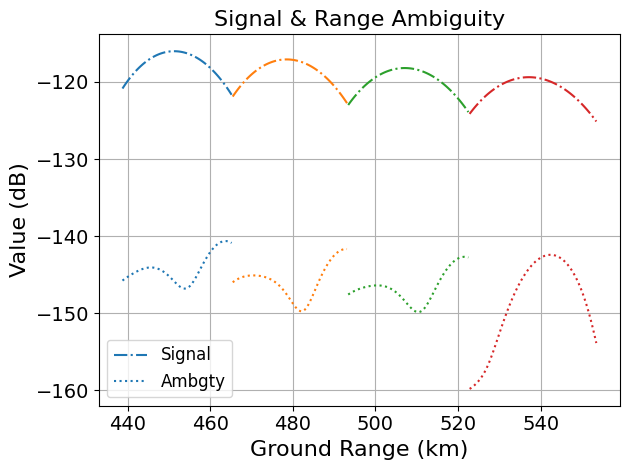

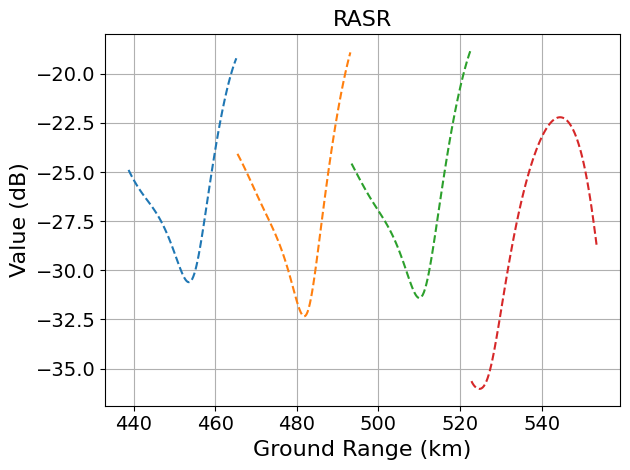

In [26]:
# Plotting Signals / Ambiguities

iend= 1    # excluding near/far ranges at the antenna pattern's null points

fig= plt.figure()
font= 16

s_angle= 'angle'
s_range= 'range'

xaxis= s_angle
xaxis= s_range

for ib in range(Nbms):
    if xaxis==s_angle:
        x= angle_look[ib,:]/onedeg
    else:
        x= rng_grnd[ib,:]/1e3

    if ib==0:
        p= plt.plot(x,10*np.log10(sig_pwr_rng[ib,:]),'-.',label='Signal')
        color= p[0].get_color()
        plt.plot(x,10*np.log10(amb_pwr_rng[ib,:]),':',label='Ambgty', color=color)
    else:
        p= plt.plot(x,10*np.log10(sig_pwr_rng[ib,:]),'-.')
        color= p[0].get_color()
        plt.plot(x,10*np.log10(amb_pwr_rng[ib,:]),':', color=color)
        
plt.grid(); plt.legend(fontsize=font-4)

plt.title('Signal & Range Ambiguity', fontsize= font)
plt.ylabel('Value (dB)', fontsize= font)
if xaxis==s_angle:
    plt.xlabel('Swath Look Angle (deg)', fontsize= font)
else:
    plt.xlabel('Ground Range (km)', fontsize= font)

ax= plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)

plt.tight_layout()
plt.show(); plt.close()  

# Plotting RASR

fig= plt.figure()
font= 16

for ib in range(Nbms):
    if xaxis==s_angle:
        x= angle_look[ib,:]/onedeg
    else:
        x= rng_grnd[ib,:]/1e3

    plt.plot(x,10*np.log10(rasr[ib,:]),'--')

plt.grid()

plt.title('RASR', fontsize= font)
plt.ylabel('Value (dB)', fontsize= font)
if xaxis==s_angle:
    plt.xlabel('Swath Look Angle (deg)', fontsize= font)
else:
    plt.xlabel('Ground Range (km)', fontsize= font)

ax= plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)

plt.tight_layout()
plt.show(); plt.close() 

## 9. Azimuth-Ambiguity-to-Signal-Ratio (AASR): Equations

- Azimuth Ambiguity

![SAR-AziAmb.png](./Pix/SAR-AziAmb.png)

- Azimuth ambiguity is caused by the finite sampling of the Doppler spectrum by the PRF, i.e. Doppler frequency aliasing (due to the azimuth sidelobes of the composite antenna pattern).
- Increasing the PRF often reduces azimuth ambiguities by increasing the Doppler sampling, thereby pushing the ambiguity points further out to locations lower down on the composite antenna azimuth pattern.

$$ ASSR= \frac
{\sum_{m=-M,\, m\neq0}^M \int_{-B_d/2}^{B_d/2} G_t(f_d+m\cdot f_p) G_r(f_d+m\cdot f_p) \sigma^0(f_d+m\cdot f_p) df_d}
{\int_{-B_d/2}^{B_d/2} G_t(f_d)G_r(f_d)\sigma^0(f_d) df_d} \label{eq9-1}\tag{9-1}$$

- Maximum Doppler Bandwidth

$$ f_d= \frac{2V_s}{\lambda} \cdot \phi_{azi}^{3dB} \label{eq9-2}\tag{9-2}$$

- Processing Doppler Bandwidth

$$ B_p= \frac{V_s}{\delta x_{req}} \cdot \frac{R_e}{R_e+H_s} \label{eq9-3}\tag{9-3}$$

In order to evaluate Eq. (\ref{eq9-1}), it is necessary to relate the **radar variables** - *time delay (slant range)* \\( t_d \\) and *Doppler frequency* \\( f_d \\), measured in the *"satellite cooordinate system"* - to the **antenna variables** off the antenna boresight - *elevation angle* \\( \theta \\) and *azimuth angle* \\( \phi \\), measured in the *"antenna (radar) cooordinate system"*.  This problem has been studied by many (e.g. [2, 3]). Here, [3] is followed for a closed-form relations between the two radar's and antenna's coordinate systems.

A | B
- | - 
<img src="./Pix/SAR-Obs-Geo.png" alt="SAR-Obs-Geo.png" /> | <img src="./Pix/SAR-Amb-Distr.png" alt="SAR-Amb-Distr.png" /> 

<br>

$$ R= (R_p+H_s) \left[ \cos(\alpha_0 + \theta) \cos\phi - \sqrt{\cos^2(\alpha_0 + \theta) \cos^2\phi - \cos^2(\alpha_H)} \right] \label{eq9-4}\tag{9-4} $$

$$ \cos \theta_l = \cos (\alpha_0 + \theta) \cos \phi \label{eq9-5}\tag{9-5}$$

$$ \alpha_H = \sin^{-1}(\frac{R_p}{R_p+H_s}) \label{eq9-6}\tag{9-6}$$

$$ t_d= 2R/c \label{eq9-7}\tag{9-7}$$

$$ f_d = \frac{2V}{\lambda} \sin\phi  \label{eq9-8}\tag{9-8}$$

where

* \\( \alpha_0 \\): antenna's boresight angle;
* \\( \theta_l \\): target's look angle.

The inverse relations are

$$ \theta (t_d,f_d)= -\alpha_0 + \cos^{-1} \left[ \frac{(R_p+H_s)^2 - R_p^2 + (ct_d/2)^2}{(R_p+H_s) \ ct_d \ \sqrt{1- \left( \frac{\lambda f_d}{2V} \right) ^2}} \right] \label{eq9-9}\tag{9-9}$$

$$ \phi (f_d)= \sin^{-1} \left( \frac{\lambda f_d}{2V} \right) \label{eq9-10}\tag{9-10}$$


### Reference
1. Curlander, J.C.; McDonough, R.N. *Synthetic Aperture Radar: Systems and Signal Processing*; John Wiley & Sons: New York, NY, USA, 1991.
2. Li, F.K. and Johnson, W.T.K., Ambiguities in Spaceborne Synthetic Aperture Radar Systems, *IEEE Trans. Aeros. Electron. Syst.*, vol. AES-19, no. 3, pp. 389-397, May 1983.
3. Lorenzo, P.D., Barbarosa, S. and Borgarelli, L., Optimal Beamforming for Range-Doppler Ambiguity Minimization in Squinted SAR, *IEEE Trans. Aeros. Electron. Syst.*, vol. 49, no. 1, pp. 277-293, Jan 2013.

### AASR: Code

In [27]:
# Doppler sim

fd1= -7000
fd2= 7000
delta_fd= (fd2-fd1)/Npnt_aasr
fd_sim= np.arange(fd1,fd2,delta_fd)[:Npnt_aasr]

# Relative Satellite/Target velocity

Vst= Vs
#Vst= Vs*np.sqrt(Re/(Re+Hs))
print('(Vs, Vst) = ({:.1f}, {:.1f}) m/s'.format(Vs, Vst))

# Processing bandwidth

fd_proc= Vs/res_azi # Hz
#fd_proc= Vs*np.sqrt(Re/(Re+Hs))/res_azi # Hz, in sausage?
#fd_proc= Vs*Re/(Re+Hs)/res_azi # Hz, in sausage?

print('PRF= {} Hz'.format(PRF_l))
print('Processed Doppler Bandiwth= {:.1f} Hz'.format(fd_proc))

# AASR over swath

angle_look= np.array([])
angle_inc= np.array([])
rng_slnt= np.array([])
rng_grnd= np.array([])

fd_azcut_l= np.empty((Nbeams,Ntgt_rng,Npnt_aasr))

amb_pwr_azi= np.array([])
sig_pwr_azi= np.array([])
aasr= np.array([])

for ib in range(Nbeams):

    PRF= PRF_l[ib]

    print('\nBeam #{}, PRF/2 = {:.1f} Hz'.format(ib+1,PRF/2))

    # Off-boresight values across (elevation) swath

    delta= (rx_look_far[ib] - rx_look_nea[ib])/Ntgt_rng
    tmp_look= np.arange(rx_look_nea[ib],rx_look_far[ib],delta)[:Ntgt_rng]
    angle_look= tmp_look if angle_look.size==0 else np.vstack((angle_look,tmp_look))
    
    tmp_inc= look2inc(tmp_look,Re,Hs)
    angle_inc= tmp_inc if angle_inc.size==0 else np.vstack((angle_inc,tmp_inc))

    tmp_slnt= inc2slnt(tmp_inc,Re,Hs)
    rng_slnt= tmp_slnt if rng_slnt.size==0 else np.vstack((rng_slnt,tmp_slnt))

    tmp_alpha= inc2alpha(tmp_inc,Re,Hs,tmp_slnt)
    
    tmp_grnd= alpha2grnd(tmp_alpha,Re)
    rng_grnd= tmp_grnd if rng_grnd.size==0 else np.vstack((rng_grnd,tmp_grnd))

    amb_pwr_bm= np.array([])
    sig_pwr_bm= np.array([])
    aasr_bm= np.array([])
  
    for ir in range(Ntgt_rng):
#    for ir in range(1):
        
        tgt_azi= np.arcsin(wavelng*fd_sim/2/Vst)
        tgt_ele= - rx_look_mid[ib] + np.arccos(((Re+Hs)**2 - Re**2 + tmp_slnt[ir]**2) /
                                                     ((Re+Hs)*2*tmp_slnt[ir]*np.cos(tgt_azi)))
#        tgt_look= np.cos(rx_look_mid[ib]+tgt_ele)*np.cos(tgt_azi)
        tgt_look= np.arccos(np.cos(rx_look_mid[ib]+tgt_ele)*np.cos(tgt_azi))
        tgt_inc= look2inc(tgt_look,Re,Hs)

        tgt_sigma= ulaby_dobson(tgt_inc,scat_p_params,scat_m_params,scat_n_sigmas)

        if ant_type == 'rect_aperture':
            
            aptrn_ele= atn_ptrn(ant_type,ant_ytaper_type[ib],ant_ytaper_params[ib], 
                            tgt_ele, Wa/wavelng)
            aptrn_azi= atn_ptrn(ant_type,ant_xtaper_type[ib],ant_xtaper_params[ib], 
                            tgt_azi, La/wavelng)
            
#            pedestal= 1
#            aptrn_ele, p0, pp1, pm1= ant_rect_pattern(tgt_ele,Wa/wavelng,pedestal)
#            aptrn_azi, p0, pp1, pm1= ant_rect_pattern(tgt_azi,La/wavelng,pedestal)
            gain_2way= (Loss_antenna*4*np.pi*aptrn_ele*aptrn_azi)**2 # two-way 2-d
        elif ant_type == 'separable_cuts':
#            gain_2way= np.interp(tgt_ele/onedeg, antptrn_ele_sim[:,0], antptrn_ele_sim[:,1]) *\
#                       np.interp(tgt_azi/onedeg, antptrn_azi_sim[:,0], antptrn_azi_sim[:,1]) /\
#                       Amax_azi_sim
            gain_2way= np.interp(tgt_ele/onedeg, antptrn_ele_sim[:,0], antptrn_ele_sim[:,1]) *\
                       np.interp(tgt_azi/onedeg, antptrn_azi_sim[:,0], antptrn_azi_sim[:,1])

        # Mainlobe
        
        fdc= 0
        flim1= -fd_proc/2 + fdc
        flim2= fd_proc/2 + fdc
        
        i1= np.where(flim1 < fd_sim)[0][0]
        i2= np.where(fd_sim < flim2)[0][-1]
        
        # Azimuth-compression tapering
        
        if actaper_type[ib] == 'COSPEDESTAL':
            x= (np.arange(i1,i2,1) - (i1+i2)/2)/(i2-i1)
            taper_az_mlb= np.square(taper_CosPedestal(x,actaper_params[ib][0]))
        else:
            taper_az_mlb= np.ones(i2-i1)
            
        p_mlb= np.sum(gain_2way[i1:i2] * (10**(tgt_sigma[i1:i2]/10)) * taper_az_mlb)
        
        if ir==0:
            print('    Mainlobe, Processing BW = {:.1f}, {:.1f} Hz, fdc= {}'.format(fd_sim[i1], fd_sim[i2], fdc))
            print('        Mainlobe power = {:.1f} dB\n'.format(10*np.log10(p_mlb)))
            
        # Sidelobe
        
        p_slb= 0.0
        Namb= int(np.max(fd_sim/PRF)) # number of aliasing regions due to sampling
        
        # Positive side only, assuming symmetric pattern
        
        for n in range(1,Namb):
            i1= np.where((n*PRF+flim1) < fd_sim)[0][0]
            i2= np.where(fd_sim < (n*PRF+flim2))[0][-1] 

            # Azimuth-compression tapering

            if actaper_type[ib] == 'COSPEDESTAL':
                x= (np.arange(i1,i2,1) - (i1+i2)/2)/(i2-i1)
                taper_az_slb= np.square(taper_CosPedestal(x,actaper_params[ib][0]))
            else:
                taper_az_slb= np.ones(i2-i1)
            
            p_slb+= np.sum(gain_2way[i1:i2] * (10**(tgt_sigma[i1:i2]/10)) * taper_az_slb)

            if ir==0:

                print('    Sidelobe #{}, Aliasing BW = {:.1f}, {:.1f} Hz'.format(n, fd_sim[i1], fd_sim[i2]))
                print('        Sidelobe power = {:.1f} dB\n'.format(10*np.log10(2*p_slb)))
    
        p_slb*= 2 # add negative side
        amb= p_slb/p_mlb
        
        amb_pwr_bm= np.array([p_slb]) if amb_pwr_bm.size==0 else np.append(amb_pwr_bm,p_slb)
        sig_pwr_bm= np.array([p_mlb]) if sig_pwr_bm.size==0 else np.append(sig_pwr_bm,p_mlb)
        aasr_bm= np.array([amb]) if aasr_bm.size==0 else np.append(aasr_bm,amb)

    amb_pwr_azi= amb_pwr_bm if amb_pwr_azi.size==0 else np.vstack((amb_pwr_azi,amb_pwr_bm))
    sig_pwr_azi= sig_pwr_bm if sig_pwr_azi.size==0 else np.vstack((sig_pwr_azi,sig_pwr_bm))
    aasr= aasr_bm if aasr.size==0 else np.vstack((aasr,aasr_bm))  
    
if Nbms==1:    
    rng_grnd= rng_grnd.reshape(1,len(rng_grnd))   
    fdc_l= fdc_l.reshape(1,len(fdc_l))   
    sig_pwr_azi= sig_pwr_azi.reshape(1,len(sig_pwr_azi))   
    amb_pwr_azi= amb_pwr_azi.reshape(1,len(amb_pwr_azi))  
    aasr= aasr.reshape(1,len(aasr))  

(Vs, Vst) = (7535.1, 7535.1) m/s
PRF= [4420, 3980, 3700, 3980] Hz
Processed Doppler Bandiwth= 502.3 Hz

Beam #1, PRF/2 = 2210.0 Hz
    Mainlobe, Processing BW = -250.4, 250.4 Hz, fdc= 0
        Mainlobe power = 73.5 dB


Beam #2, PRF/2 = 1990.0 Hz
    Mainlobe, Processing BW = -250.4, 250.4 Hz, fdc= 0
        Mainlobe power = 72.9 dB


Beam #3, PRF/2 = 1850.0 Hz
    Mainlobe, Processing BW = -250.4, 250.4 Hz, fdc= 0
        Mainlobe power = 72.3 dB


Beam #4, PRF/2 = 1990.0 Hz
    Mainlobe, Processing BW = -250.4, 250.4 Hz, fdc= 0
        Mainlobe power = 71.6 dB



### AASR: Plots

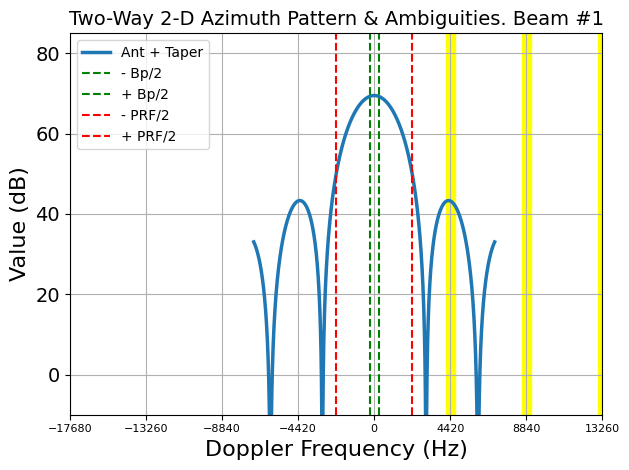

C:\Users\cppayne\AppData\Local\Temp\1\ipykernel_17816\3981995474.py:78: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x,10*np.log10(amb_pwr_azi[ib,:]),':',label='Ambgty', color=color)
C:\Users\cppayne\AppData\Local\Temp\1\ipykernel_17816\3981995474.py:82: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x,10*np.log10(amb_pwr_azi[ib,:]),':', color=color)


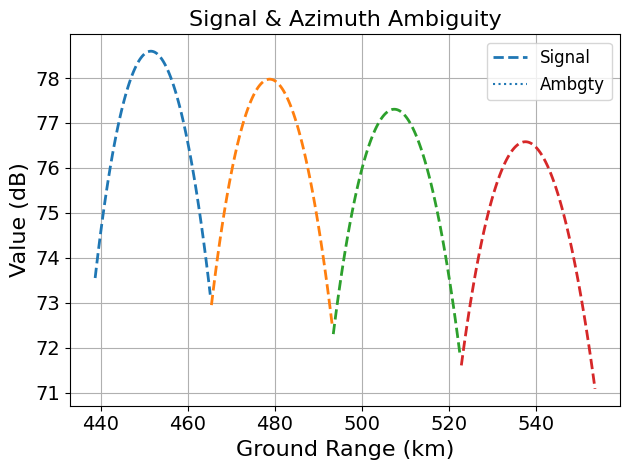

C:\Users\cppayne\AppData\Local\Temp\1\ipykernel_17816\3981995474.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x,10*np.log10(aasr[ib,:]),'--')


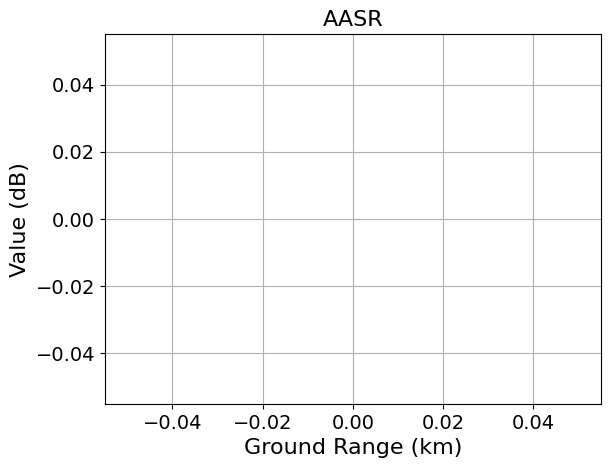

In [28]:
# Plotting Atenna Pattern (azcut)

fig= plt.figure()
font= 16

xlim= [-6000,6000]
ylim= [-10,85]

ib= 0
PRF= PRF_l[ib]

ir= 0

flim1= -fd_proc/2 
flim2= fd_proc/2 

plt.plot(fd_sim, 10*np.log10(gain_2way),'-', linewidth=2.5, label='Ant + Taper')
#plt.plot([-fd_proc/2, -fd_proc/2], [ylim[0], ylim[1]],'g--', label='- Bp/2')
#plt.plot([fd_proc/2, fd_proc/2], [ylim[0], ylim[1]],'g--', label='+ Bp/2')
plt.plot([flim1, flim1], [ylim[0], ylim[1]],'g--', label='- Bp/2')
plt.plot([flim2, flim2], [ylim[0], ylim[1]],'g--', label='+ Bp/2')
#plt.plot([-PRF/2, -PRF/2], [ylim[0], ylim[1]],'r--', label='- PRF/2')
#plt.plot([PRF/2, PRF/2], [ylim[0], ylim[1]],'r--', label='+ PRF/2')
plt.plot([-PRF/2, -PRF/2], [ylim[0], ylim[1]],'r--', label='- PRF/2')
plt.plot([PRF/2, PRF/2], [ylim[0], ylim[1]],'r--', label='+ PRF/2')

ax= fig.gca()

Namb_plt= 4

for iamb in range(1,Namb_plt+1):
#    rect = patches.Rectangle((-iamb*PRF-fd_proc/2, ylim[0]), fd_proc, ylim[1]-ylim[0], color='yellow')
#    rect = patches.Rectangle((iamb*PRF-fd_proc/2, ylim[0]), fd_proc, ylim[1]-ylim[0], color='yellow')
    rect = patches.Rectangle((iamb*PRF+flim1, ylim[0]), fd_proc, ylim[1]-ylim[0], color='yellow')
    ax.add_patch(rect)
    
plt.grid(); plt.legend(loc='upper left')

plt.title('Two-Way 2-D Azimuth Pattern & Ambiguities. Beam #{}'.format(ib+1), fontsize= font-2)
plt.ylabel('Value (dB)', fontsize= font)
plt.xlabel('Doppler Frequency (Hz)', fontsize= font)

plt.xlim(xlim)
plt.ylim(ylim)

xticks= np.arange(-Namb_plt*PRF,Namb_plt*PRF,PRF)
plt.xticks(xticks)

ax= plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize=font-8)
ax.tick_params(axis = 'y', which = 'major', labelsize=font-2)

plt.tight_layout()
plt.show(); plt.close()

# Plotting Signals / Ambiguities

iend= 1    # excluding near/far ranges at the antenna pattern's null points

fig= plt.figure()
font= 16

s_angle= 'angle'
s_range= 'range'

xaxis= s_angle
xaxis= s_range

for ib in range(Nbms):
    if xaxis==s_angle:
        x= angle_look[ib,:]/onedeg
    else:
        x= rng_grnd[ib,:]/1e3

    if ib==0:
        p= plt.plot(x,10*np.log10(sig_pwr_azi[ib,:]),'--',linewidth=2,label='Signal')
        color= p[0].get_color()
        plt.plot(x,10*np.log10(amb_pwr_azi[ib,:]),':',label='Ambgty', color=color)
    else:
        p= plt.plot(x,10*np.log10(sig_pwr_azi[ib,:]),'--',linewidth=2)
        color= p[0].get_color()
        plt.plot(x,10*np.log10(amb_pwr_azi[ib,:]),':', color=color)
        
plt.grid(); plt.legend(fontsize=font-4)

plt.title('Signal & Azimuth Ambiguity', fontsize= font)
plt.ylabel('Value (dB)', fontsize= font)
if xaxis==s_angle:
    plt.xlabel('Swath Look Angle (deg)', fontsize= font)
else:
    plt.xlabel('Ground Range (km)', fontsize= font)

ax= plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)

plt.tight_layout()
plt.show(); plt.close()  

# Plotting AASR

fig= plt.figure()
font= 16

for ib in range(Nbms):
    if xaxis==s_angle:
        x= angle_look[ib,:]/onedeg
    else:
        x= rng_grnd[ib,:]/1e3
    
    plt.plot(x,10*np.log10(aasr[ib,:]),'--')

plt.grid()

plt.title('AASR', fontsize= font)
plt.ylabel('Value (dB)', fontsize= font)
if xaxis==s_angle:
    plt.xlabel('Swath Look Angle (deg)', fontsize= font)
else:
    plt.xlabel('Ground Range (km)', fontsize= font)

ax= plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)
#plt.tight_layout()
plt.show(); plt.close()  

## 10.1 SNR: Equations

- SAR's SNR eqation for distributed targets

$$ S\!N\!R = \frac{P_{av}G^2 \lambda^3 \sigma^0 \delta R_g}{2(4 \pi R)^3 L_{tx}L_{rx} V_{st}kF_{op}T_{src}} \label{eq10-1}\tag{10-1}$$

where \\( P_{av} \\) is the average power, and \\( \delta R_g \\) the ground range cell resolution after compression (because the normalized backscatter coefficient is typically defined as normal to the scattering surface).

$$ P_{av} = P_t \frac{\tau_p}{T_p} \label{eq10-2}\tag{10-2}$$

$$ \delta R_g = \frac{c}{2B_n\sin\theta_i} \label{eq10-3}\tag{10-3}$$

The SNR eqation above can be re-written to highlight various contributing factors:
- constants,
- operating geometry (controllable),
- hardware capability (controllable),
- signal processing (controllable), and
- scattering target, respectively

$$ S\!N\!R = \frac{1}{2(4 \pi)^3 k} \cdot \frac{1}{R^3V_{st}} \cdot \frac{P_{av}G^2 \lambda^3}  {L_{tx}L_{rx}F_{op}T_{src}} \cdot \delta R_g \cdot \sigma^0  \label{eq10-4}\tag{10-4}$$

- Substituting the expressions for \\( P_{av} \\) in Eq. (\ref{eq10-2}) and \\( \delta R_g \\) in Eq. (\ref{eq10-3}) and rearranging, the SNR equation takes the form

$$ S\!N\!R = \frac{(P_tG^2 \lambda^3) \, \sigma^0 \, (\frac{c\tau_p}{2\sin\theta_i})} {2(4 \pi R)^3 \, (L_{tx}L_{rx}) \, (V_{st}T_p) \, (kF_{op}T_{src}B_n)} \label{eq10-5}\tag{10-5}$$

- Setting \\( S\!N\!R = 1 \\), the \\( \sigma_{NE}^0 \\) equation is recoverd, which establishes the SAR's noise floor. Real target with \\( \sigma^0 \, > \, \sigma_{NE}^0 \\) would be reflected in the \\( S\!N\!R \\).

- Quantization Noise: Assuming BFPQ is employed, the Signal-to-Quantization-Noise Ratio (SQNR) is calculated from the table below

| # of bits | QNR (dB) |
| --------- | -------- |
| 1         | 4.40     |
| 2         | 9.25     |
| 3         | 14.27    |
| 4         | 19.38    |
| 5         | 24.57    |
| 6         | 29.83    |
| 7         | 35.17    |
| 8         | 40.57    |
| 9         | 46.03    |
| 10        | 51.55    |
| 11        | 57.11    |
| 12        | 62.71    |
| 13        | 68.35    |
| 14        | 74.01    |
| 15        | 79.70    |
| 16        | 85.40    |


The actual SQNR is scaled by the the oversampling factor in the range (cross-track) direction

$$ S\!Q\!N\!R = Q\!N\!R\,_\text{BFPQ} \cdot \frac{f_s}{B} \label{eq10-6}\tag{10-6}$$

where \\( B \\) is the complex bandwidth, and \\( f_s \\) the fast-time sampling frequency.

- The multiplicative noise \\( I\!S\!L\!R \\) will be included shortly.

### References
1. Curlander, J.C.; McDonough, R.N. *Synthetic Aperture Radar: Systems and Signal Processing*; John Wiley & Sons: New York, NY, USA, 1991.
2. Curtis Chen, *Sausage: User Manual and Algorithm Description*, Oct. 06, 2020.

### SNR: Code

In [29]:
print(10*np.log10(ac_norm))

[-1.67092103 -1.67092131 -1.67092134 -1.67092128]


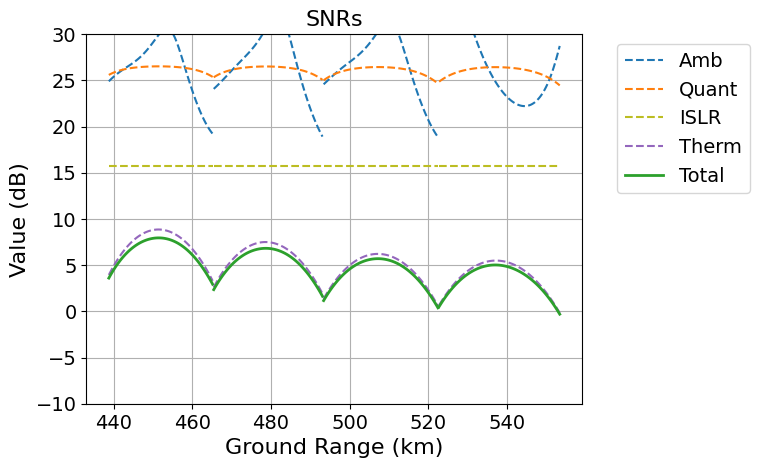

In [30]:
# SNRs

snr_thermal= np.array([])

proc_norm= np.copy(ac_norm)
proc_norm= np.ones((Nbeams,))

for ib in range(Nbms):

    PRF= PRF_l[ib]

    tmp= proc_norm[ib]*Pt*(pw*PRF)*gain_2way_ele[ib,:]*pow(wavelng,3)*pow(10,sigma0[ib]/10)*res_rng/ fact_loss / \
         (2*pow(4*pi*rng_slnt[ib],3)*Vs*k*F_op*T_src)
    
    snr_thermal= tmp if (snr_thermal.size==0) else np.vstack((snr_thermal,tmp))

snr_tamb= 1/(rasr + aasr)

# ISLR, place-holder, code to be written

f_islr_azi= -26.1 
f_islr_rng= -16.1 

snr_islr= 1/(10**(f_islr_rng/10) + 10**(f_islr_azi/10)) * np.ones(snr_thermal.shape)

#snr_quant= 10**(sqnr(nbits)*(np.ones(snr_thermal.shape))/10)         
snr_quant= 10**(sqnr(nbits)/10)*(1/(1 + 1/snr_thermal + 1/snr_tamb + 1/snr_islr))         
for ib in range(Nbms):
    snr_quant[ib,:]*= fsamp/tx_bw[ib]

# Total SNR

snr= 1/(1/snr_thermal + 1/snr_quant + 1/snr_tamb + 1/snr_islr) 

# Plotting
    
fig= plt.figure()
font= 16

s_angle= 'angle'
s_range= 'range'

xaxis= s_angle
xaxis= s_range

for ib in range(Nbms):
    if xaxis==s_angle:
        x= angle_look[ib,:]/onedeg
    else:
        x= rng_grnd[ib,:]/1e3

    if ib==0:
        plt.plot(x,10*np.log10(snr_tamb[ib,:]),'--',color='tab:blue',label='Amb')
        plt.plot(x,10*np.log10(snr_quant[ib,:]),'--',color='tab:orange',label='Quant')
        plt.plot(x,10*np.log10(snr_islr[ib,:]),'--',color='tab:olive',label='ISLR')
        plt.plot(x,10*np.log10(snr_thermal[ib,:]),'--',color='tab:purple',label='Therm')

        plt.plot(x,10*np.log10(snr[ib,:]),linewidth=2,color='tab:green',label='Total')
    else:
        plt.plot(x,10*np.log10(snr_tamb[ib,:]),'--',color='tab:blue')
        plt.plot(x,10*np.log10(snr_quant[ib,:]),'--',color='tab:orange')
        plt.plot(x,10*np.log10(snr_islr[ib,:]),'--',color='tab:olive')
        plt.plot(x,10*np.log10(snr_thermal[ib,:]),'--',color='tab:purple')

        plt.plot(x,10*np.log10(snr[ib,:]),linewidth=2,color='tab:green')
            
plt.grid(); plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize= font-2)

plt.title('SNRs', fontsize= font)
plt.ylabel('Value (dB)', fontsize= font)
if xaxis==s_angle:
    plt.xlabel('Swath Look Angle (deg)', fontsize= font)
else:
    plt.xlabel('Ground Range (km)', fontsize= font)

ylim= [-10,30]
#ylim= []
if ylim:
    plt.ylim(ylim)
    
ax= plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)
#plt.tight_layout()
plt.show(); plt.close() 


## 10.2 Summary: Radar Instrument Performances

C:\Users\cppayne\AppData\Local\Temp\1\ipykernel_17816\3092863238.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x,10*np.log10(aasr[ib,:]),'-.',color='tab:orange',label='AASR')
C:\Users\cppayne\AppData\Local\Temp\1\ipykernel_17816\3092863238.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x,10*np.log10(aasr[ib,:]),'-.',color='tab:orange')


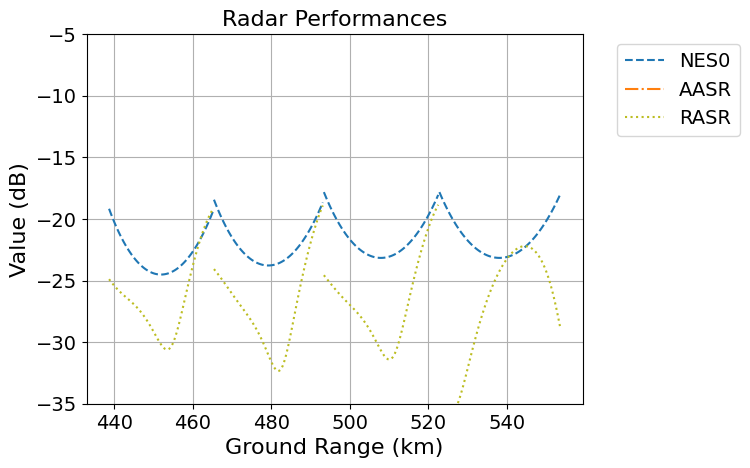

In [31]:
fig= plt.figure()
font= 16

s_angle= 'angle'
s_range= 'range'

xaxis= s_angle
xaxis= s_range

for ib in range(Nbms):
    if xaxis==s_angle:
        x= angle_look[ib,:]/onedeg
    else:
        x= rng_grnd[ib,:]/1e3

    if ib==0:
        plt.plot(x,10*np.log10(nesz[ib,:]),'--',color='tab:blue',label='NES0')
        plt.plot(x,10*np.log10(aasr[ib,:]),'-.',color='tab:orange',label='AASR')
        plt.plot(x,10*np.log10(rasr[ib,:]),':',color='tab:olive',label='RASR')
    else:
        plt.plot(x,10*np.log10(nesz[ib,:]),'--',color='tab:blue')
        plt.plot(x,10*np.log10(aasr[ib,:]),'-.',color='tab:orange')
        plt.plot(x,10*np.log10(rasr[ib,:]),':',color='tab:olive')
    
plt.grid(); plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize= font-2)

plt.title('Radar Performances', fontsize= font)
plt.ylabel('Value (dB)', fontsize= font)
if xaxis==s_angle:
    plt.xlabel('Swath Look Angle (deg)', fontsize= font)
else:
    plt.xlabel('Ground Range (km)', fontsize= font)

ylim= [-35, -5]
if ylim:
    plt.ylim(ylim)

ax= plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=font-2)
#plt.tight_layout()
plt.show(); plt.close()  

## 11 Radar Interferometry Background

## 12.1 Summary: System Parameters

In [32]:
PRI_l= 1/np.array(PRF_l)
dutyc= pw/PRI_l
Pavg= dutyc*Pt

fmt= '{:.1f}'
prfl= format_print(PRF_l,1,fmt)
pril= format_print(PRI_l,1e-6,fmt)
dutycl= format_print(dutyc,1/100,fmt)
pavgl= format_print(Pavg,1,fmt)
bwd_azi= format_print(beam_wd_azi,onedeg,fmt)
bwd_ele= format_print(beam_wd_ele,onedeg,fmt)

gain= format_print(10*np.log10(Gmax_act),1,fmt)

data= { 
    'System Parameter': ['Satellite Altitude', 
                  'Center Frequency', 
                  'Polarization', 
                  'Antenna Size LxH', 
                  'Antenna Azi Beamwidths',
                  'Antenna Ele Beamwidths',
                  'Look Angles',
                  'Antenna Directivity',
                  'Antenna Radiation Efficiency', 
                  'Antenna Loss (feed + circulator)',
                  'Antenna Gain (one-way)',
                  'Peak Transmit Power',
                  'Transmit Loss',
                  'Receive Loss',
                  'Pulse Repetition Frequency',
                  'Pulse Repetition Interval',
                  'Transmit Duty Cycle',
                  'Average Transmit Power',
                  'Operating Noise Factor',
                  'Source Temperature',
                  'Operating (System) Temperature',
                  'Quantization'
                 ],
    'Value': ['{} km'.format(Hs/1e3),
              '{} GHz'.format(fc/1e9),
              'Dual-Pol',
              '{:.2f} m x {:.2f} m = {:.2f} m2'.format(La,Wa,La*Wa), 
              '{} deg'.format(bwd_azi),
              '{} deg'.format(bwd_ele),
              '{} deg'.format(theta_lk),
              '{:.1f} dB'.format(10*np.log10(D0)),
              '{:.1f} dB'.format(eta_a),
              '{:.1f} dB'.format(L_feed+L_circ),
              '{} dB'.format(gain),
              '{} W'.format(Pt),
              '{:.1f} dB'.format(L_tx),
              '{:.1f} dB'.format(L_rx),
              '{} Hz'.format(prfl),
              '{} usec'.format(pril),
              '{} %'.format(dutycl),
              '{} W'.format(pavgl),
              '{}'.format(F_op),
              '{} K'.format(T_src),
              '{} K'.format(int(T_op)),
              '{} bits'.format(nbits)
             ],
    'Note': ['mission input',
             'mission input',
             'mission input',
             'mission input',
             'calculated',
             'calculated',
             'mission input',
             'calculated',
             'mission input',
             'mission input',
             'calculated',
             'mission input',
             'mission input',
             'mission input',
             'design iteration',
             'design iteration',
             'calculated',
             'calculated',
             'mission input',
             'mission input',
             'calculated',
             'mission input'
            ]
}

df= pd.DataFrame(data)
df.set_index('System Parameter', inplace=True)
df

Value  \
System Parameter                                                        
Satellite Altitude                                           641.0 km   
Center Frequency                                              3.2 GHz   
Polarization                                                 Dual-Pol   
Antenna Size LxH                           5.00 m x 3.00 m = 15.00 m2   
Antenna Azi Beamwidths                       [0.9, 0.9, 0.9, 0.9] deg   
Antenna Ele Beamwidths                       [1.5, 1.5, 1.5, 1.5] deg   
Look Angles                              [34.5, 36.0, 37.5, 39.0] deg   
Antenna Directivity                                           43.3 dB   
Antenna Radiation Efficiency                                  -3.0 dB   
Antenna Loss (feed + circulator)                              -3.0 dB   
Antenna Gain (one-way)                    [37.3, 37.3, 37.3, 37.3] dB   
Peak Transmit Power                                            1000 W   
Transmit Loss                                                  0.0 dB   
Receive Loss                                                   0.0 dB   
Pulse Repetition Frequency        [4420.0, 3980.0, 3700.0, 3980.0] Hz   
Pulse Repetition Interval           [226.2, 251.3, 270.3, 251.3] usec   
Transmit Duty Cycle                        [14.8, 13.3, 12.4, 13.3] %   
Average Transmit Power                 [147.6, 132.9, 123.6, 132.9] W   
Operating Noise Factor                                           3.58   
Source Temperature                                              250 K   
Operating (System) Temperature                                  895 K   
Quantization                                                   4 bits   

                                              Note  
System Parameter                                    
Satellite Altitude                   mission input  
Center Frequency                     mission input  
Polarization                         mission input  
Antenna Size LxH                     mission input  
Antenna Azi Beamwidths                  calculated  
Antenna Ele Beamwidths                  calculated  
Look Angles                          mission input  
Antenna Directivity                     calculated  
Antenna Radiation Efficiency         mission input  
Antenna Loss (feed + circulator)     mission input  
Antenna Gain (one-way)                  calculated  
Peak Transmit Power                  mission input  
Transmit Loss                        mission input  
Receive Loss                         mission input  
Pulse Repetition Frequency        design iteration  
Pulse Repetition Interval         design iteration  
Transmit Duty Cycle                     calculated  
Average Transmit Power                  calculated  
Operating Noise Factor               mission input  
Source Temperature                   mission input  
Operating (System) Temperature          calculated  
Quantization                         mission input

## 12.2 Summary: Operating Parameters

In [33]:
rng_nea= format_print(rx_grnd_nea,1e3,fmt)
rng_swa= format_print(rx_swath_grnd,1e3,fmt)
rng_swa_cov= (rx_grnd_far[-1] - rx_grnd_nea[0])

time_smpl_win= 2*rx_swath_slnt/c - 2.5*tau_grd

nsamps_prl= (fsamp*time_smpl_win).astype(int)

data_rate_fast= fstype*nbits*fsamp 
data_rate_avrg= data_rate_fast*(time_smpl_win*np.array(PRF_l))

x= ['{:0.1f}'.format(2*val/c*1e6 - 2.5*tau_grd*1e6) for val in rx_swath_slnt]
t_sampl= [float(val) for val in x]

t_start= format_print(rx_slnt_nea,c/1e6,fmt)

nsamps= format_print(nsamps_prl,1,fmt)

drate= format_print(data_rate_avrg,1e6,fmt)

txbw= format_print(tx_bw,1e6,fmt)

prfl= format_print(PRF_l,1,fmt)

time_synth= rx_slnt_mid*(wavelng/La)/Vs
t_synth= format_print(time_synth,1,fmt)

Np= (time_synth*PRF_l).astype(int)
np_synth= format_print(Np,1,fmt)

data= { 
    'Operating Parameter': ['Beam Steering', 
                  'Transmit Pulse Width', 
                  'Transmit Bandwidth', 
                  'Ground Range Near',
                  'Ground Swath',
                  'Range Sampling Frequency',
                  'Range Sampling Window',
                  'Range Sampling Start',
                  '# of Samples / Rangeline',
                  'Instantaneous Data Rate',
                  'Average Data Rate',
                  'SAR Integration Time',
                  '# of Pulses'
                 ],
    'Value': ['{} deg'.format(theta_lk),
              '{} us'.format(pw*1e6),
              '{} MHz'.format(txbw),
              '{} km'.format(rng_nea),
              '{} km; {} km'.format(rng_swa, rng_swa_cov/1e3),
              '{} MHz'.format(fsamp/1e6),
              '{} us'.format(t_sampl),
              '{} us'.format(t_start),
              '{}'.format(nsamps),
              '{} Mbps'.format(data_rate_fast/1e6),
              '{} Mbps'.format(drate),
              '{} s'.format(t_synth),
              '{}'.format(np_synth),
             ],
    'Note': ['mission input',
             'design iteration',
             'calculated',
             'mission input',
             'mission input',
             'design iteration',
             'calculated',
             'calculated',
             'calculated',
             'calculated',
             'calculated',
             'calculated',
             'calculated',
            ]
}

df= pd.DataFrame(data)
df.set_index('Operating Parameter', inplace=True)
df

Value  \
Operating Parameter                                                           
Beam Steering                                  [34.5, 36.0, 37.5, 39.0] deg   
Transmit Pulse Width                                                33.4 us   
Transmit Bandwidth                             [16.0, 15.5, 14.9, 14.4] MHz   
Ground Range Near                           [438.7, 465.4, 493.4, 522.8] km   
Ground Swath              [26.7, 28.0, 29.4, 31.0] km; 115.0659368046961...   
Range Sampling Frequency                                           96.0 MHz   
Range Sampling Window                        [98.4, 108.1, 118.8, 130.7] us   
Range Sampling Start                    [2630.2, 2685.7, 2746.0, 2811.7] us   
# of Samples / Rangeline                [9451.0, 10380.0, 11405.0, 12543.0]   
Instantaneous Data Rate                                          768.0 Mbps   
Average Data Rate                         [334.2, 330.5, 337.6, 399.4] Mbps   
SAR Integration Time                                 [2.0, 2.0, 2.1, 2.1] s   
# of Pulses                                [8768.0, 8067.0, 7673.0, 8457.0]   

                                      Note  
Operating Parameter                         
Beam Steering                mission input  
Transmit Pulse Width      design iteration  
Transmit Bandwidth              calculated  
Ground Range Near            mission input  
Ground Swath                 mission input  
Range Sampling Frequency  design iteration  
Range Sampling Window           calculated  
Range Sampling Start            calculated  
# of Samples / Rangeline        calculated  
Instantaneous Data Rate         calculated  
Average Data Rate               calculated  
SAR Integration Time            calculated  
# of Pulses                     calculated

## 12.3 Summary: Performance Parameters

In [34]:
swath= format_print(rx_swath_grnd,1e3,fmt)

itgt= int(Ntgt/2)

snr_b= format_print(10*np.log10(snr[:,itgt]),1,fmt)
nesz_b= format_print(10*np.log10(nesz[:,itgt]),1,fmt)
rasr_b= format_print(10*np.log10(rasr[:,itgt]),1,fmt)
aasr_b= format_print(10*np.log10(aasr[:,itgt]),1,fmt)

data= { 
    'Performance Parameter': ['Access Region', 
                  'Swath Width', 
                  'Resolution', 
                  'PSLR',
                  'ISLR',
                  'SNR',
                  'NESZ',
                  'RASR',
                  'AASR'
                 ],
    'Value': ['[{:.1f} - {:.1f}] deg'.format(rx_look_nea[0]/onedeg, rx_look_far[-1]/onedeg),
              '{} km'.format(swath),
              '{} m'.format(res_azi),
              '{} dB'.format(-17),
              '{} dB'.format(-13),
              '{} dB'.format(snr_b),
              '{} dB'.format(nesz_b),
              '{} dB'.format(rasr_b),
              '{} dB'.format(aasr_b)
             ],
    'Note': ['calculated',
             'calculated',
             'mission input',
             'calculated',
             'calculated',
             'calculated',
             'calculated',
             'calculated',
             'calculated'
            ]
}

df= pd.DataFrame(data)
df.set_index('Performance Parameter', inplace=True)
df

C:\Users\cppayne\AppData\Local\Temp\1\ipykernel_17816\2407860143.py:8: RuntimeWarning: divide by zero encountered in log10
  aasr_b= format_print(10*np.log10(aasr[:,itgt]),1,fmt)


Value           Note
Performance Parameter                                                
Access Region                        [33.8 - 39.7] deg     calculated
Swath Width                [26.7, 28.0, 29.4, 31.0] km     calculated
Resolution                                      15.0 m  mission input
PSLR                                            -17 dB     calculated
ISLR                                            -13 dB     calculated
SNR                            [7.9, 6.8, 5.7, 5.0] dB     calculated
NESZ                   [-24.5, -23.8, -23.2, -23.2] dB     calculated
RASR                   [-30.2, -31.0, -30.7, -24.2] dB     calculated
AASR                       [-inf, -inf, -inf, -inf] dB     calculated